In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
from datetime import datetime

# FilePath to Stats

In [2]:
mypath = r"BeatManiaStats"  # write your own path here
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

In [3]:
onlyfiles
beat_metrics = [f for f in onlyfiles if "Beat_Metric" in f]
combat_metrics = [f for f in onlyfiles if "Combat_Metric" in f]
various_metrics = [f for f in onlyfiles if "Various_Metric" in f]

beat_metrics_no_rhythm = [f for f in beat_metrics if "NoRhythm" in f]
beat_metrics_controlled = [f for f in beat_metrics if "Controlled" in f]

In [4]:
action_filter_jumps = ["Double Jump", "Jump"]
action_filter_attacks= ["Player Attack SpinAttack","Player Attack StaggerAttack 3","Player Attack WindUpAttack 2","Player Attack StrongAttack 1","Player Attack Weak Attack","Player Attack Dash"]
action_filter_shield = ["Player Shield"]

action_filter_everything = []
action_filter_everything.extend(action_filter_jumps)
action_filter_everything.extend(action_filter_attacks)

In [5]:
playertags = [f.split('_')[0] for f in beat_metrics]
playertags = list(set(playertags))
print(f"Players: {len(playertags)}\nPlayertags: {playertags}")

Players: 27
Playertags: ['088835', '562408', '157771', '854472', '000990', '246229', '288786', '481091', '976861', '353252', '061295', '621162', '624794', '763723', '198760', '045522', '758980', '862197', '817336', '452042', '865850', '527704', '244206', '994741', '427217', '841259', '865172']


In [6]:
def get_player_files(playernumber: str, version: str = "Controlled", played_as = 0):
    player_metrics = [f for f in onlyfiles if playernumber in f]
    player_metrics_norhythm = [f for f in player_metrics if "NoRhythm" in f]
    player_metrics_controlled = [f for f in player_metrics if "RhythmControlled" in f]
    
    norhythm_various = [f for f in player_metrics_norhythm if "Various_Metric" in f]
    norhythm_beat = [f for f in player_metrics_norhythm if "Beat_Metric" in f]
    norhythm_combat = [f for f in player_metrics_norhythm if "Combat_Metric" in f]
    norhythm_date_time_obj = datetime.strptime('_'.join(norhythm_beat[0].split('_')[2:7]), '%d_%m_%y_%H_%M')
    
    controlled_various = [f for f in player_metrics_controlled if "Various_Metric" in f]
    controlled_beat = [f for f in player_metrics_controlled if "Beat_Metric" in f]
    controlled_combat = [f for f in player_metrics_controlled if "Combat_Metric" in f]
    controlled_date_time = datetime.strptime('_'.join(controlled_beat[0].split('_')[2:7]), '%d_%m_%y_%H_%M')
    
    if version == "Controlled":
        if played_as == 1 and controlled_date_time > norhythm_date_time_obj: #version we are asking for is second
            return None
        if played_as == 2 and controlled_date_time < norhythm_date_time_obj: #version we are asking for is first
            return None
        return controlled_beat[0], controlled_various[0], controlled_combat[0]
    else:
        if played_as == 1 and controlled_date_time < norhythm_date_time_obj: # version we are asking for is second
            return None
        if played_as == 2 and controlled_date_time > norhythm_date_time_obj: # version we are asking for is first
            return None
        return norhythm_beat[0], norhythm_various[0], norhythm_combat[0]

# fix writing mistakes in beat metrics (if you haven't already)

In [7]:

#fix Beat_metric files
already_fixed = 0
NaN_removed = 0
old_version_fixed = 0

def beat_delta_fix(text):
    if "." in text:
        text = text.split(".")[0]
        #print("beat_delta_fix")
    return text

#o = [beat_metrics[7]]
for file in beat_metrics:
    path = os.path.join(mypath, file)
    #print(file)
    if "Beat_Metric" in path:
        try:
            df = pd.read_csv(path,sep=',', skiprows = 2, header = None, dtype = str)
        except:
            df = pd.read_csv(path,sep=',', skiprows = 3, header = None, dtype = str) # remove instances where first data row contains NaN
            NaN_removed += 1
        if len(df.columns) == 10:
            df.columns = ["Version", "Time", "Beathit", "BeatDelta", "BeatDelta2", "BeatLength", "BeatLength2", "ToleranceRange", "ToleranceRange2", "Action"]
            df["BeatDelta2"] = df["BeatDelta2"].astype(str).apply(beat_delta_fix)
            df["BeatDelta"] = df["BeatDelta"].astype(str) + '.' + df.pop("BeatDelta2").astype(str)
            df["BeatLength"] = df["BeatLength"].astype(str) + '.' + df.pop("BeatLength2").astype(str)
            df["ToleranceRange"] = df["ToleranceRange"].astype(str) + '.' + df.pop("ToleranceRange2").astype(str)
            f = open(path,"w")
            f.write("sep=,\n")
            df.to_csv(f, index = False,line_terminator='\n',sep=',')
            f.close()
            old_version_fixed += 1
        else:
            already_fixed += 1

print("NaN removed", NaN_removed)
print("old version fixed", old_version_fixed)
print("already fixed", already_fixed)

NaN removed 0
old version fixed 0
already fixed 54


# BeatMetric Analysis

In [8]:
# beat_metric analysis
path = os.path.join(mypath, beat_metrics[0])
df = pd.read_csv(path,sep=',', skiprows = 1)

# Percentage of Hit/Miss between versions and different actions

BeatMetric Things

missedBySeconds is beatdelta

b = missedBySeconds <= (ToleranceRange + toleranceShift) || missedBySeconds >= beatLength - (ToleranceRange - toleranceShift)

Attacks that you cannot miss:
["Player Attack SpinAttack","Player Attack StaggerAttack 3","Player Attack WindUpAttack 2","Player Attack StrongAttack 1"]

Attack that you allways miss: 
["Player Attack Weak Attack"]

Attack you can both fail and hit:
["Player Attack Dash"]

Jumps
["Jump", "Double Jump"]
You can hit/fail both jump types

Independant of Beat:
["Player Shielded"]

In [9]:
def percentage(filter):
    ar = []
    for f in beat_metrics_no_rhythm:
        df_beat = pd.read_csv(os.path.join(mypath, f),sep=',', skiprows = 1)
        df_beat = df_beat[df_beat["Action"].isin(filter)]
        
        hit = np.count_nonzero(df_beat["Beathit"])
        cnt = len(df_beat["Beathit"])
        if cnt != 0:
            ar.append(round(hit/cnt,2))

    ar = np.array(ar)
    print("Beat beat hits No Rhythm",np.average(ar))



    ar = []
    for f in beat_metrics_controlled:
        df_beat = pd.read_csv(os.path.join(mypath, f),sep=',', skiprows = 1)
        df_beat = df_beat[df_beat["Action"].isin(filter)]

        hit = np.count_nonzero(df_beat["Beathit"])
        cnt = len(df_beat["Beathit"])
        if cnt != 0:
            ar.append(round(hit/cnt,2))

    ar = np.array(ar)
    print("Beat beat hits Rhythm Controlled",np.average(ar))
    # beat hits in No Rhythm vs in Rhythm Controlled. 
    # in Rhythm controlled people hit on the rhythm more. 

In [10]:
print("everything (without shield)")
percentage(action_filter_everything)
print("jumps")
percentage(action_filter_jumps)
print("attacks")
percentage(action_filter_attacks)
print("shield")
percentage(action_filter_shield)

everything (without shield)
Beat beat hits No Rhythm 0.3970370370370371
Beat beat hits Rhythm Controlled 0.5259259259259258
jumps
Beat beat hits No Rhythm 0.39814814814814814
Beat beat hits Rhythm Controlled 0.5211111111111111
attacks
Beat beat hits No Rhythm 0.39185185185185184
Beat beat hits Rhythm Controlled 0.527037037037037
shield
Beat beat hits No Rhythm 0.39520000000000005
Beat beat hits Rhythm Controlled 0.40481481481481485


<ipython-input-24-a56a2f1b6db3>:26: RuntimeWarning: divide by zero encountered in true_divide
  hitwindow = ((toleranceRange*2) / beatlength)*100 # that percentage of time is hitwindow
c:\users\mummel\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\mummel\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[50.14153195 50.19120442 50.3898943  50.53891171 50.58858418 50.63825665
 50.68792912 50.73760159 50.78727406 50.83694653 50.886619   50.93629147
 50.98596394 51.03563641 51.08530888 51.13498135 51.18465382 51.23432629
 51.28399877 51.33367124 51.38334371 51.43301618 51.48268865 51.53236112
 51.58203359 51.63170606 51.68137853 51.731051   51.78072347 51.83039594
 51.88006841 51.92974088 51.97941335 52.02908582 52.07875829 52.12843076
 52.17810323 52.2277757  52.27744817 52.32712064 52.37679311 52.42646558
 52.47613805 52.52581053 52.575483   52.67482794 52.72450041 52.77417288
 52.82384535 52.87351782 52.92319029 52.97286276 53.02253523 53.0722077
 53.12188017 53.17155264 53.22122511 53.27089758 53.32057005 53.37024252
 53.41991499 53.46958746 53.51925993 53.5689324  53.61860487 53.66827734
 53.71794981 53.76762228 53.81729476 53.86696723 53.9166397  53.96631217
 54.01598464 54.06565711 54.11532958 54.16500205 54.21467452 54.26434699
 54.31401946 54.36369193 54.4133644  54.46303687 54.

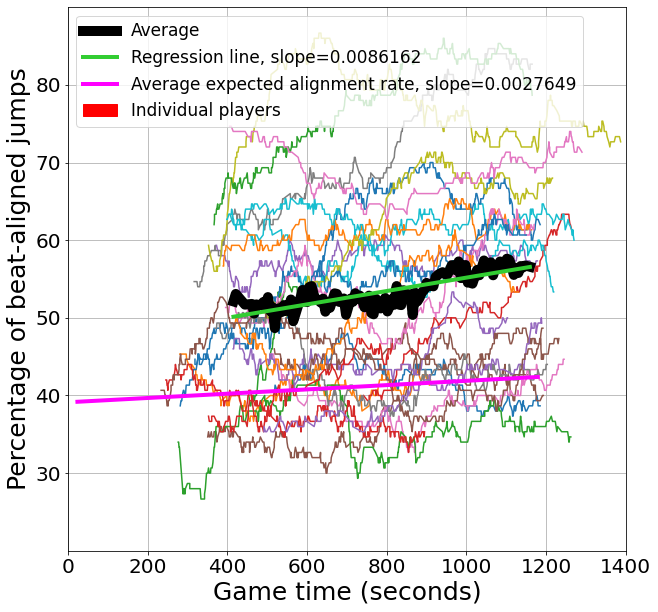

In [24]:
def moving_average(x, w):
    return (np.convolve(x, np.ones(w), 'valid') / w)*100


def rolling_average(filter, actions ="action", game_version='Controlled', played_as=0, roll_window=200, avg_includes_percentage=0.7):
    
    fig, ax=plt.subplots(figsize=(10,10))
    all_avg = []
    times = []
    hitwindows = []
    window_times= []
    for tag in playertags:
        files = get_player_files(playernumber=tag, version=game_version, played_as=played_as)
        if(files == None):
            continue
        beat, _, _ = files
        df_beat = pd.read_csv(os.path.join(mypath, beat),sep=',', skiprows=1)
        df_beat = df_beat[df_beat["Action"].isin(filter)]
        
        time = np.array(df_beat["Time"])
        hits = np.array(df_beat["Beathit"])
        
        beatlength = np.array(df_beat["BeatLength"], dtype = float)
        toleranceRange = np.array(df_beat["ToleranceRange"], dtype = float)
        #print(beatlength, toleranceRange)
        hitwindow = ((toleranceRange*2) / beatlength)*100 # that percentage of time is hitwindow
        # you should get this percentage if you hit randomly.
        
        avg = moving_average(hits, roll_window)
        ax.plot(time[roll_window-1:], avg)
        times.append(time[roll_window-1:])
        
        hitwindows.append(hitwindow)
        all_avg.append(avg)
        window_times.append(time)
    
    #stupido
    min_time = min([np.min(time) for time in times])
    max_time = max([np.max(time) for time in times])
    time_section_length = (max_time-min_time)/200
    x,y= [], [],
    
    for i in range(0,200):
        time_low = (min_time + (i* time_section_length))
        time_high = (min_time+ ((i+1)* time_section_length))

        #average all points in all_avg, whose time is within the intervall (time_low, time_high)
        time_filters_low = [time >= time_low for time in times]
        time_filters_high = [time < time_high for time in times]
        time_filters = [np.logical_and(time_filter_low, time_filter_high) for time_filter_low, time_filter_high in zip(time_filters_low, time_filters_high)]
        
        avg_individual = np.array([np.mean(avgs[time_filter]) for avgs, time_filter in zip(all_avg, time_filters)])
        
        
        if (np.count_nonzero(~np.isnan(avg_individual))/ avg_individual.size >= avg_includes_percentage):
            avg_section = np.nanmean(avg_individual)
            x.append(min_time+ ((i+0.5)* time_section_length))
            y.append(avg_section)
            
    min_time = min([np.min(time) for time in window_times]) + 1
    max_time = max([np.max(time) for time in window_times])
    time_section_length = (max_time-min_time)/30
    t,w= [], []
    for i in range(0,30):
        time_low = (min_time + (i* time_section_length))
        time_high = (min_time+ ((i+1)* time_section_length))

        #average all points in all_avg, whose time is within the intervall (time_low, time_high)
        time_filters_low = [time >= time_low for time in window_times]
        time_filters_high = [time < time_high for time in window_times]
        
        time_filters = [np.logical_and(time_filter_low, time_filter_high) for time_filter_low, time_filter_high in zip(time_filters_low, time_filters_high)]
        window_indiv = np.array([np.mean(window[time_filter]) for window, time_filter in zip(hitwindows, time_filters)])
        if (np.count_nonzero(~np.isnan(window_indiv))/ window_indiv.size >= avg_includes_percentage):
            window = np.nanmean(window_indiv)
            t.append(min_time+ ((i+0.5)* time_section_length))
            w.append(window)
    
    x,y = np.array(x), np.array(y)
    
    ax.plot(x,y, linewidth=10.0, color='black', label="Average", zorder=2)
    m,b = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d((m,b))
    print(poly1d_fn(x))
    ax.plot(x, poly1d_fn(x),linewidth=4.0, color='limegreen', label=f"Regression line, slope={round(m,7)}", zorder=4)
    
    t,w = np.array(t), np.array(w)
    #ax.plot(t, w, linewidth=10.0, color='gray', label="Expected line for random input", zorder=2)
    m,b = np.polyfit(t,w,1)
    #print(t, w)
    poly1d_fn = np.poly1d((m,b))
    ax.plot(t, poly1d_fn(t),linewidth=4.0, color='magenta', label=f"Average expected alignment rate, slope={round(m,7)}", zorder=3)
    # Ration between toleranceRange and beatlength depending song, averaged over all players.  (toleranceRange*2) / beatlength
    #ax.set_title(f"Version {game_version}: Beat hit accuracy rolling average. windowsize = {roll_window}", fontsize=25)
    ax.set_ylabel(f"Percentage of beat-aligned {actions}", fontsize=25)
    ax.set_xlabel(f"Game time (seconds)", fontsize=25)
    
    ax.yaxis.set_ticks(np.arange(30, 90, 10))
    ax.xaxis.set_ticks(np.arange(0, 1401, 200))
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    
    handles, labels = ax.get_legend_handles_labels()
    patch = mpatches.Patch(color='red', label='Individual players')
    handles.append(patch) 
    ax.legend(fontsize=17, handles=handles, loc='upper left')
    ax.grid(True)
    plt.axis([0, 1400, 20, 90])
    plt.savefig(f"Beat hit accuracy rolling average_{game_version}_{actions}.png")
    plt.show()
rolling_average(action_filter_jumps, actions="jumps", game_version='Controlled', played_as=0, roll_window=150, avg_includes_percentage = 0.7)

<ipython-input-22-bcd1cfe8f3aa>:26: RuntimeWarning: divide by zero encountered in true_divide
  hitwindow = ((toleranceRange*2) / beatlength)*100 # that percentage of time is hitwindow
c:\users\mummel\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\mummel\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[37.97928252 38.03780755 38.09633257 38.1548576  38.21338263 38.27190766
 38.33043269 38.38895771 38.44748274 38.50600777 38.5645328  38.62305783
 38.68158286 38.74010788 38.79863291 38.85715794 38.91568297 38.974208
 39.03273302 39.09125805 39.14978308 39.20830811 39.26683314 39.32535816
 39.38388319 39.44240822]


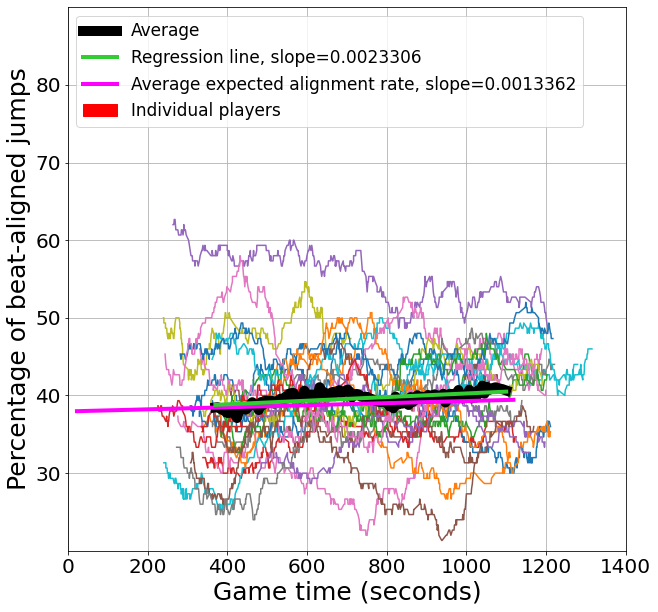

In [23]:
rolling_average(action_filter_jumps, actions="jumps", game_version='NoRhythm', played_as=0, roll_window=150)

In [13]:
#rolling_average(action_filter_attacks, actions="attacks", game_version='A', roll_window=100)

In [14]:
#rolling_average(action_filter_attacks, actions="attacks", game_version='B', roll_window=30)

# Average Stats for players for different Game Versions

In [15]:
# Betty. She knows where you've been.

states = {"Tutorial": 0, "Underground": 1, "Deepunderground" : 2, "Forest": 3, "Mushroom": 4, "Treetop": 5, "RedUnderground" : 6, "Spider": 7}
regions = {value: key for (key, value) in states.items()}

def region_state_machine(df_various, verbos = False):
    checkpoint_state = states["Tutorial"]
    state = states["Tutorial"]
    state_changes = []
    state_changes.append([0,state])
    previous = state
    for time, transition in zip(df_various["Time"],df_various["Action"]):
        if "Region" in transition:
            if state == states["Tutorial"]:
                #print("Tutorial")
                if transition == "Region underground entry 1":
                    state = states["Underground"]
                elif transition == "Region underground entry 2":
                    state = states["Deepunderground"]                
                elif transition == "Region 2nd forest start":
                    state = states["Forest"]
                elif "treetop" in transition:
                    state = states["Treetop"]
                elif "2nd forest" in transition:
                    state = states["Forest"]
                elif "deep underground" in transition:
                    state = states["Deepunderground"]
                elif "underground" in transition:
                    state= states["Underground"]
            elif state == states["Underground"]:
                #print("Underground")
                if transition == "Region first boss fight end":
                    state = states["Tutorial"]
                elif "deep underground" in transition:
                    state = states["Deepunderground"]
                elif transition == "Region underground entry 2":
                    state = states["Deepunderground"]
                elif transition == "Region 2nd forest start":
                    state = states["Forest"]
                elif transition == "Region Spider nest":
                    state = states["Spider"] # this one is illegal only deepunderground can transition to spider
            elif state == states["Deepunderground"]:
                #print("Deepunderground")
                if "deep underground" in transition:
                    state = states["Underground"]
                elif transition == "Region underground entry 2":
                    state = states["Tutorial"]
                elif transition == "Region Spider nest":
                    state = states["Spider"]
            elif state == states["Forest"]:
                #print("Forest")
                if transition == "Region first boss fight end":
                    state = states["Tutorial"]
                elif transition == "Region underground entry 1":
                    state = states["Underground"]
                elif transition == "Region 2nd forest end":
                    state = states["Mushroom"]
                elif "mushroom" in transition:
                    state = states["Mushroom"]
            elif state == states["Mushroom"]:
                #print("Mushroom")
                if transition == "Region 2nd forest end":
                    state = states["Forest"]
                elif transition == "Region treetop mushroom entry":
                    state = states["Treetop"]
                elif transition == "Region red underground entry":
                    state = states["RedUnderground"]
            elif state == states["Treetop"]:
                if transition == "Region treetop mushroom entry":
                    state = states["Mushroom"]
                elif transition == "Region treetop exit to tutorial forest":
                    state = states["Tutorial"]
                elif "first boss" in transition:
                    state = states["Tutorial"]
                elif "tutorial" in transition:
                    state = states["Tutorial"]
            elif state == states["RedUnderground"]:
                if transition == "Region red underground entry":
                    state = states["Mushroom"]
            elif state == states["Spider"]:
                if transition == "Region Spider nest":
                    state = states["Deepunderground"]
                    
            # failsaves for every state        
            if transition in ["Region jump tutorial start", "Region jump tutorial end", "Region first boss fight"]:
                state = states["Tutorial"]
            if transition in ["Region underground songtree entry"]:
                state = states["Underground"]
            if transition in ["Region red underground get over spikes jump riddle", "Region red underground bossplatform start", "Region red underground bossplatform end"]:
                state = states["RedUnderground"]
            if transition in ["Region 2nd forest spire 1", "Region 2nd forest spire 2"]:
                state = states["Forest"]
            if transition in ["Region mushroom downward entry", "Region mushroom slime boss start", "Region mushroom slime boss end", "Region mushroom songtree cliff", "Region mushroom lower platform right", "Region mushroom lower platform left"]:
                state = states["Mushroom"]
            if transition in ["Region treetop songtree", "Region treetop top spaceship platform", "Region treetop lower platform after songtree", "Region treetop leftmost spaceship platform", "Region treetop low spaceship platform"]:
                state = states["Treetop"]
                
            if verbos:
                print(f"{time} {transition} -> {regions[state]}")
        if transition== "player death":
            # set state to whatever state the active checkpoint is in
            state = checkpoint_state
            
            if verbos:
                print(f"{time} player death -> {regions[state]}")
        if "Checkpoint Activated" in transition:
            if "tutorial" in transition:
                checkpoint_state = states["Tutorial"]
            elif "forest" in transition:
                checkpoint_state = states["Forest"]
            elif "mushroom" in transition:
                checkpoint_state = states["Mushroom"]
            elif "spider" in transition:
                checkpoint_state = states["Spider"]
            elif "treetop" in transition:
                checkpoint_state = states["Treetop"]
            elif "underground red" in transition:
                checkpoint_state = states["RedUnderground"]
            elif "underground" in transition:
                checkpoint_state = states["Underground"]
            else:
                checkpoint_state = state
            state = checkpoint_state
            
        if "SpaceShip collected" in transition:
            if "tutorial" in transition:
                state = states["Tutorial"]
            elif "second_underground" in transition:
                state = states["RedUnderground"]
            elif "underground" in transition:
                state = states["Deepunderground"]
            elif "mushroom" in transition:
                state = states["Mushroom"]
            elif "treetop" in transition:
                state = states["Treetop"]
            elif "spider" in transition:
                state = states["Spider"]
            if verbos:
                print(f"{time} space ship collected -> {regions[state]}")
        if state != previous:
            if verbos:
                print(f"state change !!!!!")
            state_changes.append([time, state])
            previous = state
    return state_changes
            #print(f"{time } checkpoint {transition} in {regions[checkpoint_state]}")
# player death messes things up. upon player death reset the state to whatever region the last active checkpoint is located in            

In [16]:
# percantage of hits for rhythm controlled and No Rhythm
def hit_percentage(label,df_beat,verbos=True):
    hit = np.count_nonzero(df_beat["Beathit"])
    cnt = len(df_beat["Beathit"])
    #beatlength = np.array(df_beat["BeatLength"], dtype = float)
    #toleranceRange = np.array(df_beat["ToleranceRange"], dtype = float)
    #hitwindow = (toleranceRange*2) / beatlength
    
    
    percentage = round((hit/cnt) * 100,2)
    if verbos:
        print(f"{label} hits: {hit}/{cnt} = {percentage} %")
    return hit, cnt, percentage
    

def region_discovery(state_change, game_end_time=1200, verbos=True):
    state_time = state_change[:,0]
    state_state = state_change[:,1]
    
    unique = len(np.unique(state_state))
    total = 8
    percentage = round((unique/total)*100,2)
    if verbos:
        print(f"unique regions discovered: {unique}/{total} = {percentage} %")
        print(f"total region changes: {len(state_state)}")
    #time spent in region
    regiontime = {"Tutorial": 0, "Underground": 0, "Deepunderground" : 0, "Forest": 0, "Mushroom": 0, "Treetop": 0, "RedUnderground" : 0, "Spider": 0}
    for index in range(len(state_state)):
        start, end = state_time[index], game_end_time
        if index < len(state_state)-1:
            end = state_time[index+1]
        regiontime[regions[state_state[index]]] += end - start
    if verbos:
        print(f"time spent in regions: {regiontime}")
    return unique, percentage, len(state_state), regiontime

    
def song_playtime(df_songchange, game_end_time=1200, verbos=True):
    # time spent in each song
    songchange = list(df_songchange["Action"])
    songchange_time= list(df_songchange["Time"])
    playtime = {"SongChange 0":0, "SongChange 1":0, "SongChange 2":0}
    for index in range(len(songchange)):
        start, end = songchange_time[index], game_end_time
        if index < len(songchange)-1:
            end = songchange_time[index+1]
        playtime[songchange[index]] += end - start
    if verbos:
        print(f"time spent in songs: {playtime}")
    return playtime ,len(songchange)


def player_death(df_deaths_player, verbos=True):
    player_combat_death_mask = np.array(~df_deaths_player["HitBy"].str.contains("Boundaries|spike", case=False, regex=True))
    death_number = np.arange(1,len(df_deaths_player["Time"])+1)
    combat_deaths = len(death_number[player_combat_death_mask])
    jumpnrun_deaths = len(death_number[~player_combat_death_mask])
    
    spike_deaths = len(df_deaths_player.loc[df_deaths_player["HitBy"].str.contains("spike", case=False)])
    if verbos:
        print(f"player combat deaths: {combat_deaths}, player jumpnrun deaths: {jumpnrun_deaths-spike_deaths}, spike deaths {spike_deaths}")
    return combat_deaths, jumpnrun_deaths-spike_deaths, spike_deaths
    
    
def enemy_death(df_enemy_death, verbos=True):
    enemy_deaths = len(df_enemy_death)
    if verbos:
        print(f"enemy deaths: {enemy_deaths}")
    return enemy_deaths


def spaceship_cnt(df_spaceship, verbos=True):
    cnt = len(df_spaceship)
    total = 9
    percentage = round((cnt/total) * 100,2)
    if verbos:
        print(f"space ship parts collected: {cnt}/{total} = {percentage} %")
    return cnt, percentage


def combat_damage(df_combat, verbos = True):
    
    df_damage = df_combat.loc[df_combat["Action"].str.contains("damaged|death", case=False, regex=True)]
    player_damaged = df_damage.loc[df_damage["Entity"].str.contains("player", case=False)]
    player_damaged = player_damaged.loc[~player_damaged["HitBy"].str.contains("spike|Boundaries", case=False, regex=True)]# ignore spikes and boundaries for player damaged
    player_damage_cnt = len(player_damaged)
    player_against_type_set = set(player_damaged["HitBy"])
    player_fight_against_type = len(player_against_type_set)

    player_healed = df_combat.loc[df_combat["Action"].str.contains("heal", case=False)]
    player_healed_cnt = len(player_healed)
    

    enemy_damaged = df_damage.loc[df_damage["HitBy"].str.contains("player", case=False)]
    #print(enemy_damaged)
    enemy_damage_cnt = len(enemy_damaged)
    enemy_damaged_type_set = set(enemy_damaged["Entity"])
    enemy_damaged_type_cnt = len(enemy_damaged_type_set)
        
    if verbos:
        print(f"player damaged {player_damage_cnt} times. Hit by {player_fight_against_type} enemy types: {player_against_type_set}")
        print(f"player healed {player_healed_cnt}")
        print(f"enemy damaged {enemy_damage_cnt} times. {enemy_damaged_type_cnt} enemy types damaged: {enemy_damaged_type_set}")
    #print(player_damaged, player_healed, enemy_damaged, sep='\n')
    return player_damage_cnt, player_fight_against_type, player_healed_cnt, enemy_damage_cnt, enemy_damaged_type_cnt


In [17]:
def analysis_stats(beat, various, combat, verbos=False):
    if not isinstance(beat, str):
        raise TypeError("The beat wasn't passed as a String")
    #print(beat, various, combat)
    
    #prepare and read data
    df_beat = pd.read_csv(os.path.join(mypath, beat), sep=',', skiprows = 1)
    df_beat_jumps = df_beat[df_beat["Action"].isin(action_filter_jumps)]
    df_beat_attacks = df_beat[df_beat["Action"].isin(action_filter_attacks)]
    
    df_various = pd.read_csv(os.path.join(mypath, various), sep=',', skiprows = 1)
    df_various = df_various.drop_duplicates(subset= ["Time","Action"], keep='first')
    #df_input_device = df_various[df_various["Action"].isin(["Keyboard & Mouse", "Gamepad"])]
    state_change = np.array(region_state_machine(df_various)) # we call upon Betty once more
    df_spaceship = df_various.loc[df_various["Action"].str.contains("SpaceShip", case=True)]
    df_songchange = df_various.loc[df_various["Action"].str.contains("Songchange", case = False)] 

    df_combat = pd.read_csv(os.path.join(mypath, combat), sep=',', skiprows = 1)
    df_deaths = df_combat.loc[df_combat["Action"].str.contains("death", case=False)]
    df_deaths_enemy = df_deaths.loc[df_deaths["HitBy"].str.contains("Player", case=False)]
    df_deaths_player = df_deaths.loc[df_deaths["Entity"].str.contains("player", case=False)]
    df_deaths_player = df_deaths_player.loc[~df_deaths_player["HitBy"].str.contains("resetToCheckpoint", case=False)]
    
    game_end_time = max(list(df_various["Time"])[-1], list(df_beat["Time"])[-1])
    
    #get stats
    song_playtime_dict, song_changes = song_playtime(df_songchange, game_end_time, verbos)
    j_hit, j_cnt, j_percentage = hit_percentage("Jumps", df_beat_jumps, verbos)
    a_hit, a_cnt, a_percentage = hit_percentage("Attacks", df_beat_attacks, verbos)
    s_cnt, s_percentage = spaceship_cnt(df_spaceship, verbos)
    enemy_deaths = enemy_death(df_deaths_enemy, verbos)
    combat_deaths, boundary_deaths, spike_deaths = player_death(df_deaths_player, verbos)
    unique_regions_discovered, r_percentage, region_changes, region_time_dict = region_discovery(state_change, game_end_time, verbos)
    player_damage_cnt, player_damage_from_type, player_healed_cnt, enemy_damage_cnt, enemy_damaged_type_cnt = combat_damage(df_combat, verbos)
    
    return [j_hit, j_cnt, j_percentage,
            a_hit, a_cnt, a_percentage, 
            enemy_deaths,
            
            player_damage_cnt,  player_healed_cnt,
            combat_deaths, boundary_deaths + spike_deaths, 
            
            s_cnt, s_percentage,
            unique_regions_discovered, r_percentage, region_changes, 
            song_changes], song_playtime_dict, region_time_dict

# enemy_damage_cnt, enemy_damaged_type_cnt, player_damage_from_type,

titles= ["Jumps beat-aligned", "Total jumps", "Percentage of beat-aligned jumps",
         "Attacks beat-aligned", "Total attacks", "Percentage of attacks beat-aligned", 
         "Enemy deaths",
         
         "Player got damaged by enemy", "Player got healed", 
         "Player deaths through combat", "Player deaths platformer elements",
         
         
        "Spaceships collected (max 9)", "Spaceship collection percentage",
        "Regions discovered (max 8)", "Regions discovered percentage", "Player entering a region",
         "World music changes"]

#"Enemy got damaged by player", "Enemy types got damaged (max 10)", 


def global_analysis(played_as=0, df = df, verbos = True): # 0 for either first or second, 1 for first, 2 for second
    np.set_printoptions(suppress=True)
    ret_stats = []
    ret_songtimes = []
    ret_regiontimes = []
    for version in ["Controlled", "NoRhythm"]: #A, B
        stats = []# stats, songtimes, regiontimes
        song_times = []
        region_times = []
        dataset_num = 0
        
        for tag in playertags:
            files = get_player_files(tag, version, played_as)
            if files is None:
                continue
            s, song_dict, region_dict = analysis_stats(*files)
            #print(tag, region_dict)
            dataset_num += 1
            stats.append(s)
            song_times.append(list(song_dict.values()))
            region_times.append(list(region_dict.values()))
        
        #calculate standard deviations
        stats_std =  np.rint(np.std(np.array(stats), axis=0)).astype(int)
        song_times_std =  np.rint(np.std(np.array(song_times), axis=0)).astype(int)
        region_times_std =  np.rint(np.std(np.array(region_times), axis=0)).astype(int)
        
        #calculate means
        stats = np.rint(np.mean(np.array(stats), axis=0)).astype(int)
        avg_song_times = np.rint(np.mean(song_times, axis=0)).astype(int)
        region_times = np.rint(np.mean(np.array(region_times), axis=0)).astype(int)
        
        ret_stats.append(stats)
        ret_stats.append(stats_std)
        
        ret_songtimes.append(avg_song_times)
        ret_songtimes.append(song_times_std)
        
        ret_regiontimes.append(region_times)
        ret_regiontimes.append(region_times_std)
        
        if verbos:
            print(f"\n\nVersion {version}, {dataset_num} players in datasets")
            for index in range(len(titles)):
                print(f"{titles[index]}: {stats[index]}")
            print(f"song times {song_times}")
            print(f"song playtimes: yellow {np.mean(song_times[:,0])}, blue {np.mean(song_times[:,1])}, red {np.mean(song_times[:,2])}")
            region_names = list(states.keys())
            for index in range(len(region_names)):
                print(f"{region_names[index]}: {region_times[index]}",end=' ')
    
    return ret_stats, ret_songtimes, ret_regiontimes # statsA, stdA, statsB, stdB 
    #print(region_times)

In [18]:
stats_df = pd.DataFrame()#columns=titles)
song_df = pd.DataFrame()#columns=["yellow", "blue", "red"])
region_df = pd.DataFrame()#columns=list(states.keys()))
columns = [['A','A SD','B', 'B SD'],['1A', '1A SD', '1B','1B SD'], ['2A','2A SD', '2B', '2B SD']] 

import pandas
cnt = 0
for i in range(3):
    ret_stats, ret_songtimes, ret_regiontimes = global_analysis(i, verbos = False)
    for line,column in zip(ret_stats,columns[i]):
        stats_df[column] = line
    for line,column in zip(ret_songtimes,columns[i]):
        song_df[column] = line
    for line,column in zip(ret_regiontimes,columns[i]):
        region_df[column] = line

        

def post_process_df(df, index_title, index_list):
    df.insert(0, column='Game Version', value = index_list)
    df.set_index('Game Version', inplace=True)
    #df = df.transpose()
    df.index.name = index_title
    return df

stats_df = post_process_df(stats_df, 'stat',titles)
song_df = post_process_df(song_df, 'song',["Yellow", "Blue", "Red"])
region_df = post_process_df(region_df, 'region',list(states.keys()))

try:
    pass
    stats_df.to_csv("game_stat_analysis.csv", index=True)
    song_df.to_csv("game_song_analysis.csv", index=True)
    region_df.to_csv("game_region_analysis.csv", index=True)
except:
    print("coudnt save new verison\n")
    
print(f"game stats:\n{stats_df.to_string()}\n\n")
print(f"song time:\n{song_df.to_string()}\n\n")
print(f"region time:\n{region_df.to_string()}\n\n")

game stats:
                                      A  A SD    B  B SD   1A  1A SD   1B  1B SD   2A  2A SD   2B  2B SD
stat                                                                                                    
Jumps beat-aligned                  267    95  223    59  275     93  184     36  258     96  255     56
Total jumps                         507   107  558   123  505     92  488     99  508    123  614    111
Percentage of beat-aligned jumps     52    11   40     5   54     11   38      2   50     12   41      5
Attacks beat-aligned                118    47   69    43  121     45   88     38  114     49   54     41
Total attacks                       231   105  178   108  244    116  229     92  215     85  136    102
Percentage of attacks beat-aligned   53    11   39     7   52     13   38      4   53      8   40      8
Enemy deaths                         23    13   34    23   23     10   43     17   24     16   26     24
Player got damaged by enemy          45    

# Graph+Stats per Player

In [19]:
import matplotlib
song_color = {"SongChange 0": 'gold', "SongChange 1": 'deepskyblue', "SongChange 2": 'lightcoral'}
region_color = {0: 'gold', 1: 'royalblue', 2 : 'purple', 3: 'green', 4: 'tomato', 5: "mediumturquoise", 6: "maroon", 7: "navy"}
#states = {"Tutorial": 0, "Underground": 1, "Deepunderground" : 2, "Forest": 3, "Mushroom": 4, "Treetop": 5, "RedUnderground" : 6, "Spider": 7}


def analysis_graphic(beat: str, various: str, combat: str, verbos = False):
    if not isinstance(beat, str):
        raise TypeError("The beat wasn't passed as a String")
    print(beat, various, combat)
    
    df_various = pd.read_csv(os.path.join(mypath, various), sep=',', skiprows = 1)
    df_various = df_various.drop_duplicates(subset= ["Time","Action"], keep='first')
    df_combat = pd.read_csv(os.path.join(mypath, combat), sep=',', skiprows = 1)
    df_input_device = df_various[df_various["Action"].isin(["Keyboard & Mouse", "Gamepad"])]
    df_beat = pd.read_csv(os.path.join(mypath, beat), sep=',', skiprows = 1)
    print(df_various)
    game_end_time = max(list(df_various["Time"])[-1], list(df_beat["Time"])[-1])
    
    df_songchange = df_various.loc[df_various["Action"].str.contains("Songchange", case = False)]
    songchange = list(df_songchange["Action"])
    songchange_time = list(df_songchange["Time"])                      
               
    fig, ax=plt.subplots(nrows = 2, ncols = 2 ,figsize=(20,20)) # sharex=True
    
    # Beat Plots
    def beat_delta_scatter_plot(title, ind1, ind2, action_filter):  # nested function goes brrrrrrrr
        df_beat_filtered = df_beat[df_beat["Action"].isin(action_filter)]
        
        # scatterplot time and beatdelta in red and green
        hit_filter = np.array(df_beat_filtered["Beathit"])
        t = np.array(df_beat_filtered["Time"])
        d = np.array(df_beat_filtered["BeatDelta"])
        
        ax[ind1, ind2].scatter(t[hit_filter],d[hit_filter], zorder=4, c="green", label="in union with beat")
        ax[ind1, ind2].scatter(t[~hit_filter],d[~hit_filter], zorder=4, c="red", label="missed the beat")
        
        # songchanges in background
        for index in range(len(songchange)):
            start, end = songchange_time[index], game_end_time
            if index < len(songchange)-1:
                end = songchange_time[index+1]
            ax[ind1, ind2].axvspan(start, end, facecolor=song_color[songchange[index]], alpha=0.3, zorder=3, label=f"{songchange[index]}")
        handels, labels = ax[ind1, ind2].get_legend_handles_labels()
        by_label = dict(zip(labels, handels))
        
        ax[ind1, ind2].legend(by_label.values(), by_label.keys(), loc='lower right', fontsize=15)  
        ax[ind1, ind2].set_title(f"{title}", fontsize = 25)
        ax[ind1, ind2].set_ylabel("BeatDelta", fontsize = 25)
        ax[ind1, ind2].set_xlabel("Time", fontsize = 25)
        ax[ind1, ind2].tick_params(axis='both', which='major', labelsize=20)
        ax[ind1, ind2].tick_params(axis='both', which='minor', labelsize=20)
        ax[ind1, ind2].grid(True)
        
        hit_percentage(title, df_beat)
    
    beat_delta_scatter_plot("Jumps", 0, 0, action_filter_jumps)
    beat_delta_scatter_plot("Attacks", 0, 1, action_filter_attacks)
    song_playtime(df_songchange, game_end_time)
    
    #Progression Plot
    ind1, ind2 = 1,0
    df_spaceship = df_various.loc[df_various["Action"].str.contains("SpaceShip", case=True)]
    spaceships = list(df_spaceship["Action"])
    time = np.array(df_spaceship["Time"])
    if verbos:
        print("space ship dataframe", df_spaceship)
    ax[ind1, ind2].scatter(time,np.arange(1,len(spaceships)+1), zorder=4, color='black', linewidth=2.0, label="Spaceship Part Collected")
    time = np.insert(time, 0, 0)
    ax[ind1, ind2].plot(time,np.arange(0, len(spaceships)+1), zorder=4, color = 'black')

    state_change = np.array(region_state_machine(df_various,verbos)) # we call upon Betty
    state_time = state_change[:,0]
    state_state = state_change[:,1]
    for index in range(len(state_state)):
        start, end = state_time[index], game_end_time
        if index < len(state_state)-1:
            end = state_time[index+1]
        ax[ind1, ind2].axvspan(start, end, facecolor=region_color[state_state[index]], alpha=0.5, zorder=3, label=f"{regions[state_state[index]]} Region")

    ax[ind1, ind2].set_yticks(np.arange(0,10))
    ax[ind1, ind2].set_title(f"Exploration Progress", fontsize=25)
    ax[ind1, ind2].set_ylabel("Total Space Ship Parts Collected", fontsize=25)
    ax[ind1, ind2].set_xlabel("Time", fontsize = 25)
    handels, labels = ax[ind1, ind2].get_legend_handles_labels()
    by_label = dict(zip(labels, handels))
    ax[ind1, ind2].legend(by_label.values(), by_label.keys(), fontsize=15)
    ax[ind1, ind2].tick_params(axis='both', which='major', labelsize=20)
    ax[ind1, ind2].tick_params(axis='both', which='minor', labelsize=20)
    ax[ind1, ind2].grid(True)
    
    spaceship_cnt(df_spaceship)
    region_discovery(state_change, game_end_time)
    
    # Combat Plot
    ind1, ind2 = 1,1
    df_deaths = df_combat.loc[df_combat["Action"].str.contains("death", case=False)]
    #print(df_deaths)
    

    df_deaths_enemy = df_deaths.loc[df_deaths["HitBy"].str.contains("Player", case=False)]
    
    df_deaths_player = df_deaths.loc[df_deaths["Entity"].str.contains("player", case=False)]
    df_deaths_player = df_deaths_player.loc[~df_deaths_player["HitBy"].str.contains("resetToCheckpoint", case=False)]
    player_death(df_deaths_player)
    enemy_death(df_deaths_enemy)
    combat_damage(df_combat)
    
    player_combat_death_mask = np.array(~df_deaths_player["HitBy"].str.contains("Boundaries|spike", case=False, regex=True))
    death_time = np.array(df_deaths_player["Time"])
    death_number = np.arange(1,len(df_deaths_player["Time"])+1)
    
    
    ax[ind1, ind2].scatter(df_deaths_enemy["Time"], np.arange(1,len(df_deaths_enemy["Time"])+1), label="Enemy alien death", linewidth=2.0, color='darkorange')
    ax[ind1, ind2].scatter(death_time[player_combat_death_mask], death_number[player_combat_death_mask], label="Player death combat",linewidth=2.0, color='blue')
    ax[ind1, ind2].scatter(death_time[~player_combat_death_mask], death_number[~player_combat_death_mask], label="Player death through spikes or level boundaries", linewidth=2.0, color='blue', marker='x')
    
    ax[ind1, ind2].set_title(f"Combat", fontsize = 25)
    ax[ind1, ind2].set_ylabel("Deaths", fontsize = 25)
    ax[ind1, ind2].set_xlabel("Time", fontsize = 25)
    ax[ind1, ind2].legend(loc = 'upper left', fontsize=15)
    ax[ind1, ind2].tick_params(axis='both', which='major', labelsize=20)
    ax[ind1, ind2].tick_params(axis='both', which='minor', labelsize=20)
    ax[ind1, ind2].grid(True)
    
    # Global plot settings
    #fig.suptitle (f"{beat}", fontsize = 20)
    ax[0,1].sharex(ax[0,0])
    ax[1,0].sharex(ax[0,0])
    ax[1,1].sharex(ax[0,0])
    ax[0,1].sharey(ax[0,0])
    tag = '_'.join(beat.split('_')[0:2])
    plt.savefig(f"individualplayers/{tag}_plot.png")
    plt.show()

In [20]:
#analysePlayer("045522", "NoRhythm", verbos=False)
#analysePlayer("088835", "NoRhythm")
#analysis_graphic(*get_player_files("000990", "NoRhythm"), verbos=False)
#analysis_graphic(*get_player_files("976861", "Controlled"), verbos=False)

# by_index = 15
#analysis_graphic(beat_metrics[by_indes],various_metrics[by_index],combat_metrics[by_index])

000990_NoRhythm_04_12_21_12_39_Beat_Metric.csv 000990_NoRhythm_04_12_21_12_39_Various_Metric.csv 000990_NoRhythm_04_12_21_12_39_Combat_Metric.csv
      Version  Time                                     Action
0    NoRhythm    10                           Keyboard & Mouse
1    NoRhythm     0                               SongChange 0
2    NoRhythm     1                                    Gamepad
3    NoRhythm     1                 Region jump tutorial start
5    NoRhythm    15                 Region jump tutorial start
..        ...   ...                                        ...
213  NoRhythm  1186  Checkpoint Activated Checkpoint mushroom1
214  NoRhythm  1191             Region mushroom downward entry
216  NoRhythm  1195                      Region 2nd forest end
218  NoRhythm  1205                  Region 2nd forest spire 2
220  NoRhythm  1213                           Keyboard & Mouse

[141 rows x 3 columns]
Jumps hits: 398/716 = 55.59 %
Attacks hits: 398/716 = 55.59 %
time spent i

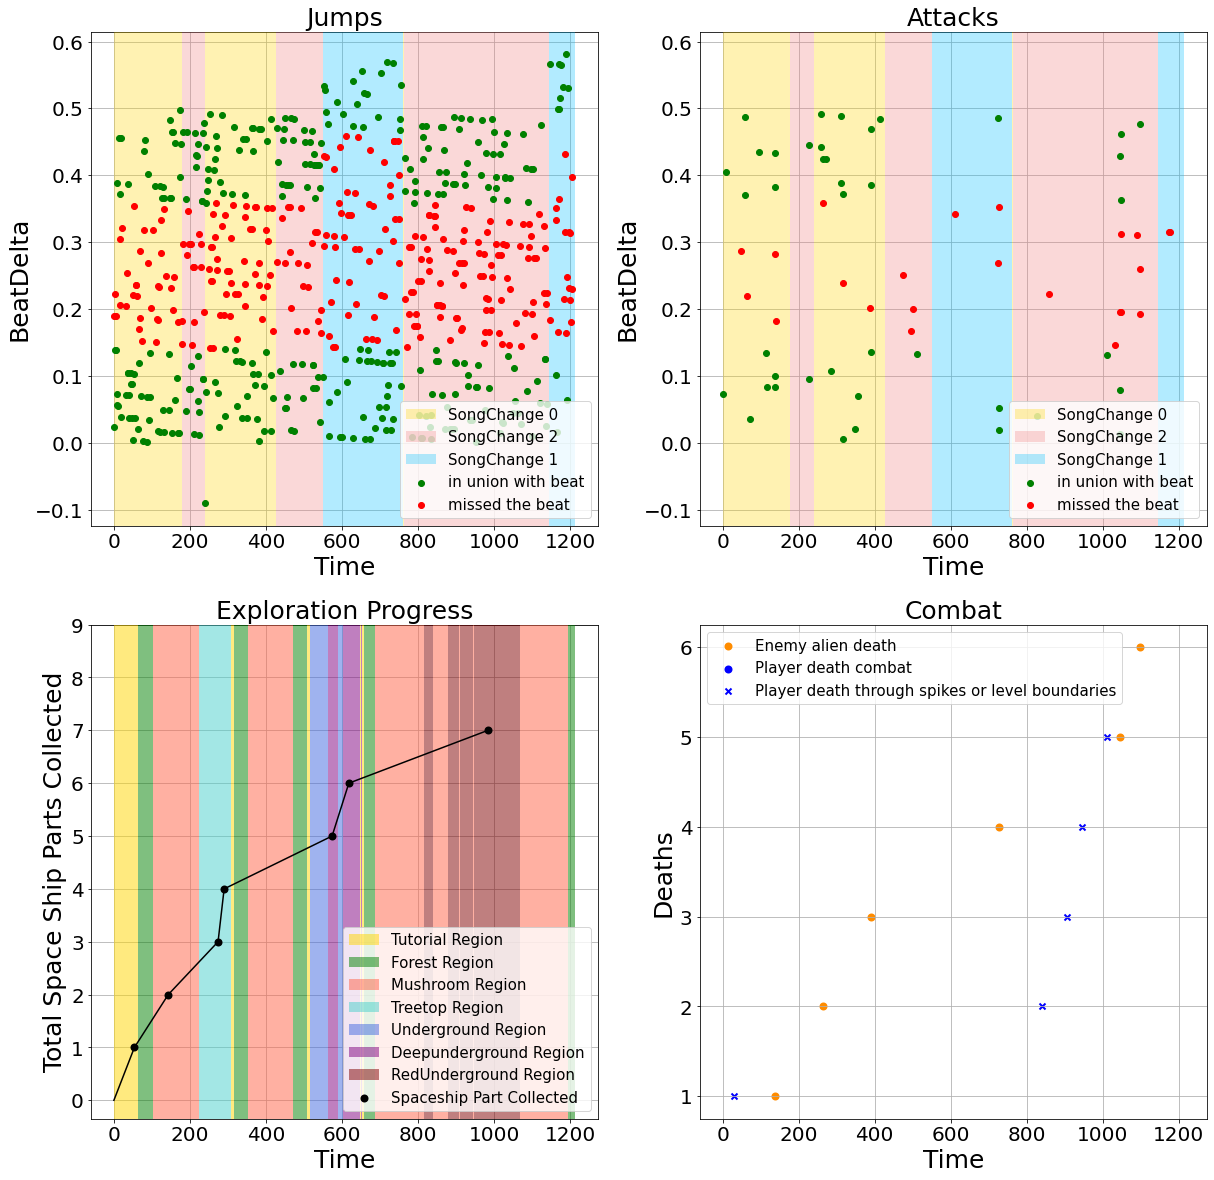

000990_RhythmControlled_04_12_21_12_11_Beat_Metric.csv 000990_RhythmControlled_04_12_21_12_11_Various_Metric.csv 000990_RhythmControlled_04_12_21_12_11_Combat_Metric.csv
              Version  Time                                      Action
0    RhythmControlled    25                            Keyboard & Mouse
1    RhythmControlled     0                                 Fixing sync
2    RhythmControlled     0                                SongChange 0
3    RhythmControlled     1                                     Gamepad
4    RhythmControlled     7                  Region jump tutorial start
..                ...   ...                                         ...
192  RhythmControlled  1163  Checkpoint Activated Checkpoint mushroom 2
193  RhythmControlled  1163            Region mushroom slime boss start
195  RhythmControlled  1177            Region mushroom slime boss start
197  RhythmControlled  1180                            Keyboard & Mouse
198  RhythmControlled  1180           

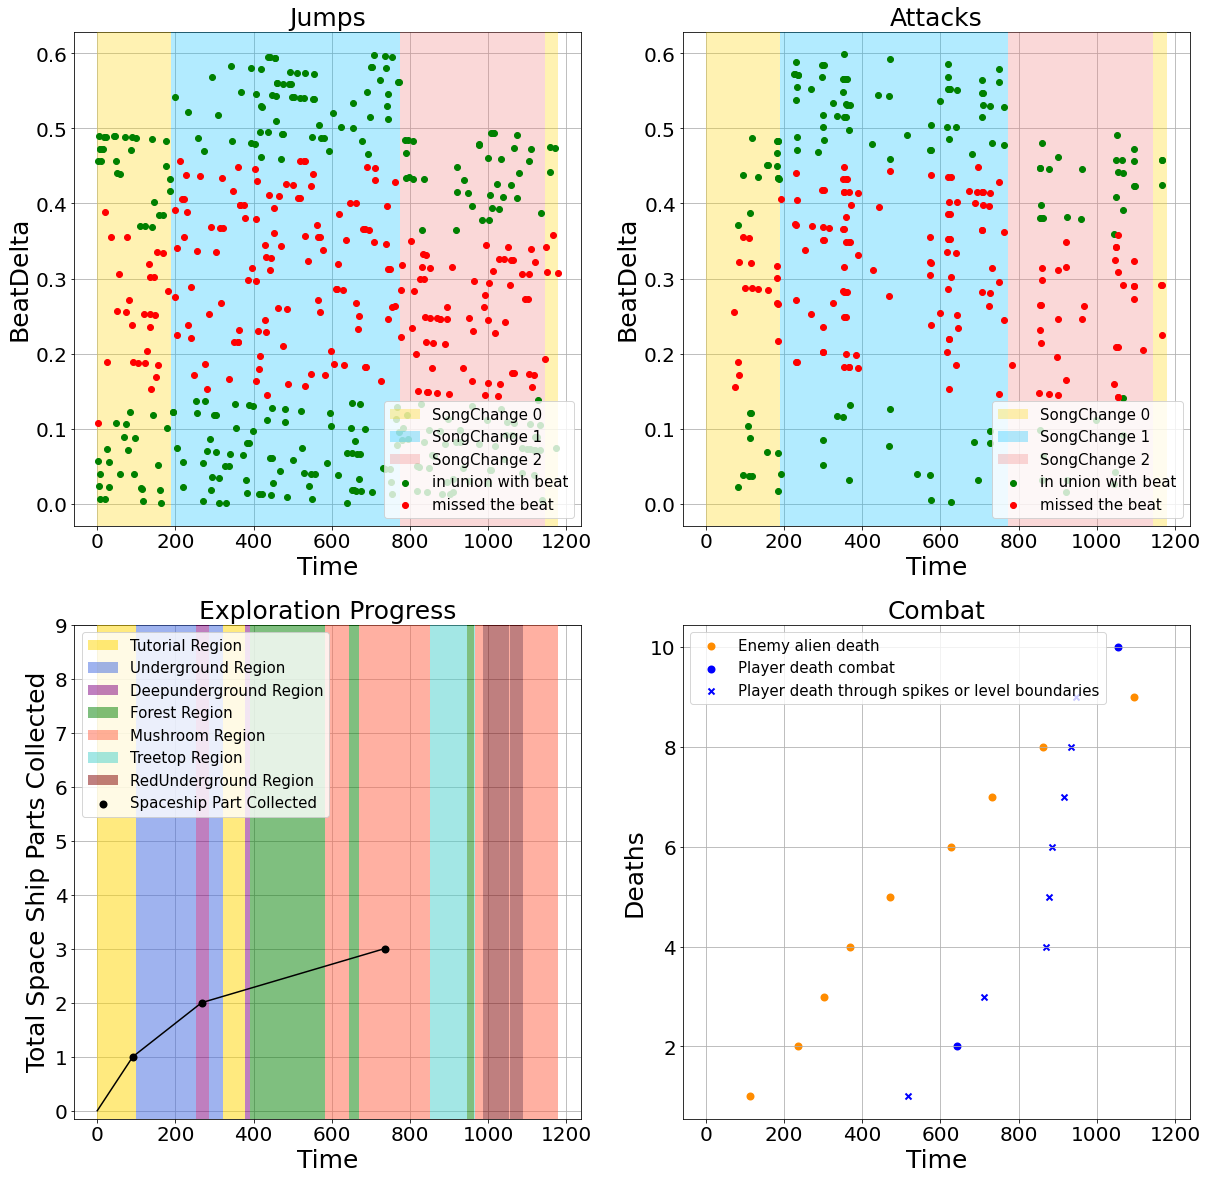

045522_NoRhythm_10_12_21_02_08_Beat_Metric.csv 045522_NoRhythm_10_12_21_02_08_Various_Metric.csv 045522_NoRhythm_10_12_21_02_08_Combat_Metric.csv
      Version  Time                                             Action
0    NoRhythm     9                                   Keyboard & Mouse
1    NoRhythm     0                                            Gamepad
2    NoRhythm     0                                       SongChange 0
3    NoRhythm     1                         Region jump tutorial start
5    NoRhythm    13                           Region jump tutorial end
..        ...   ...                                                ...
202  NoRhythm  1025  Region red underground get over spikes jump ri...
204  NoRhythm  1026  Region red underground get over spikes jump ri...
206  NoRhythm  1037    Checkpoint Activated Checkpoint underground red
207  NoRhythm  1040                                           Game End
208  NoRhythm  1040             SpaceShip collected second_underground

[

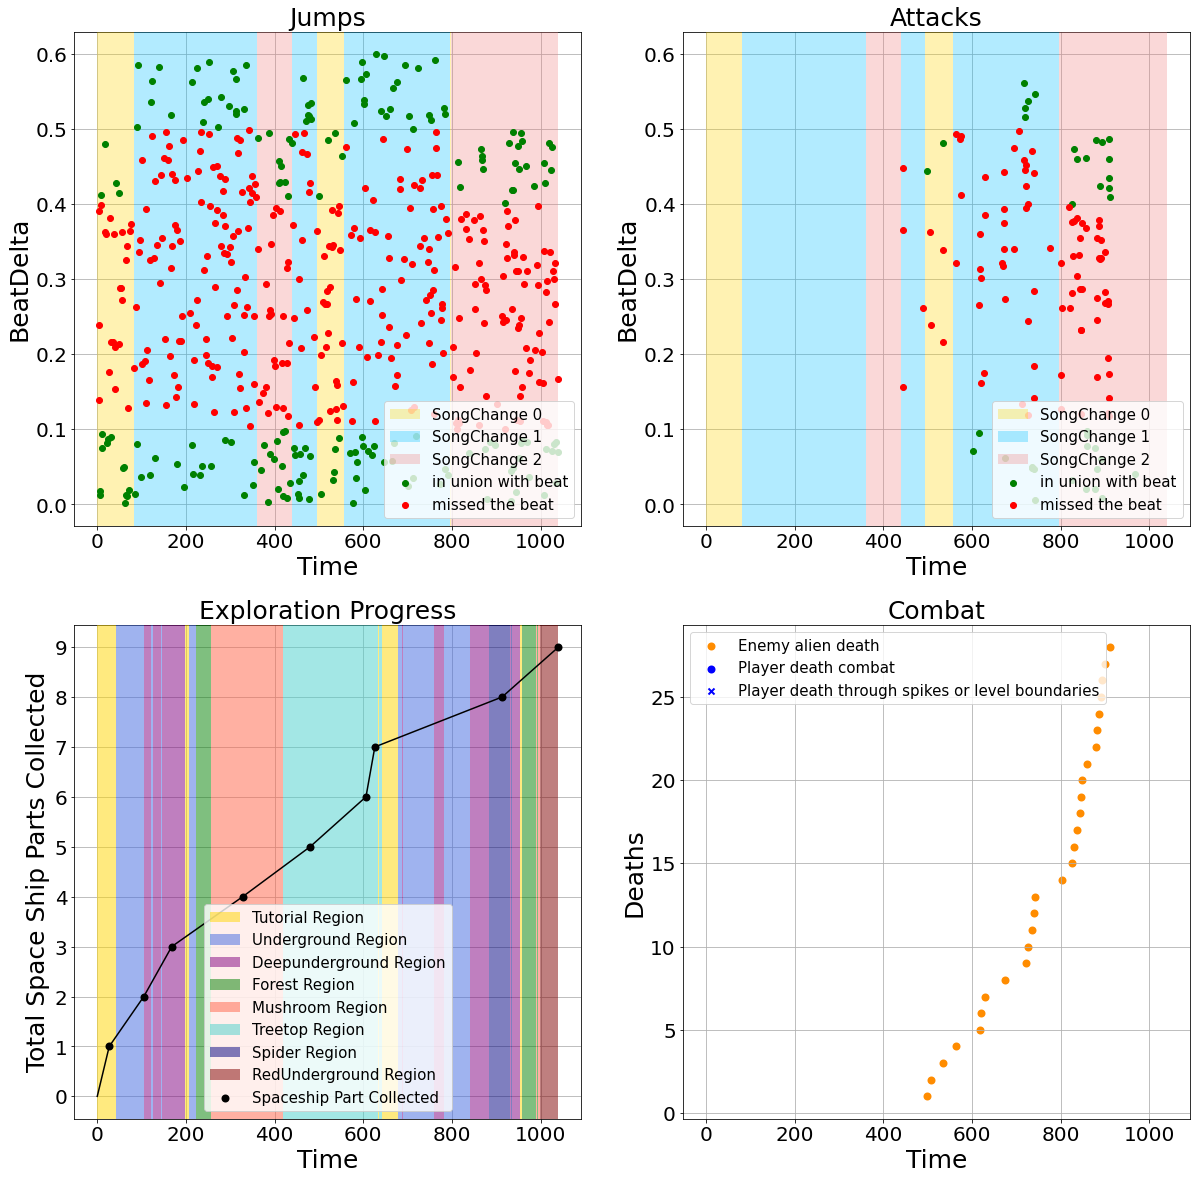

045522_RhythmControlled_10_12_21_01_39_Beat_Metric.csv 045522_RhythmControlled_10_12_21_01_39_Various_Metric.csv 045522_RhythmControlled_10_12_21_01_39_Combat_Metric.csv
              Version  Time                                Action
0    RhythmControlled    15                      Keyboard & Mouse
1    RhythmControlled     0                               Gamepad
2    RhythmControlled     0                           Fixing sync
3    RhythmControlled     0                          SongChange 0
4    RhythmControlled     2            Region jump tutorial start
..                ...   ...                                   ...
144  RhythmControlled  1150        Region mushroom songtree cliff
146  RhythmControlled  1161  Region mushroom lower platform right
148  RhythmControlled  1192         Region treetop mushroom entry
150  RhythmControlled  1194                           Fixing sync
152  RhythmControlled  1195                           Fixing sync

[97 rows x 3 columns]
Jumps hits: 407

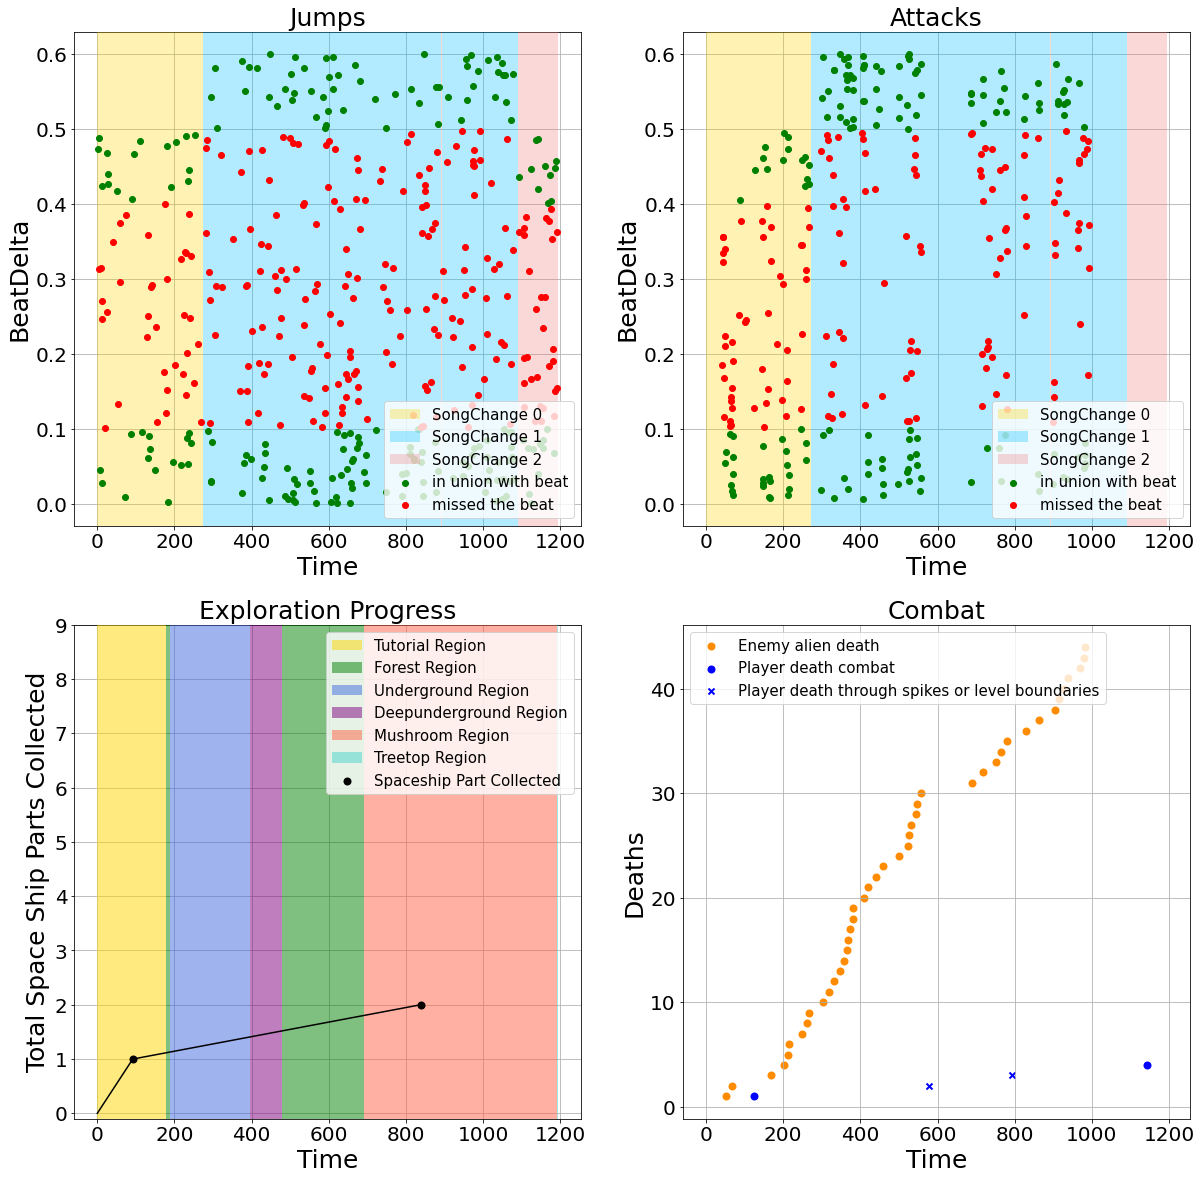

061295_NoRhythm_05_12_21_05_27_Beat_Metric.csv 061295_NoRhythm_05_12_21_05_27_Various_Metric.csv 061295_NoRhythm_05_12_21_05_27_Combat_Metric.csv
      Version  Time                                      Action
0    NoRhythm    18                            Keyboard & Mouse
1    NoRhythm     0                                SongChange 0
2    NoRhythm     2                                     Gamepad
3    NoRhythm     3                  Region jump tutorial start
5    NoRhythm    18                    Region jump tutorial end
..        ...   ...                                         ...
149  NoRhythm  1060  Checkpoint Activated Checkpoint mushroom 2
152  NoRhythm  1060            Region mushroom slime boss start
155  NoRhythm  1078              Region mushroom slime boss end
157  NoRhythm  1138    Checkpoint Activated Song_Tree mushrooms
158  NoRhythm  1139                                SongChange 0

[100 rows x 3 columns]
Jumps hits: 342/918 = 37.25 %
Attacks hits: 342/918 = 37.25 %


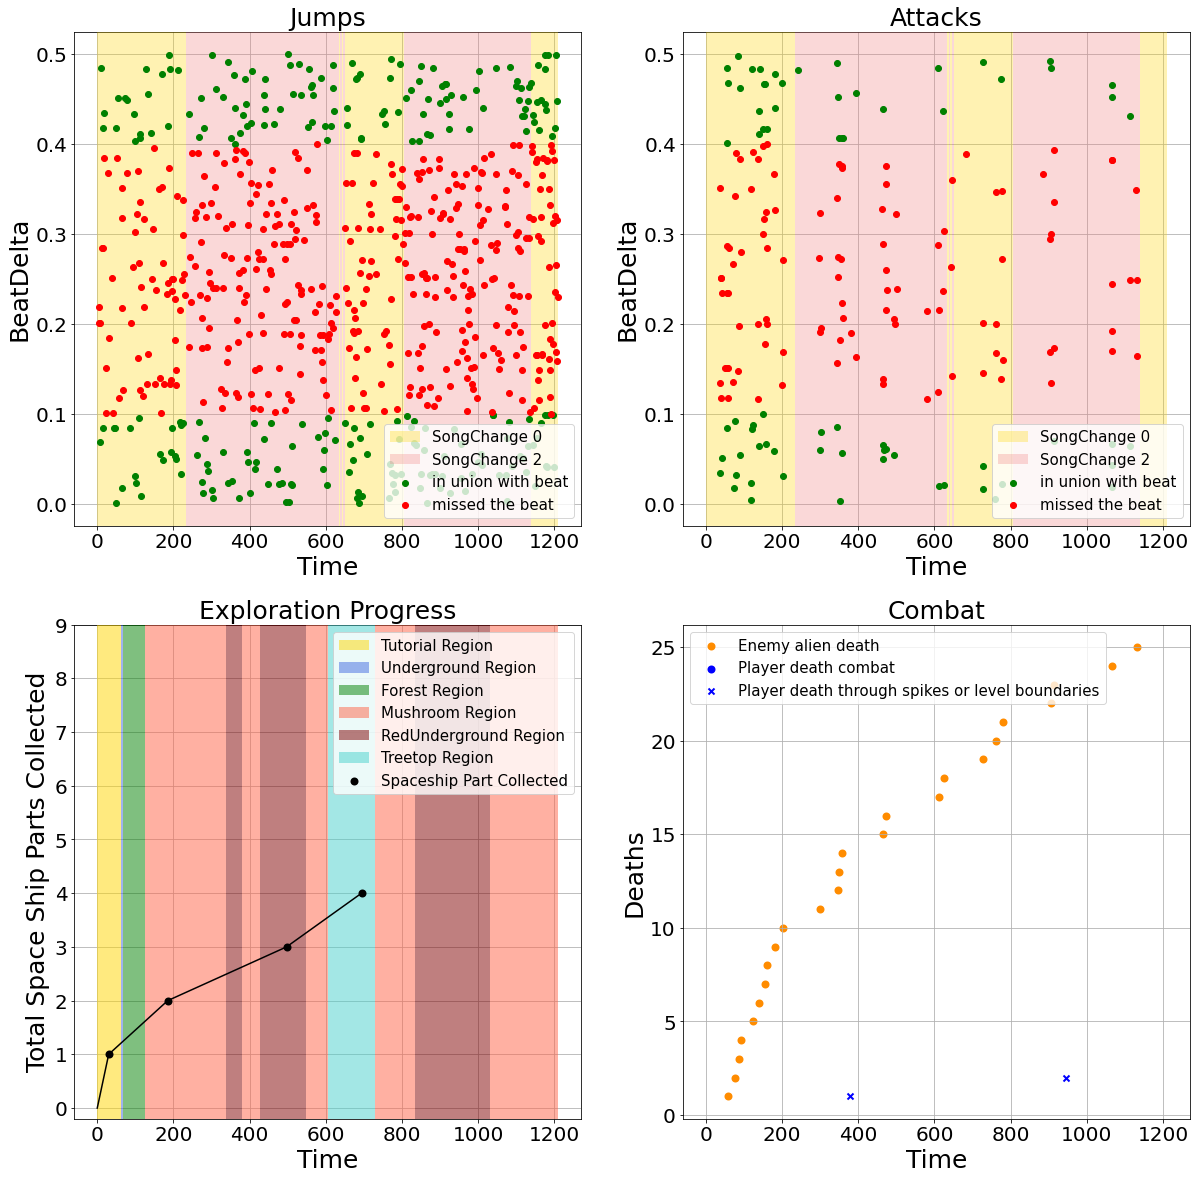

061295_RhythmControlled_05_12_21_05_53_Beat_Metric.csv 061295_RhythmControlled_05_12_21_05_53_Various_Metric.csv 061295_RhythmControlled_05_12_21_05_53_Combat_Metric.csv
              Version  Time                                       Action
0    RhythmControlled    34                             Keyboard & Mouse
1    RhythmControlled     0                                      Gamepad
2    RhythmControlled     0                                  Fixing sync
3    RhythmControlled     0                                 SongChange 0
4    RhythmControlled     1                   Region jump tutorial start
..                ...   ...                                          ...
153  RhythmControlled  1124       Checkpoint Activated Checkpoint forest
154  RhythmControlled  1131                      Region 2nd forest start
156  RhythmControlled  1133                   Region underground entry 2
158  RhythmControlled  1184  Checkpoint Activated Checkpoint underground
159  RhythmControlled  1194

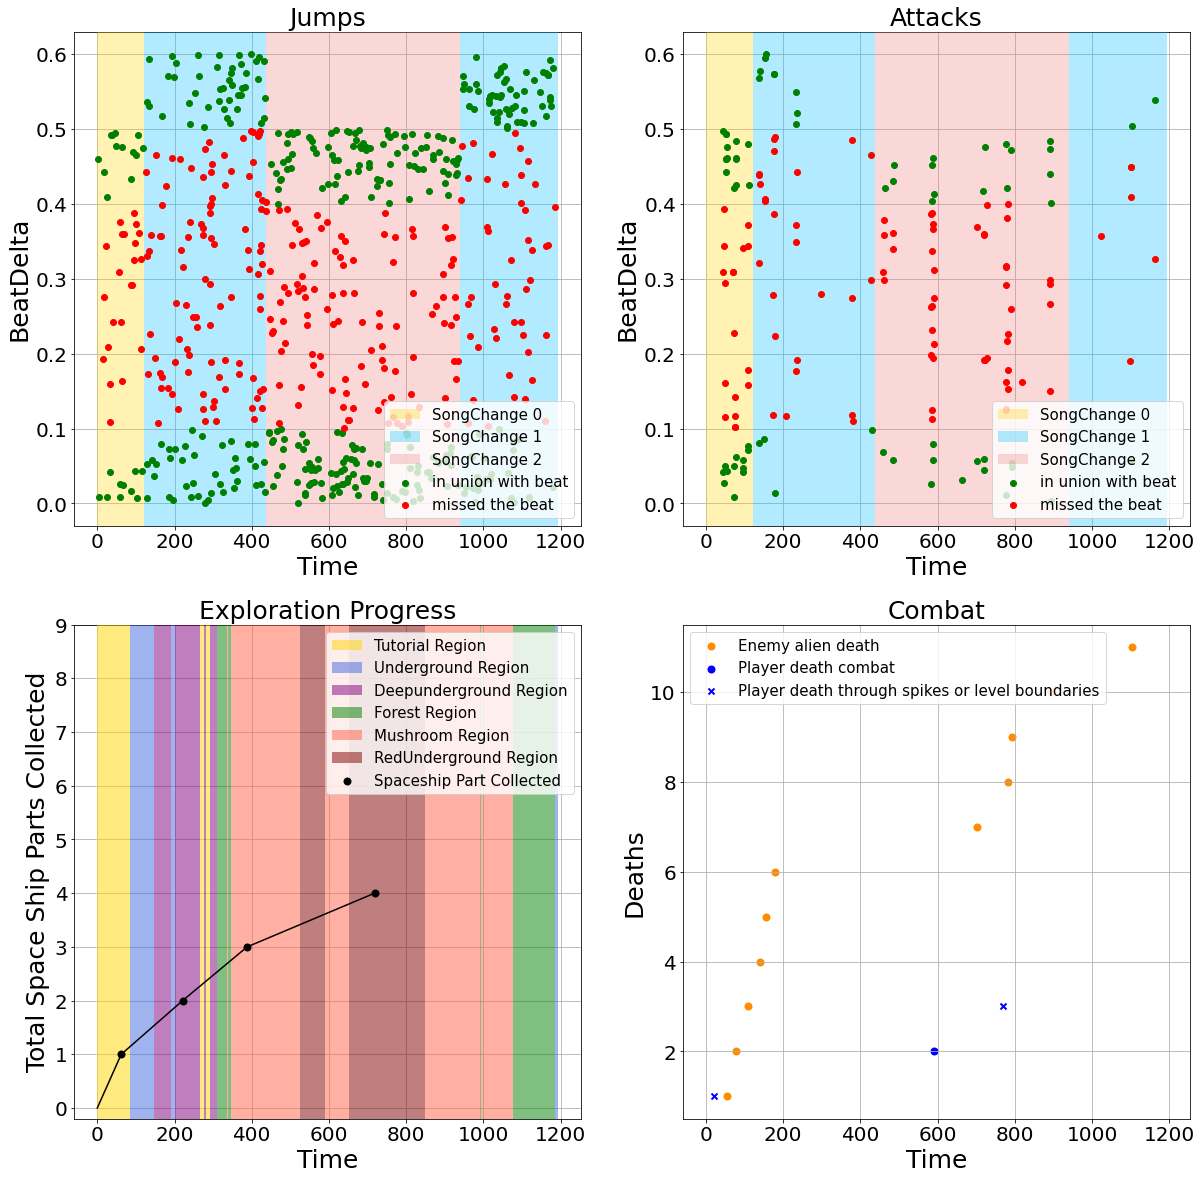

088835_NoRhythm_21_11_21_05_42_Beat_Metric.csv 088835_NoRhythm_21_11_21_05_42_Various_Metric.csv 088835_NoRhythm_21_11_21_05_42_Combat_Metric.csv
      Version  Time                                    Action
0    NoRhythm     0                              SongChange 0
1    NoRhythm     8                Region jump tutorial start
3    NoRhythm    24                  Region jump tutorial end
5    NoRhythm    25  Checkpoint Activated Checkpoint tutorial
6    NoRhythm    43                   Region first boss fight
..        ...   ...                                       ...
153  NoRhythm  1037    Checkpoint Activated Checkpoint spider
154  NoRhythm  1038    Checkpoint Activated Checkpoint spider
155  NoRhythm  1039    Checkpoint Activated Checkpoint spider
156  NoRhythm  1066                                  Game End
157  NoRhythm  1066           SpaceShip collected spider_boss

[97 rows x 3 columns]
Jumps hits: 281/695 = 40.43 %
Attacks hits: 281/695 = 40.43 %
time spent in songs: {'So

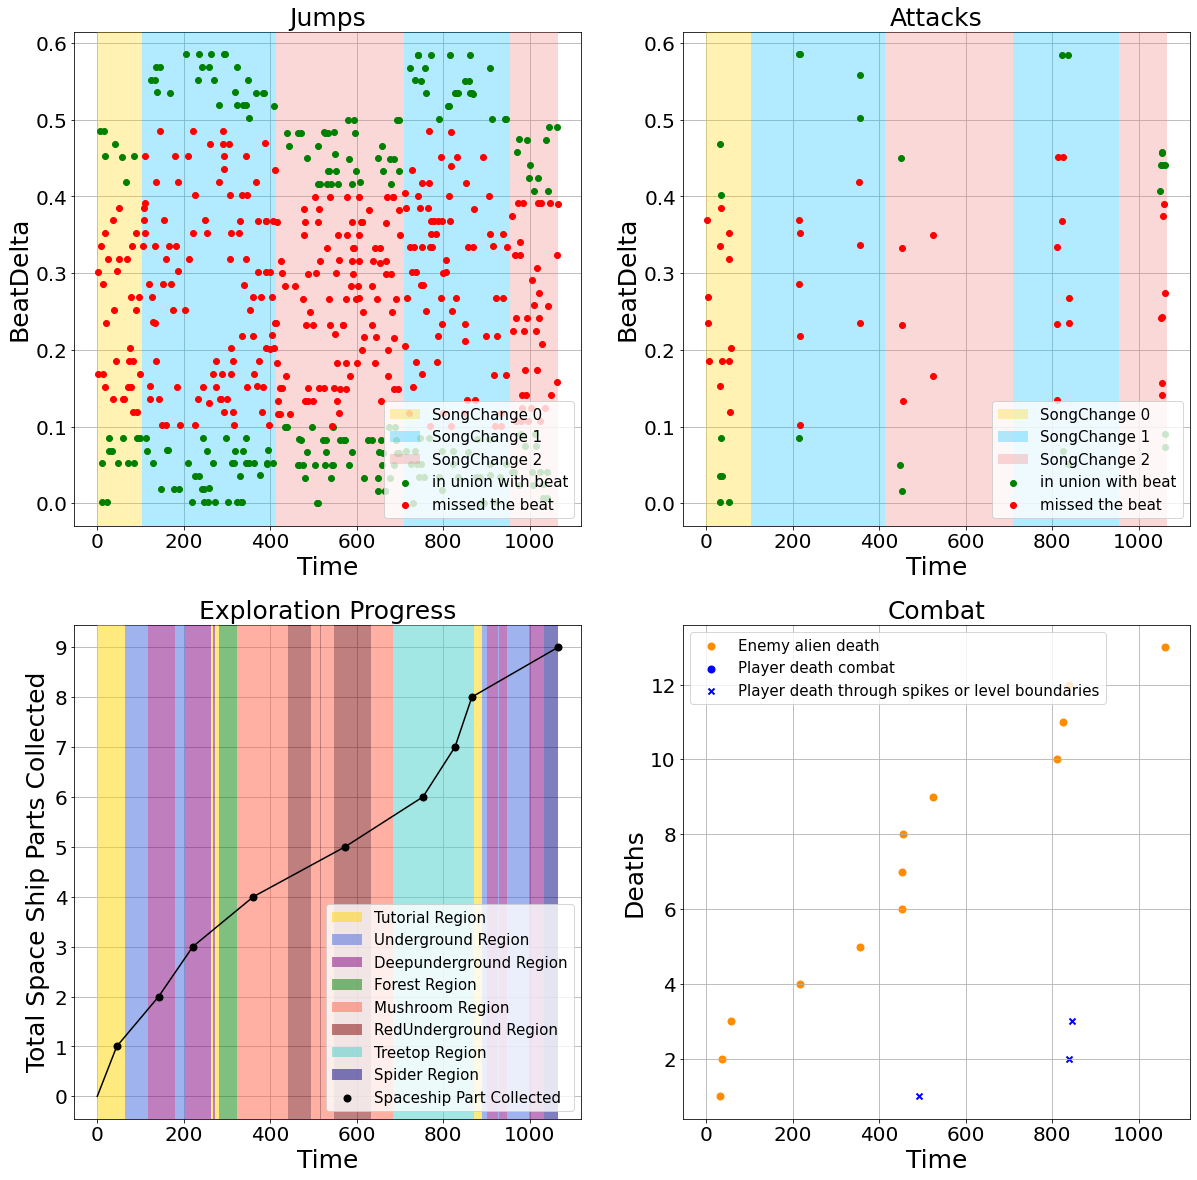

088835_RhythmControlled_21_11_21_05_13_Beat_Metric.csv 088835_RhythmControlled_21_11_21_05_13_Various_Metric.csv 088835_RhythmControlled_21_11_21_05_13_Combat_Metric.csv
              Version  Time                                        Action
0    RhythmControlled     0                                   Fixing sync
1    RhythmControlled     0                                  SongChange 0
2    RhythmControlled     5                    Region jump tutorial start
4    RhythmControlled    44                      Region jump tutorial end
6    RhythmControlled    46                      Region jump tutorial end
..                ...   ...                                           ...
123  RhythmControlled  1109  Region treetop lower platform after songtree
125  RhythmControlled  1154                                  player death
126  RhythmControlled  1162                       Region treetop songtree
128  RhythmControlled  1173  Region treetop lower platform after songtree
130  RhythmContr

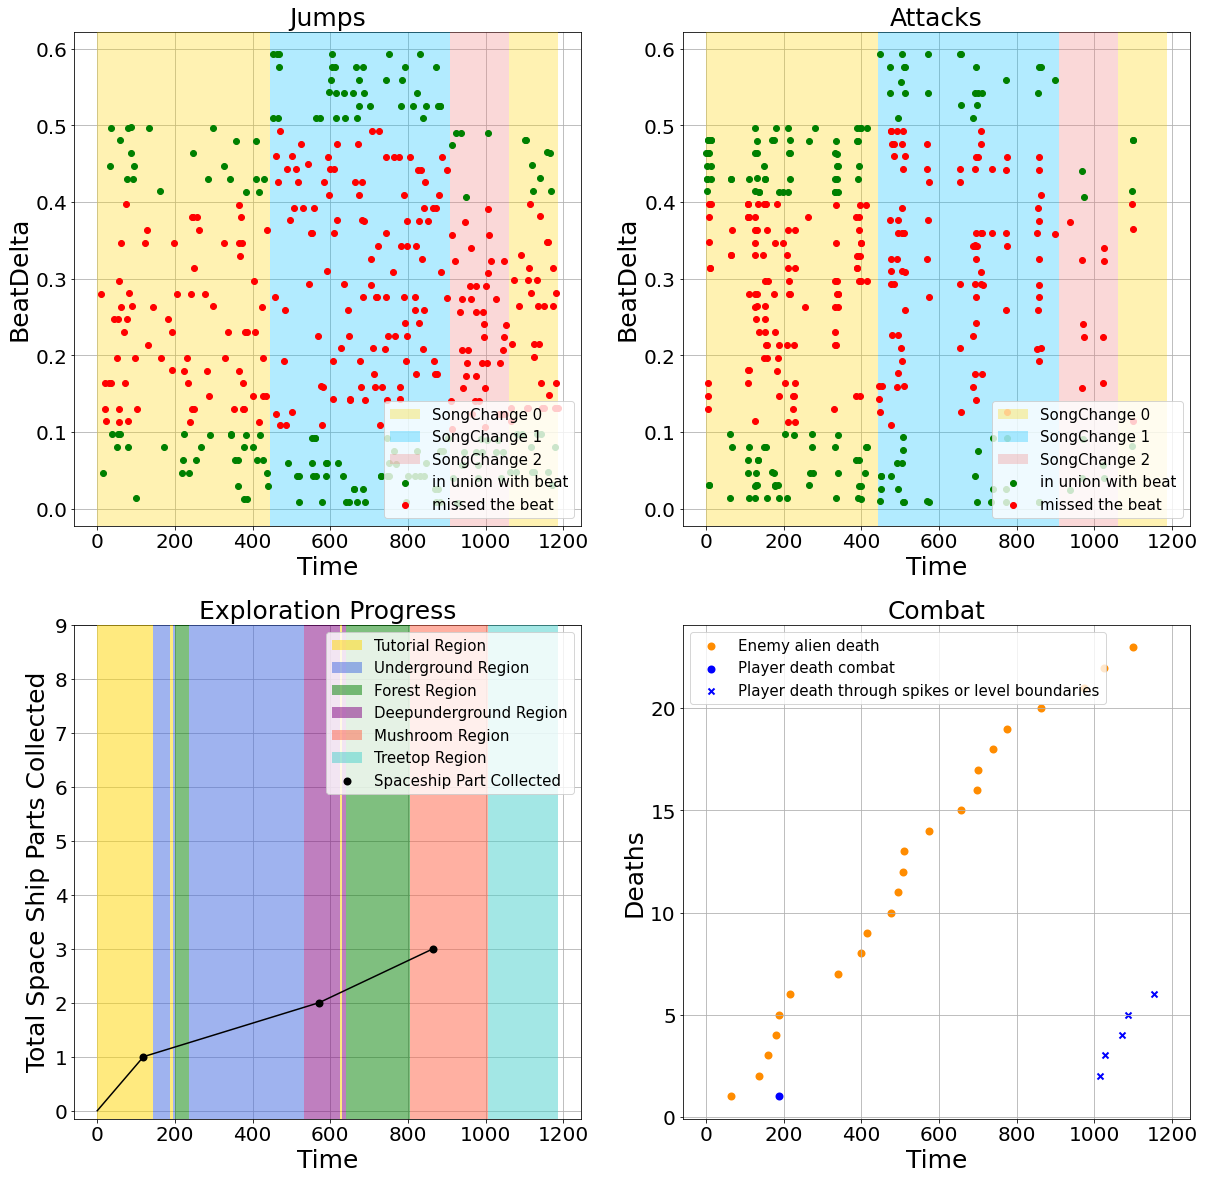

157771_NoRhythm_02_12_21_06_04_Beat_Metric.csv 157771_NoRhythm_02_12_21_06_04_Various_Metric.csv 157771_NoRhythm_02_12_21_06_04_Combat_Metric.csv
      Version  Time                                             Action
0    NoRhythm    20                                   Keyboard & Mouse
1    NoRhythm     0                                            Gamepad
2    NoRhythm     0                                       SongChange 0
3    NoRhythm     3                         Region jump tutorial start
5    NoRhythm    21                           Region jump tutorial end
..        ...   ...                                                ...
126  NoRhythm  1159            Region red underground bossplatform end
128  NoRhythm  1165    Checkpoint Activated Checkpoint underground red
129  NoRhythm  1176  Region red underground get over spikes jump ri...
131  NoRhythm  1187                                       player death
132  NoRhythm  1191    Checkpoint Activated Checkpoint underground red

[

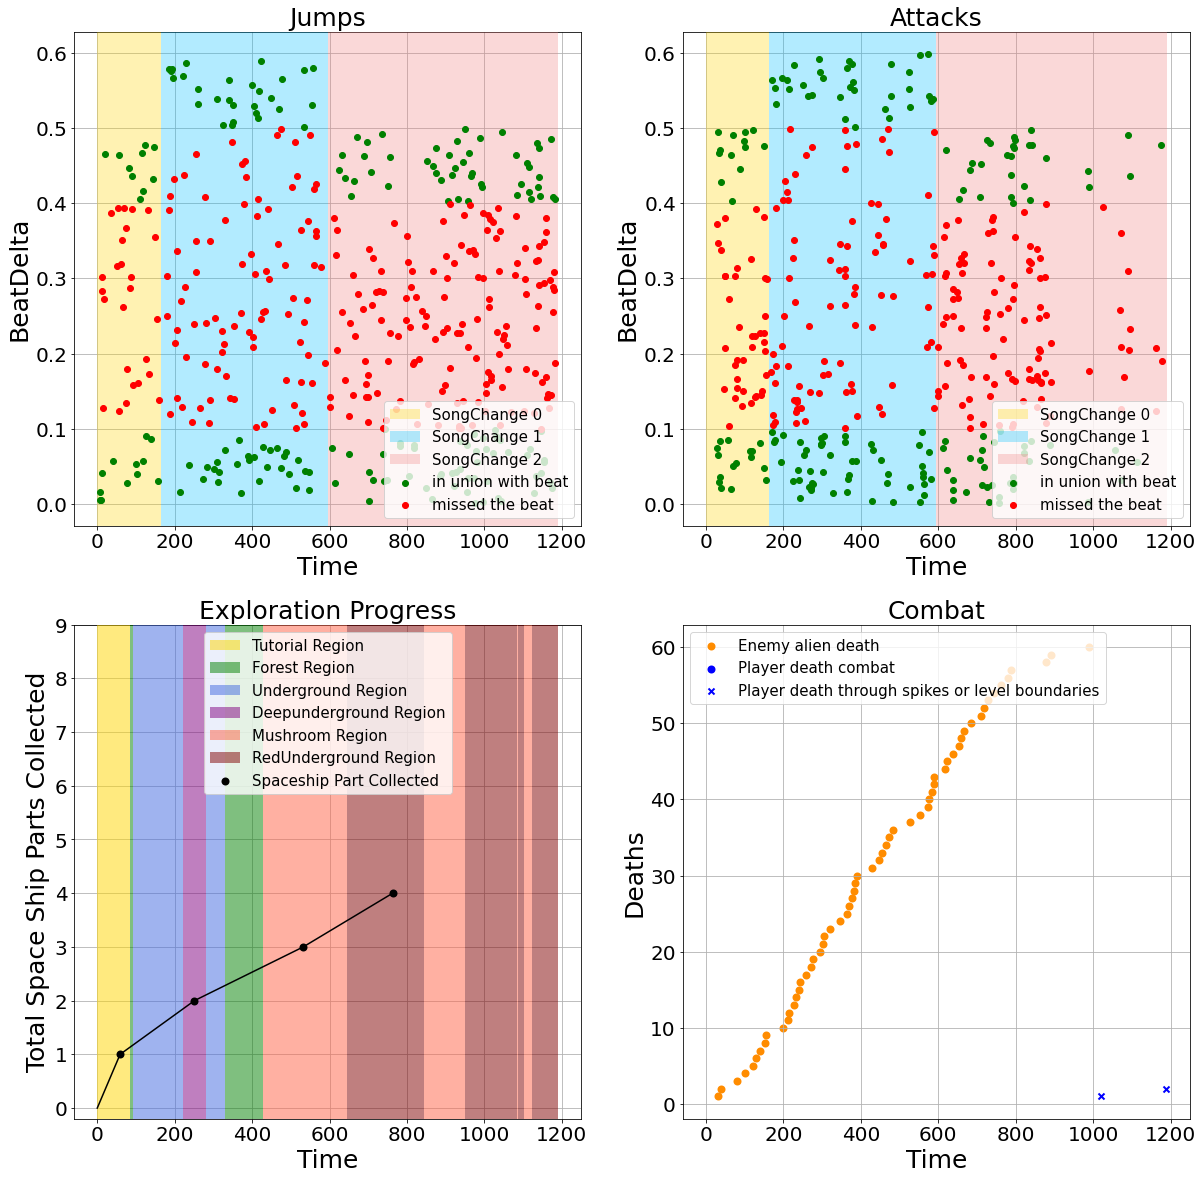

157771_RhythmControlled_02_12_21_06_35_Beat_Metric.csv 157771_RhythmControlled_02_12_21_06_35_Various_Metric.csv 157771_RhythmControlled_02_12_21_06_35_Combat_Metric.csv
             Version  Time                                       Action
0   RhythmControlled    31                             Keyboard & Mouse
1   RhythmControlled     0                                      Gamepad
2   RhythmControlled     0                                  Fixing sync
3   RhythmControlled     0                                 SongChange 0
4   RhythmControlled     4                   Region jump tutorial start
6   RhythmControlled    20                     Region jump tutorial end
8   RhythmControlled    22     Checkpoint Activated Checkpoint tutorial
9   RhythmControlled    47                 SpaceShip collected tutorial
10  RhythmControlled    49                      Region first boss fight
12  RhythmControlled    76                      Region first boss fight
14  RhythmControlled    77            

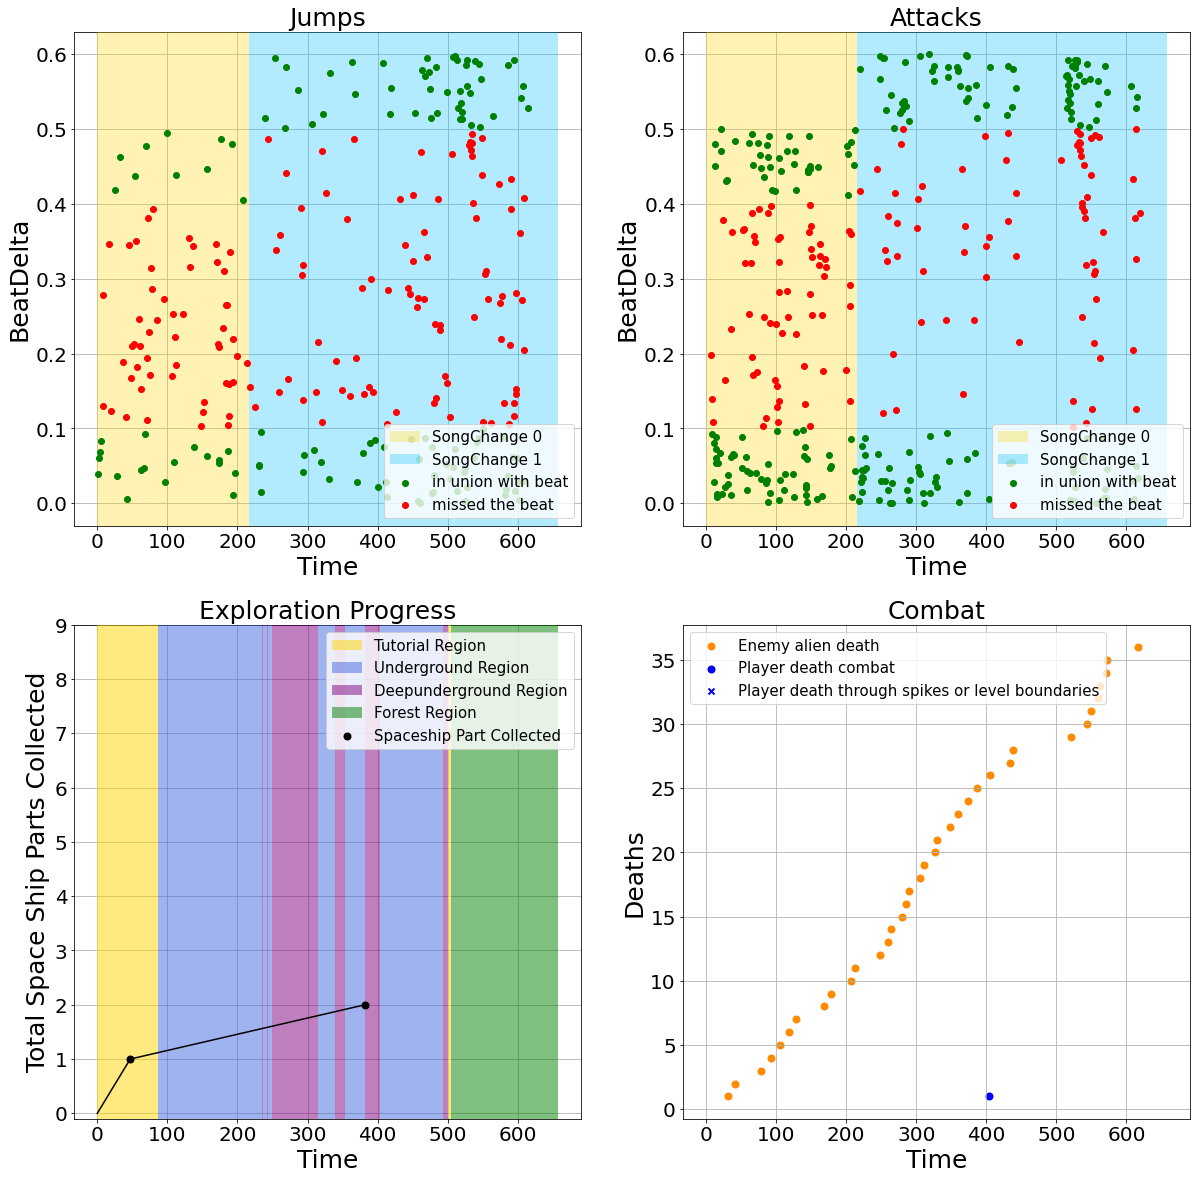

198760_NoRhythm_06_12_21_06_35_Beat_Metric.csv 198760_NoRhythm_06_12_21_06_35_Various_Metric.csv 198760_NoRhythm_06_12_21_06_35_Combat_Metric.csv
      Version  Time                           Action
0    NoRhythm    35                 Keyboard & Mouse
1    NoRhythm     0                          Gamepad
2    NoRhythm     0                     SongChange 0
3    NoRhythm     8       Region jump tutorial start
7    NoRhythm    63         Region jump tutorial end
..        ...   ...                              ...
159  NoRhythm  1175       Region underground entry 1
161  NoRhythm  1177       Region underground entry 1
163  NoRhythm  1188  Region deep underground entry 3
165  NoRhythm  1205                 Keyboard & Mouse
166  NoRhythm  1205                          Gamepad

[104 rows x 3 columns]
Jumps hits: 329/940 = 35.0 %
Attacks hits: 329/940 = 35.0 %
time spent in songs: {'SongChange 0': 248, 'SongChange 1': 824, 'SongChange 2': 133}
space ship parts collected: 7/9 = 77.78 %
unique 

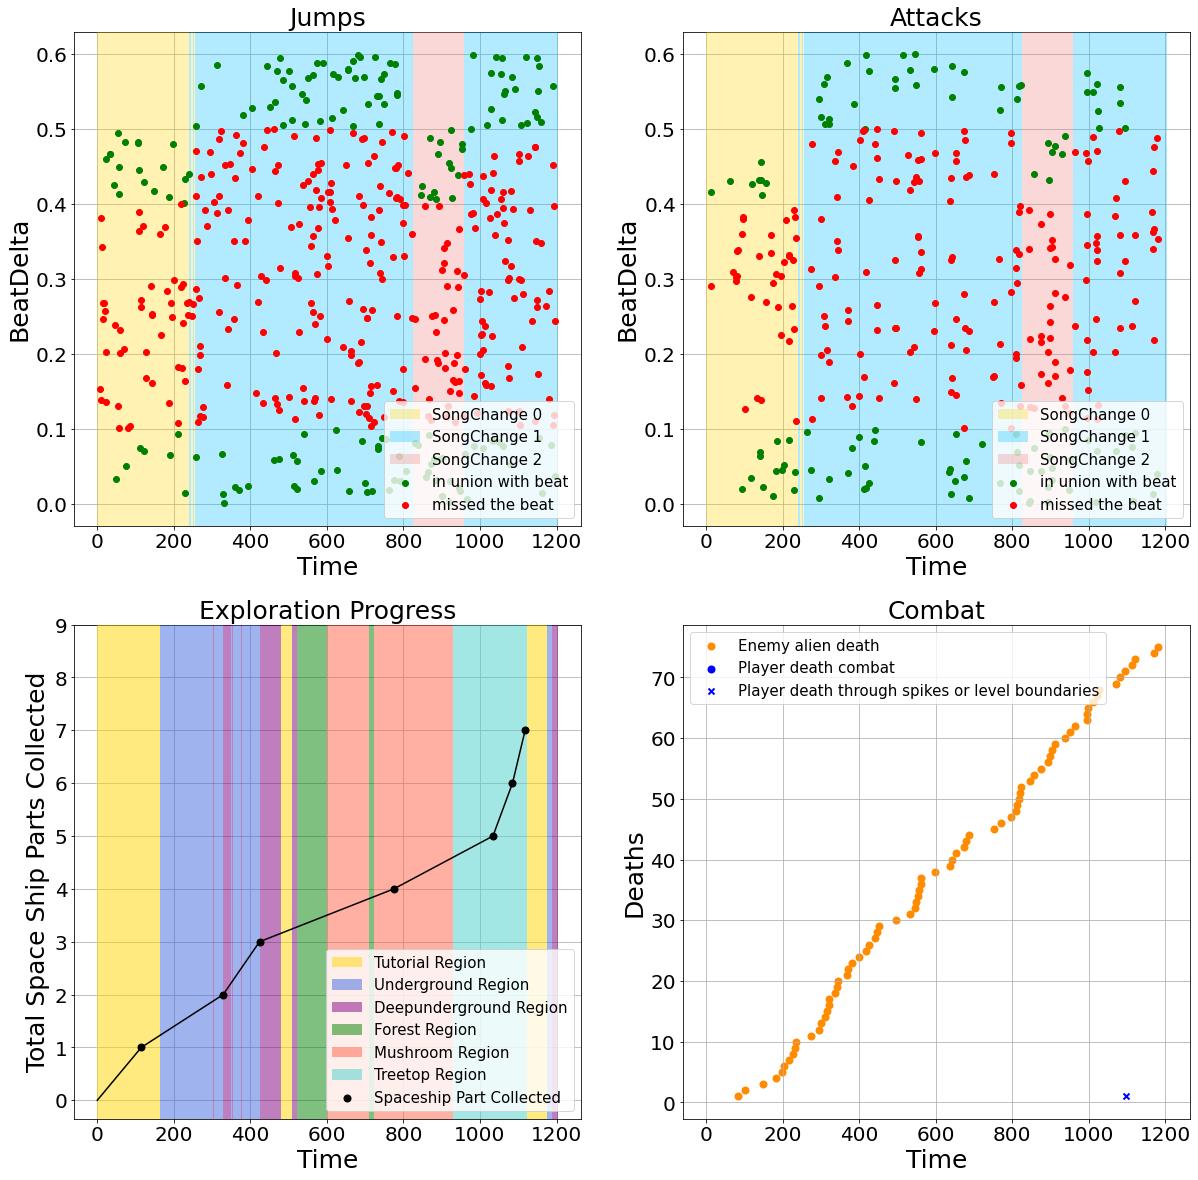

198760_RhythmControlled_06_12_21_07_06_Beat_Metric.csv 198760_RhythmControlled_06_12_21_07_06_Various_Metric.csv 198760_RhythmControlled_06_12_21_07_06_Combat_Metric.csv
              Version  Time                                    Action
0    RhythmControlled    19                          Keyboard & Mouse
1    RhythmControlled     0                               Fixing sync
2    RhythmControlled     0                              SongChange 0
3    RhythmControlled     1                                   Gamepad
4    RhythmControlled     1                Region jump tutorial start
..                ...   ...                                       ...
170  RhythmControlled  1112  Checkpoint Activated Checkpoint treetop1
172  RhythmControlled  1118             Region treetop mushroom entry
174  RhythmControlled  1128                          Keyboard & Mouse
175  RhythmControlled  1128                               Fixing sync
176  RhythmControlled  1128                                 

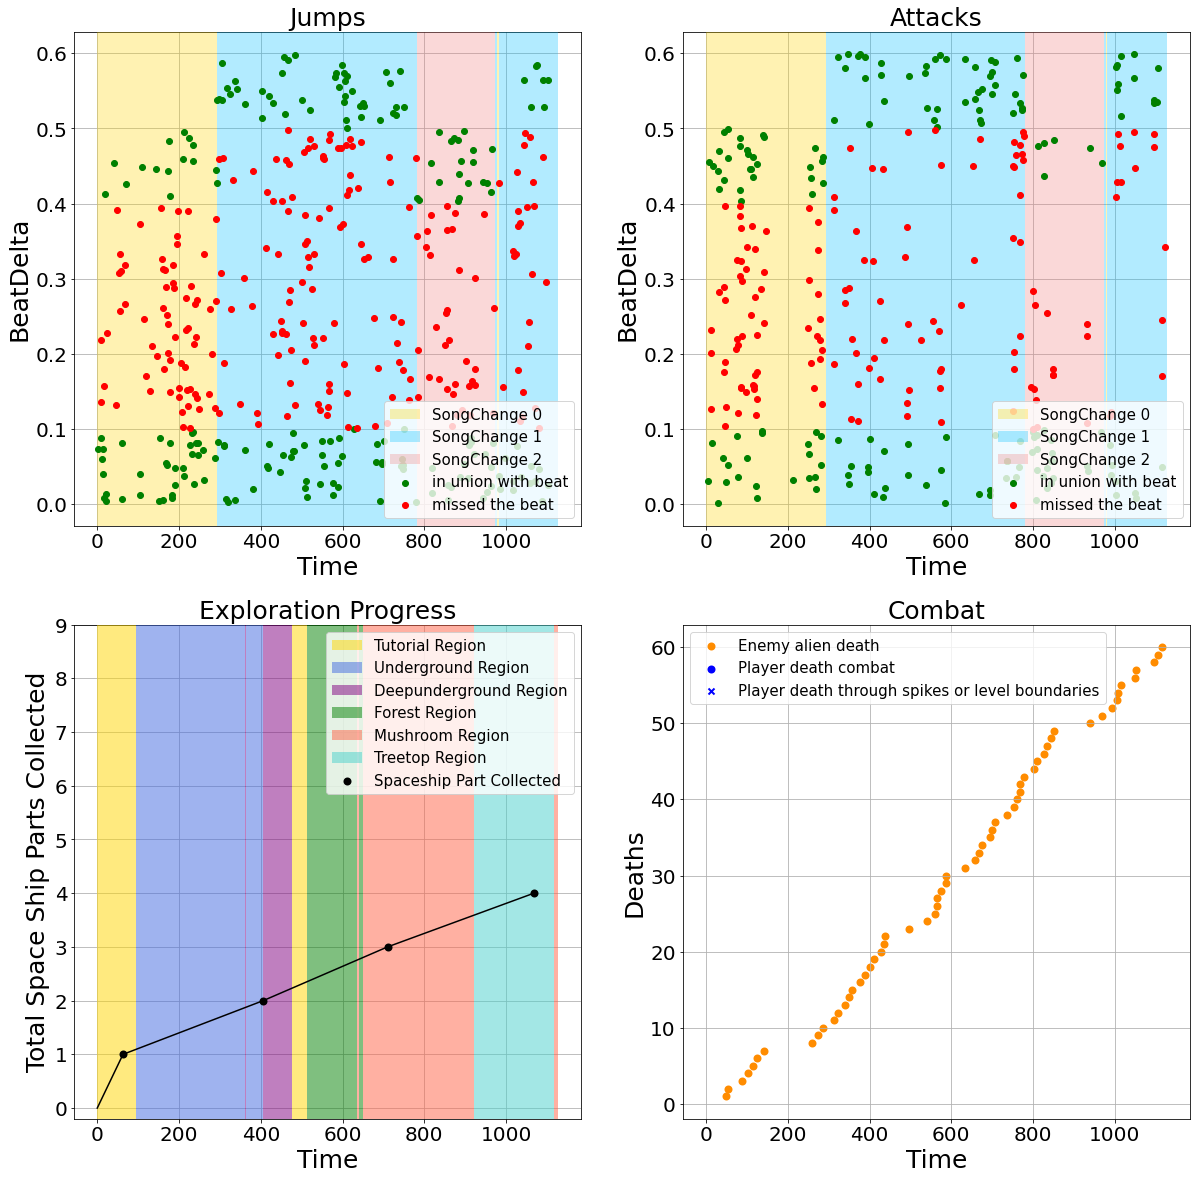

244206_NoRhythm_03_12_21_03_22_Beat_Metric.csv 244206_NoRhythm_03_12_21_03_22_Various_Metric.csv 244206_NoRhythm_03_12_21_03_22_Combat_Metric.csv
      Version  Time                                  Action
0    NoRhythm    11                        Keyboard & Mouse
1    NoRhythm     0                            SongChange 0
2    NoRhythm     1                                 Gamepad
3    NoRhythm     1              Region jump tutorial start
5    NoRhythm    28                Region jump tutorial end
..        ...   ...                                     ...
174  NoRhythm  1163              Region underground entry 2
176  NoRhythm  1185                      Region Spider nest
178  NoRhythm  1188  Checkpoint Activated Checkpoint spider
179  NoRhythm  1203         SpaceShip collected spider_boss
180  NoRhythm  1206                        Keyboard & Mouse

[109 rows x 3 columns]
Jumps hits: 332/813 = 40.84 %
Attacks hits: 332/813 = 40.84 %
time spent in songs: {'SongChange 0': 197, 'Song

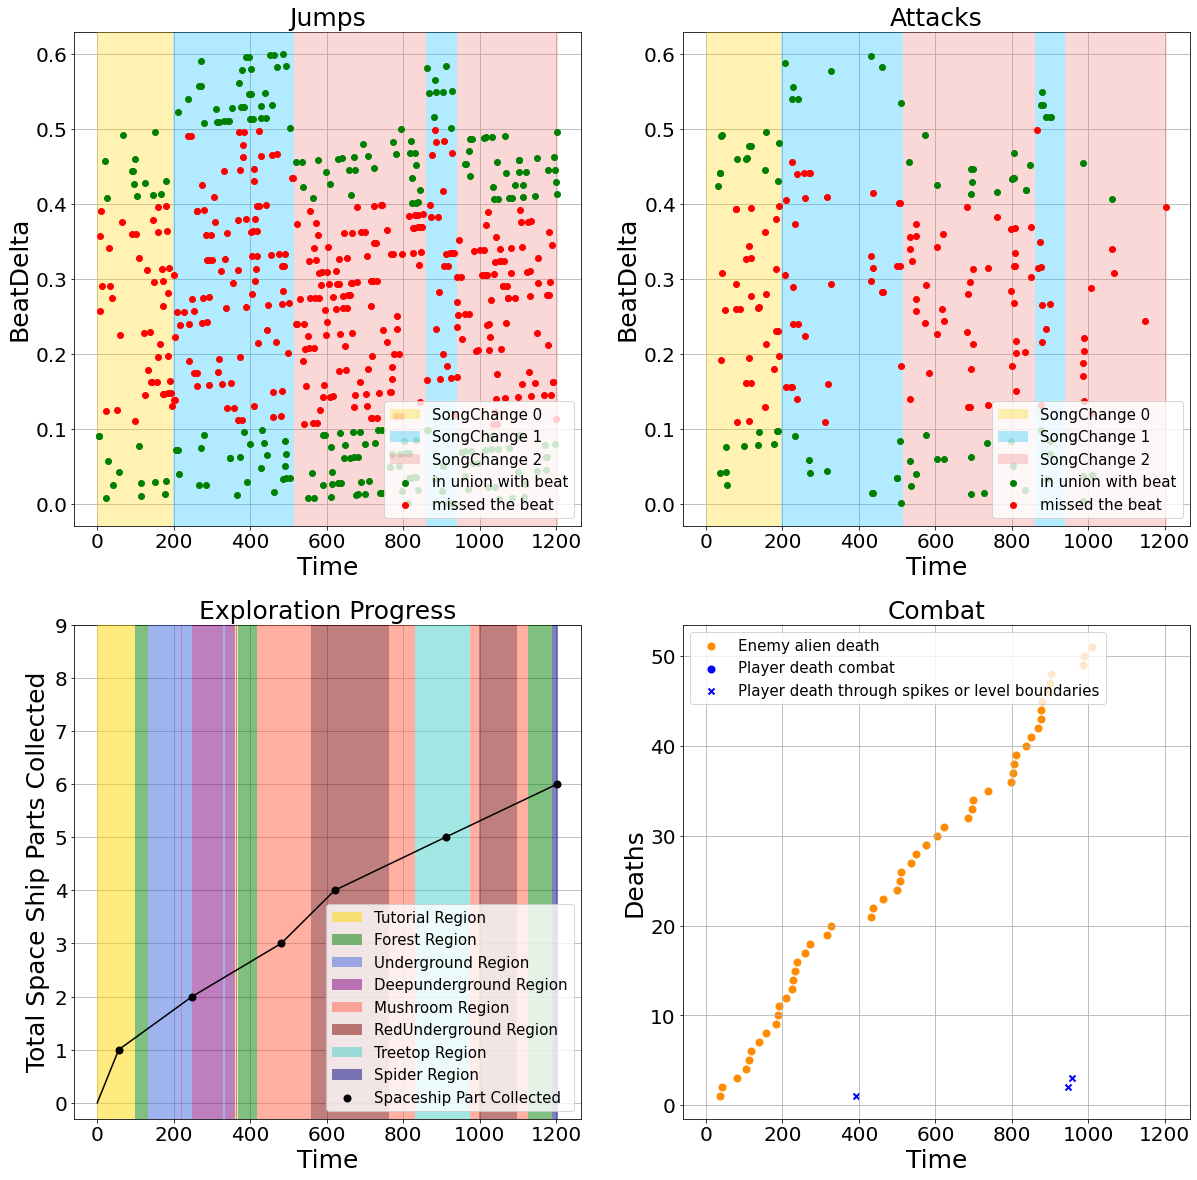

244206_RhythmControlled_03_12_21_03_50_Beat_Metric.csv 244206_RhythmControlled_03_12_21_03_50_Various_Metric.csv 244206_RhythmControlled_03_12_21_03_50_Combat_Metric.csv
              Version  Time                                    Action
0    RhythmControlled    11                          Keyboard & Mouse
1    RhythmControlled     0                              SongChange 0
2    RhythmControlled     0                                   Gamepad
3    RhythmControlled     1                Region jump tutorial start
5    RhythmControlled    21                  Region jump tutorial end
..                ...   ...                                       ...
152  RhythmControlled  1159  Checkpoint Activated Checkpoint treetop1
153  RhythmControlled  1167                              player death
154  RhythmControlled  1168                 Region 2nd forest spire 2
156  RhythmControlled  1170                          Keyboard & Mouse
157  RhythmControlled  1170                               Fi

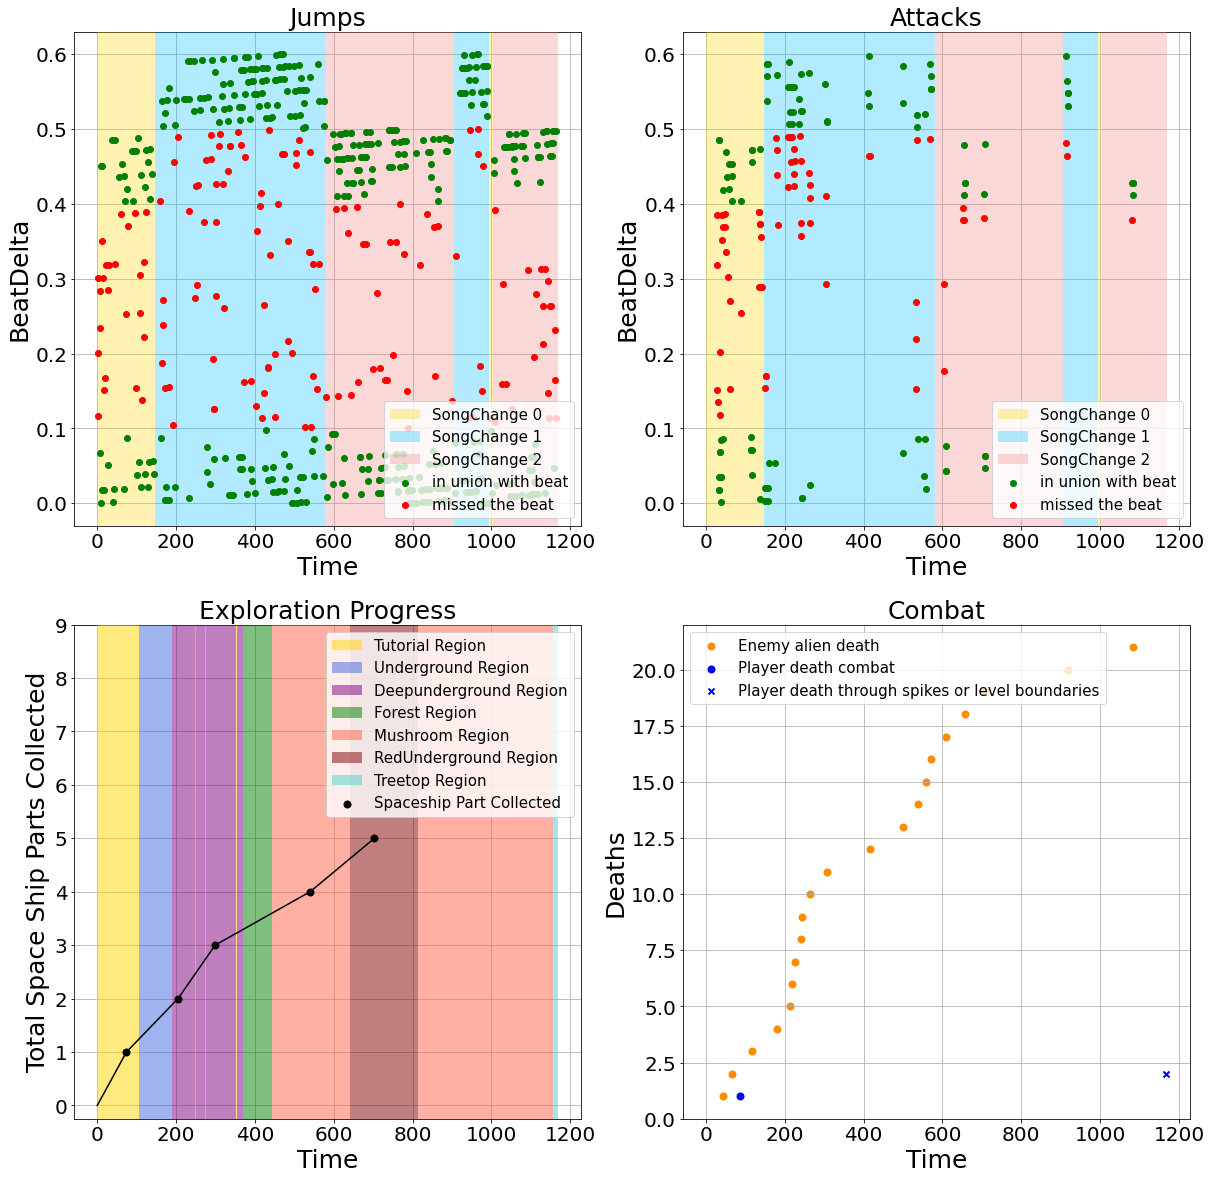

246229_NoRhythm_02_12_21_04_03_Beat_Metric.csv 246229_NoRhythm_02_12_21_04_03_Various_Metric.csv 246229_NoRhythm_02_12_21_04_03_Combat_Metric.csv
      Version  Time                                      Action
0    NoRhythm    12                            Keyboard & Mouse
1    NoRhythm     0                                SongChange 0
2    NoRhythm     1                  Region jump tutorial start
4    NoRhythm    27                    Region jump tutorial end
6    NoRhythm    30    Checkpoint Activated Checkpoint tutorial
..        ...   ...                                         ...
114  NoRhythm  1002  Checkpoint Activated Song_Tree undergorund
115  NoRhythm  1004                                SongChange 2
116  NoRhythm  1020           Region underground songtree entry
118  NoRhythm  1035             Region deep underground entry 3
120  NoRhythm  1058            SpaceShip collected underground2

[78 rows x 3 columns]
Jumps hits: 306/752 = 40.69 %
Attacks hits: 306/752 = 40.69 %
t

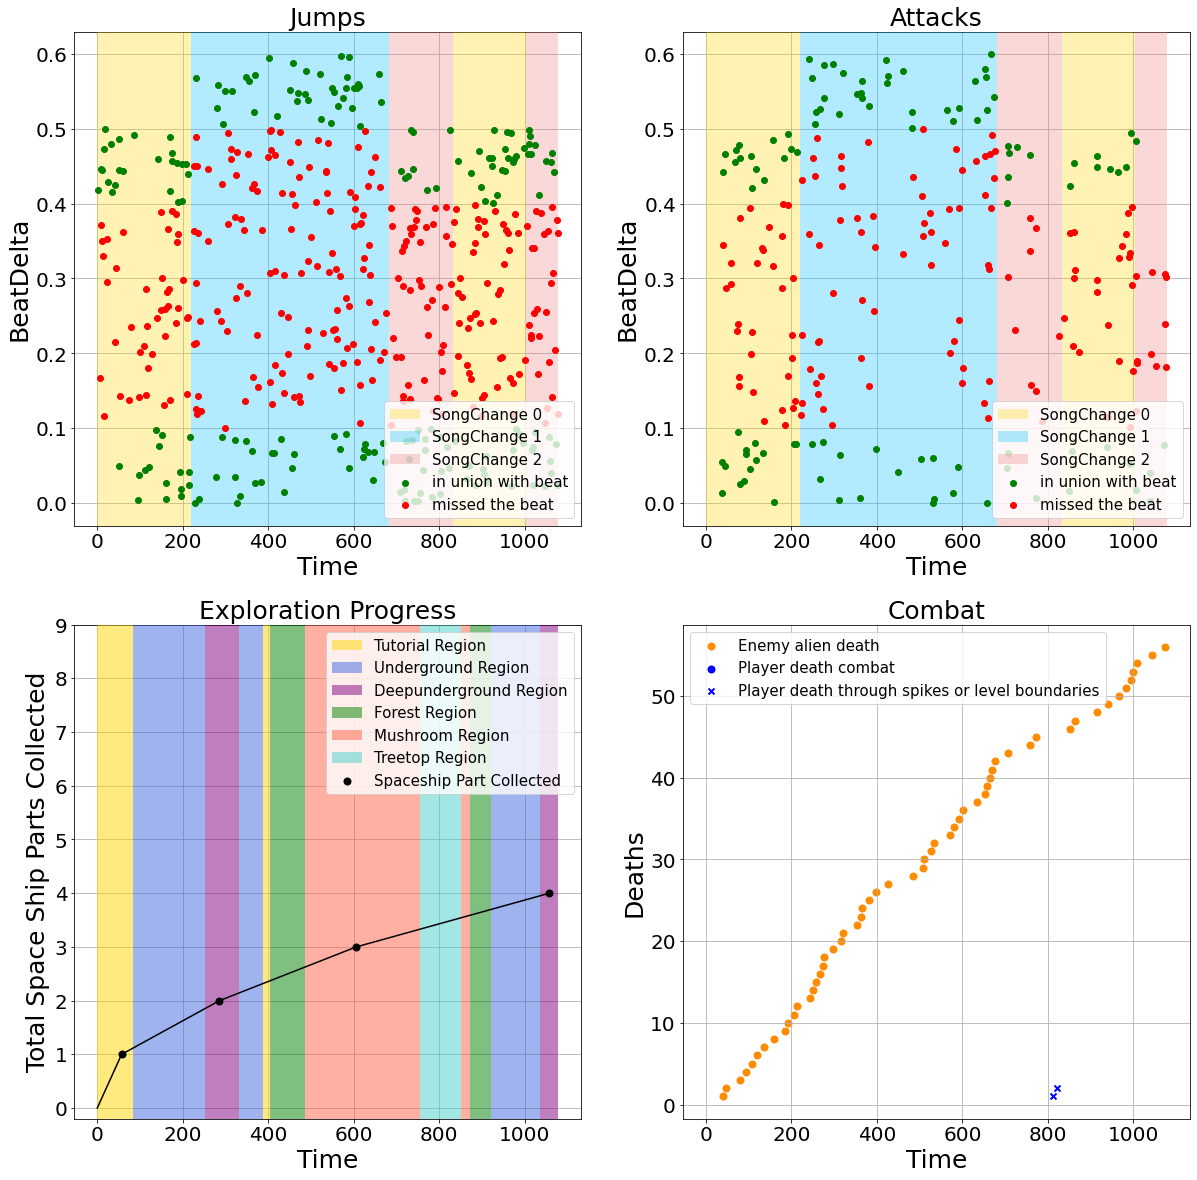

246229_RhythmControlled_02_12_21_04_30_Beat_Metric.csv 246229_RhythmControlled_02_12_21_04_30_Various_Metric.csv 246229_RhythmControlled_02_12_21_04_30_Combat_Metric.csv
              Version  Time                                             Action
0    RhythmControlled    11                                   Keyboard & Mouse
1    RhythmControlled     0                                        Fixing sync
2    RhythmControlled     0                                       SongChange 0
3    RhythmControlled     1                         Region jump tutorial start
5    RhythmControlled    15                           Region jump tutorial end
..                ...   ...                                                ...
147  RhythmControlled  1137    Checkpoint Activated Checkpoint underground red
148  RhythmControlled  1150             SpaceShip collected second_underground
149  RhythmControlled  1172  Region red underground get over spikes jump ri...
151  RhythmControlled  1186             

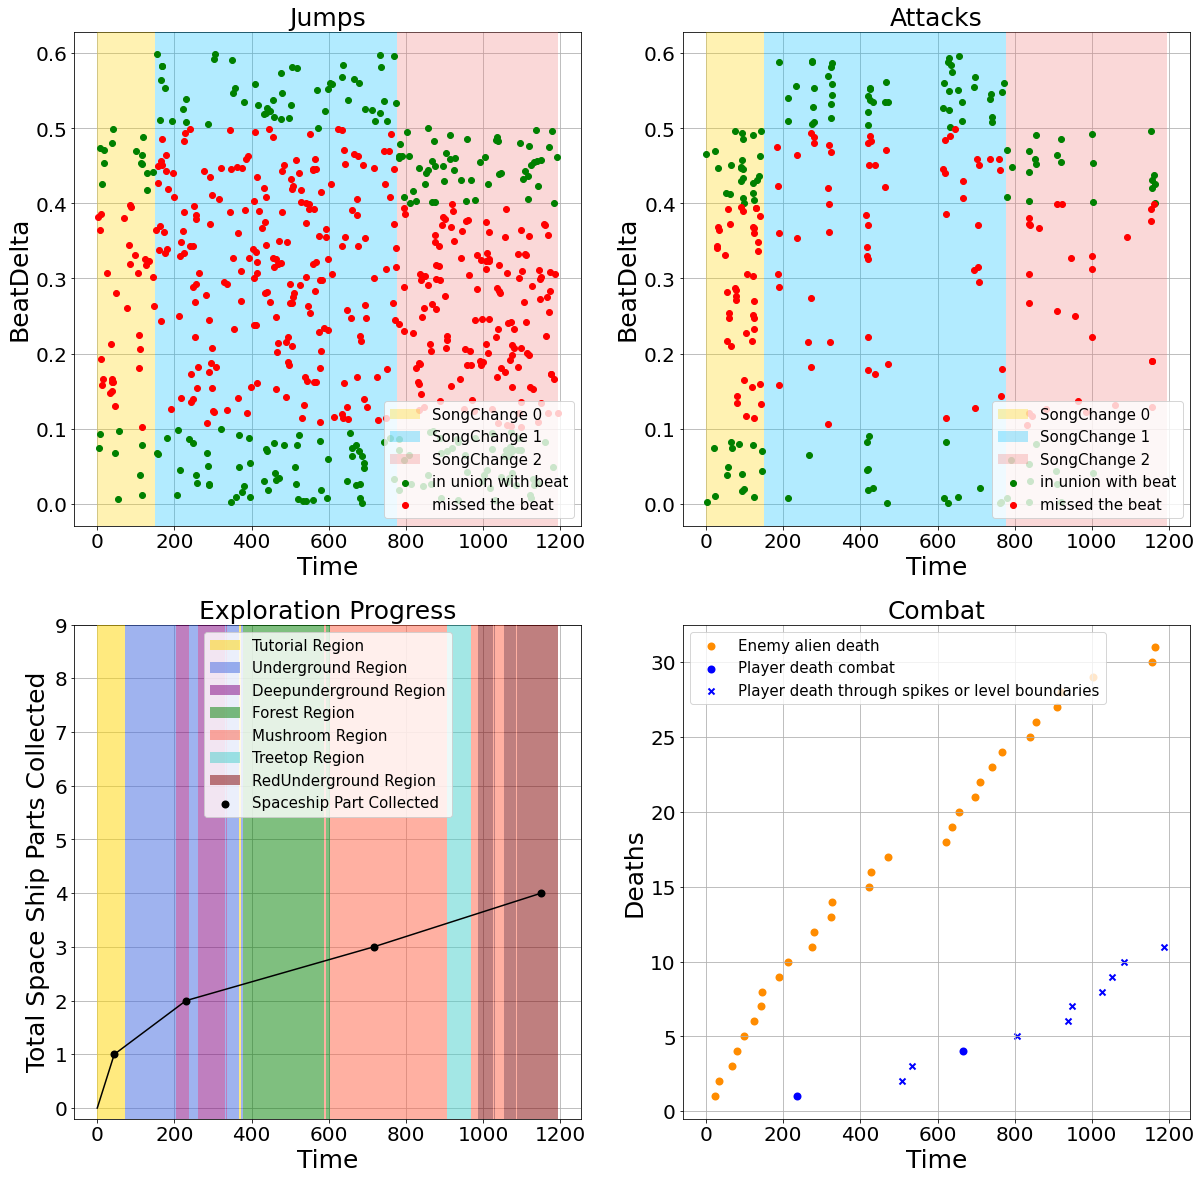

288786_NoRhythm_05_12_21_04_49_Beat_Metric.csv 288786_NoRhythm_05_12_21_04_49_Various_Metric.csv 288786_NoRhythm_05_12_21_04_49_Combat_Metric.csv
      Version  Time                                    Action
0    NoRhythm    12                          Keyboard & Mouse
1    NoRhythm     0                              SongChange 0
2    NoRhythm     3                Region jump tutorial start
4    NoRhythm    13                  Region jump tutorial end
6    NoRhythm    15  Checkpoint Activated Checkpoint tutorial
..        ...   ...                                       ...
218  NoRhythm  1133                              SongChange 1
219  NoRhythm  1142         Region underground songtree entry
221  NoRhythm  1157           Region deep underground entry 3
223  NoRhythm  1160           Region deep underground entry 3
225  NoRhythm  1164           Region deep underground entry 3

[139 rows x 3 columns]
Jumps hits: 281/785 = 35.8 %
Attacks hits: 281/785 = 35.8 %
time spent in songs: {'Son

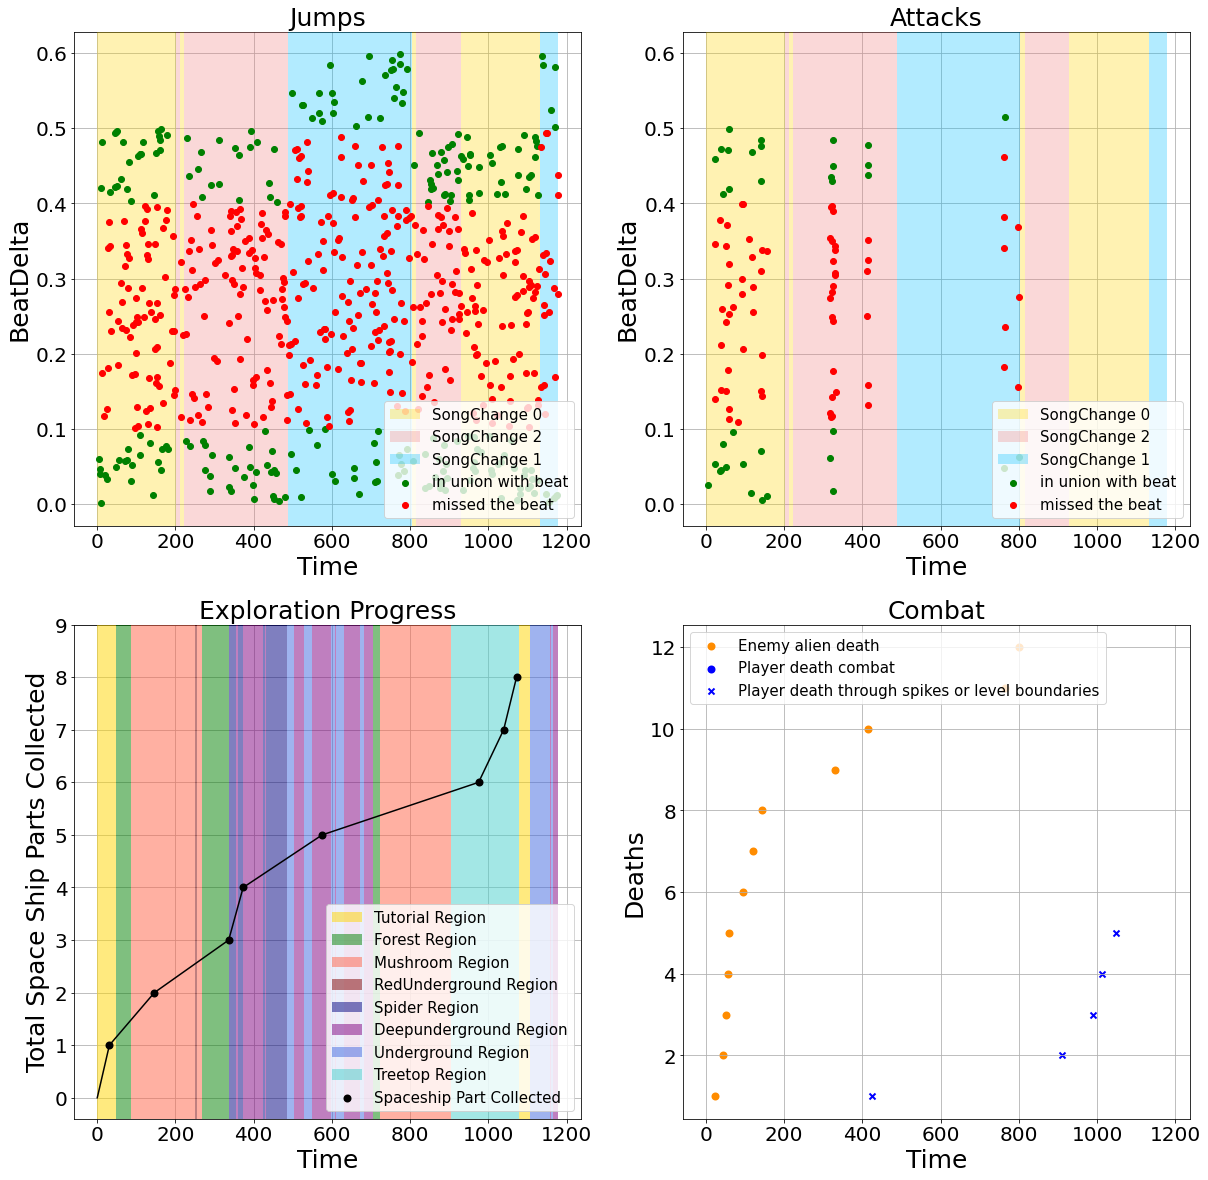

288786_RhythmControlled_05_12_21_04_21_Beat_Metric.csv 288786_RhythmControlled_05_12_21_04_21_Various_Metric.csv 288786_RhythmControlled_05_12_21_04_21_Combat_Metric.csv
              Version  Time                                        Action
0    RhythmControlled    13                              Keyboard & Mouse
1    RhythmControlled     0                                  SongChange 0
2    RhythmControlled     4                                   Fixing sync
3    RhythmControlled    10                    Region jump tutorial start
5    RhythmControlled    31                      Region jump tutorial end
..                ...   ...                                           ...
167  RhythmControlled  1222                                  player death
168  RhythmControlled  1232                       Region treetop songtree
170  RhythmControlled  1242  Region treetop lower platform after songtree
172  RhythmControlled  1246                                  player death
173  RhythmContr

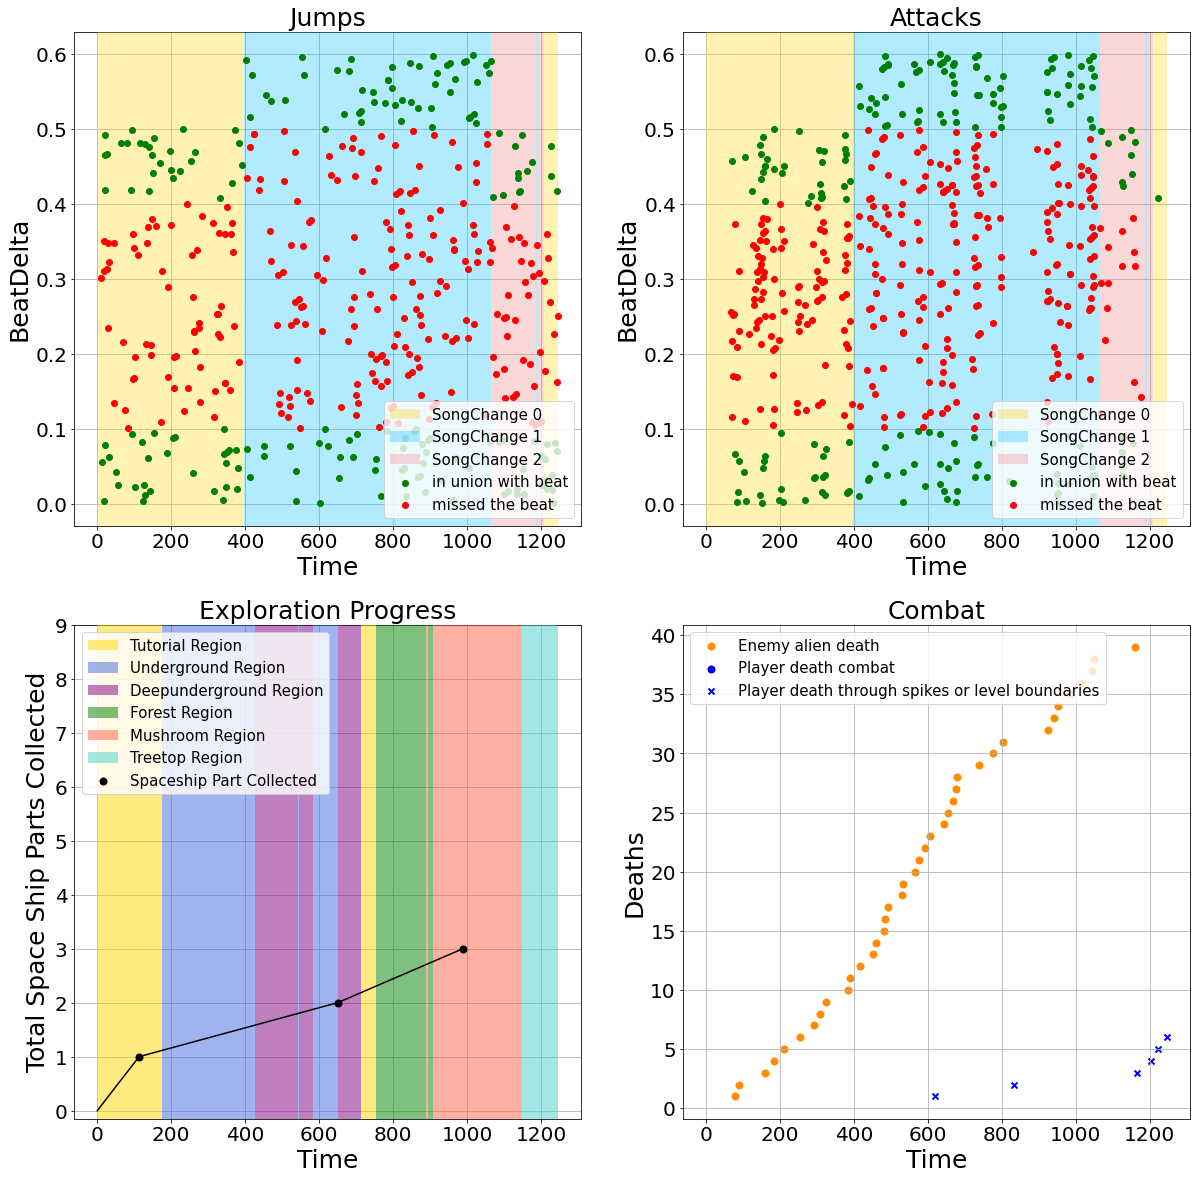

353252_NoRhythm_05_12_21_04_39_Beat_Metric.csv 353252_NoRhythm_05_12_21_04_39_Various_Metric.csv 353252_NoRhythm_05_12_21_04_39_Combat_Metric.csv
      Version  Time                                     Action
0    NoRhythm     8                           Keyboard & Mouse
1    NoRhythm     0                               SongChange 0
2    NoRhythm     0                                    Gamepad
3    NoRhythm     1                 Region jump tutorial start
5    NoRhythm     8                   Region jump tutorial end
..        ...   ...                                        ...
212  NoRhythm  1261             Region mushroom slime boss end
214  NoRhythm  1280             Region mushroom slime boss end
216  NoRhythm  1285           Region mushroom slime boss start
218  NoRhythm  1311  Checkpoint Activated Checkpoint mushroom1
219  NoRhythm  1312               Region red underground entry

[140 rows x 3 columns]
Jumps hits: 473/1195 = 39.58 %
Attacks hits: 473/1195 = 39.58 %
time spent

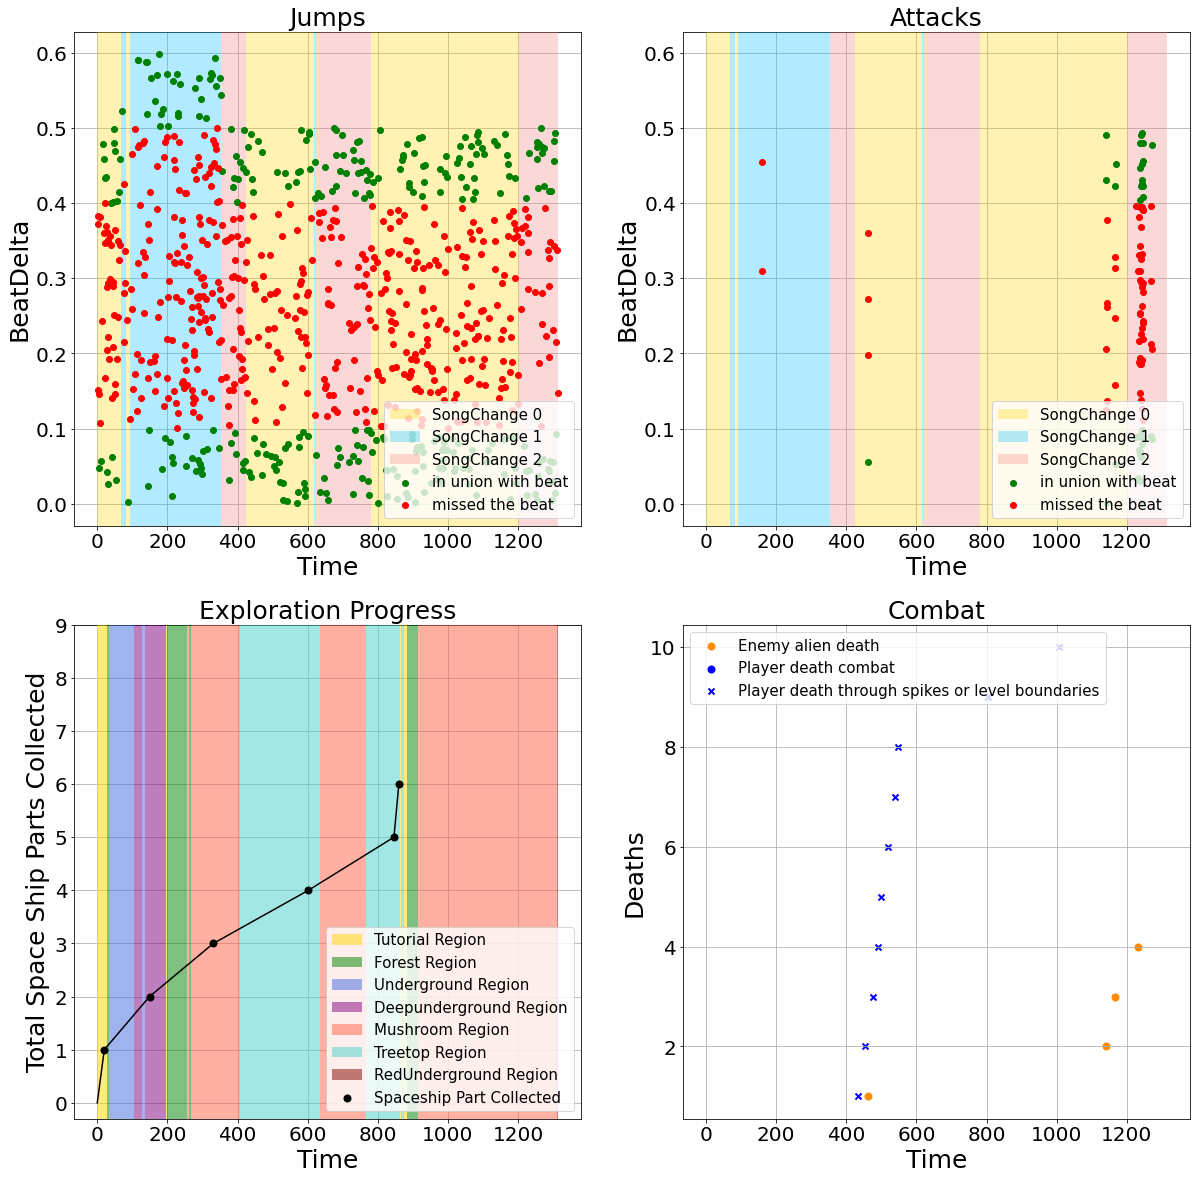

353252_RhythmControlled_05_12_21_04_13_Beat_Metric.csv 353252_RhythmControlled_05_12_21_04_13_Various_Metric.csv 353252_RhythmControlled_05_12_21_04_13_Combat_Metric.csv
              Version  Time                       Action
0    RhythmControlled    11             Keyboard & Mouse
1    RhythmControlled     0                      Gamepad
2    RhythmControlled     0                  Fixing sync
3    RhythmControlled     0                 SongChange 0
4    RhythmControlled     4   Region jump tutorial start
..                ...   ...                          ...
179  RhythmControlled  1220                  Fixing sync
180  RhythmControlled  1233  Region first boss fight end
182  RhythmControlled  1236  Region first boss fight end
183  RhythmControlled  1237   Region underground entry 1
185  RhythmControlled  1272                  Fixing sync

[123 rows x 3 columns]
Jumps hits: 508/878 = 57.86 %
Attacks hits: 508/878 = 57.86 %
time spent in songs: {'SongChange 0': 881, 'SongChange 1': 0

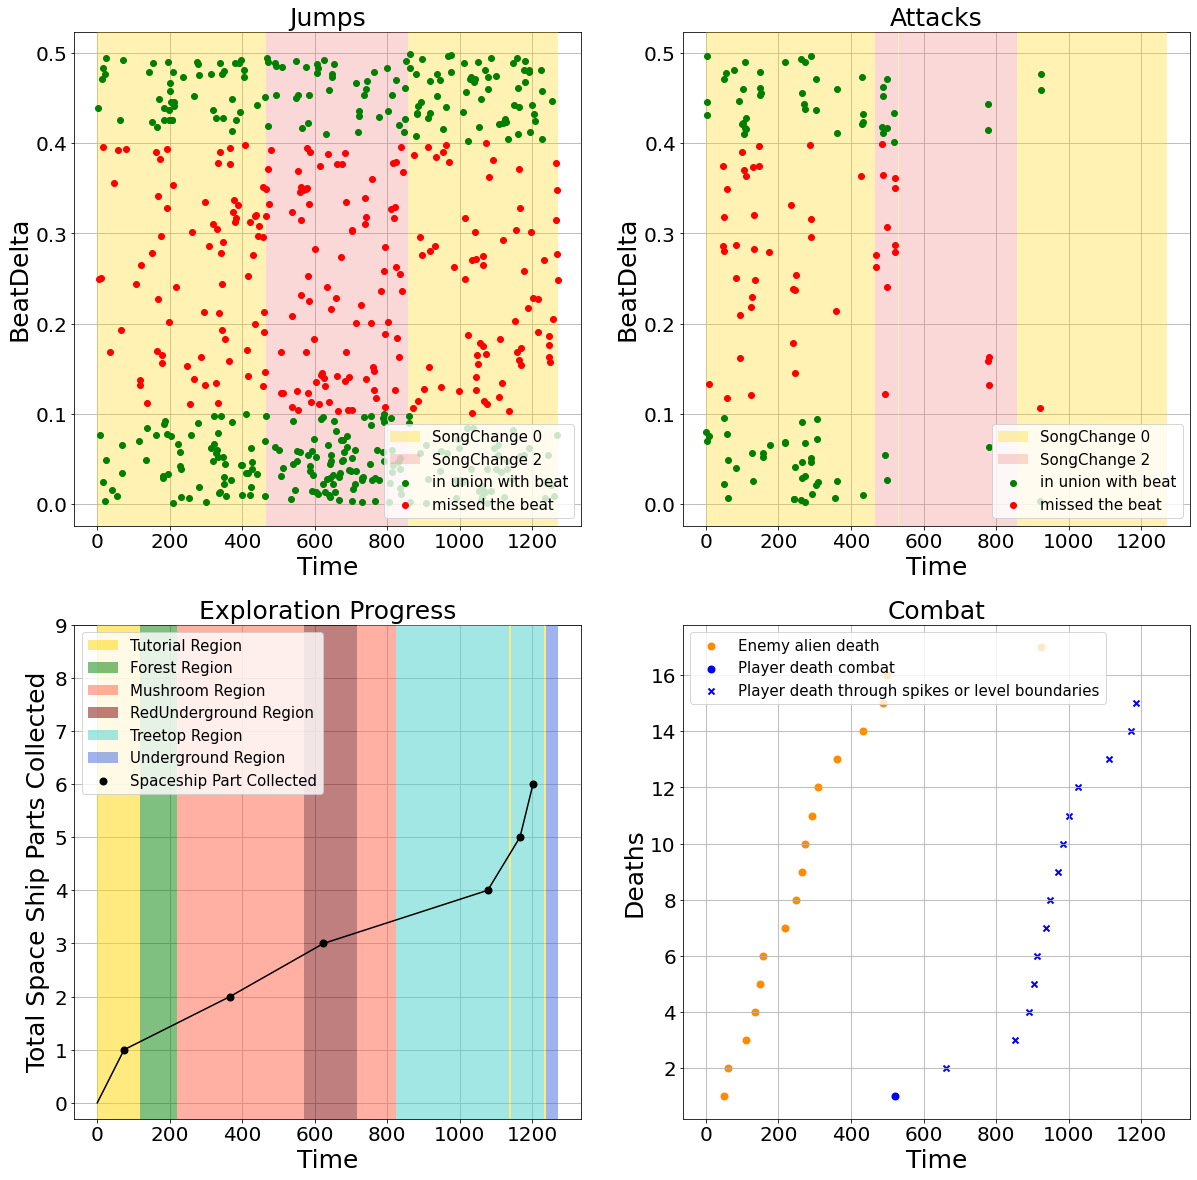

427217_NoRhythm_04_12_21_01_09_Beat_Metric.csv 427217_NoRhythm_04_12_21_01_09_Various_Metric.csv 427217_NoRhythm_04_12_21_01_09_Combat_Metric.csv
      Version  Time                                  Action
0    NoRhythm    12                        Keyboard & Mouse
1    NoRhythm     0                                 Gamepad
2    NoRhythm     0                            SongChange 0
3    NoRhythm     4              Region jump tutorial start
5    NoRhythm    39                Region jump tutorial end
..        ...   ...                                     ...
137  NoRhythm  1130  Region treetop exit to tutorial forest
139  NoRhythm  1142                 Region first boss fight
141  NoRhythm  1148             Region first boss fight end
143  NoRhythm  1154                 Region 2nd forest start
145  NoRhythm  1166                        Keyboard & Mouse

[90 rows x 3 columns]
Jumps hits: 248/713 = 34.78 %
Attacks hits: 248/713 = 34.78 %
time spent in songs: {'SongChange 0': 543, 'SongC

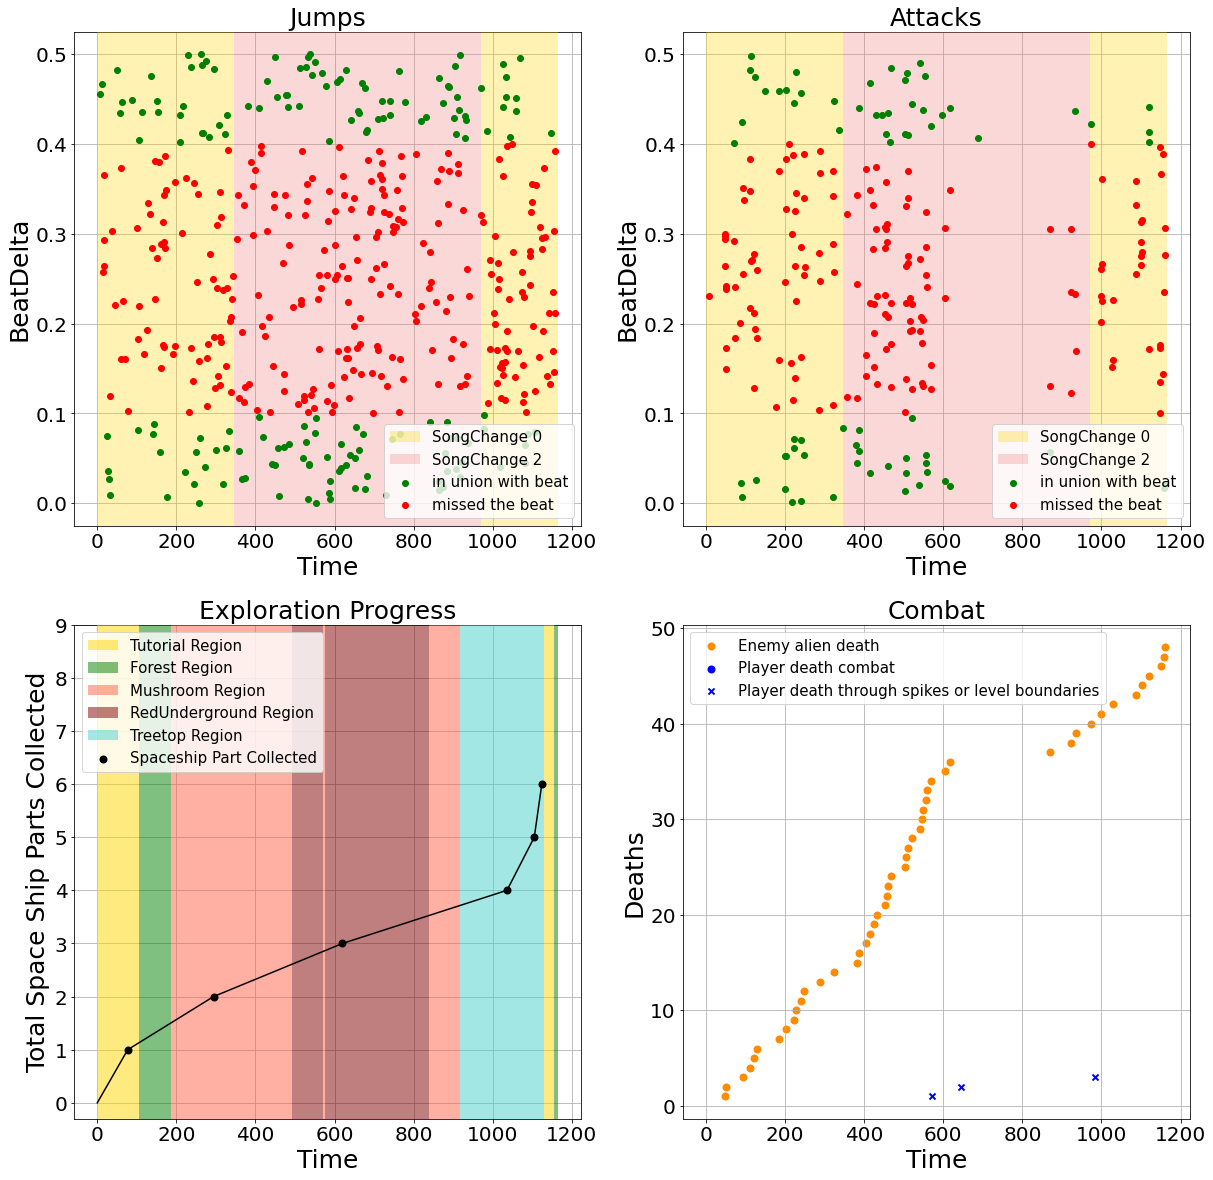

427217_RhythmControlled_04_12_21_02_02_Beat_Metric.csv 427217_RhythmControlled_04_12_21_02_02_Various_Metric.csv 427217_RhythmControlled_04_12_21_02_02_Combat_Metric.csv
              Version  Time                                             Action
0    RhythmControlled    35                                   Keyboard & Mouse
1    RhythmControlled     0                                            Gamepad
2    RhythmControlled     0                                        Fixing sync
3    RhythmControlled     0                                       SongChange 0
4    RhythmControlled     8                         Region jump tutorial start
..                ...   ...                                                ...
132  RhythmControlled  1178  Region red underground get over spikes jump ri...
136  RhythmControlled  1179  Region red underground get over spikes jump ri...
138  RhythmControlled  1191                                       player death
139  RhythmControlled  1194             

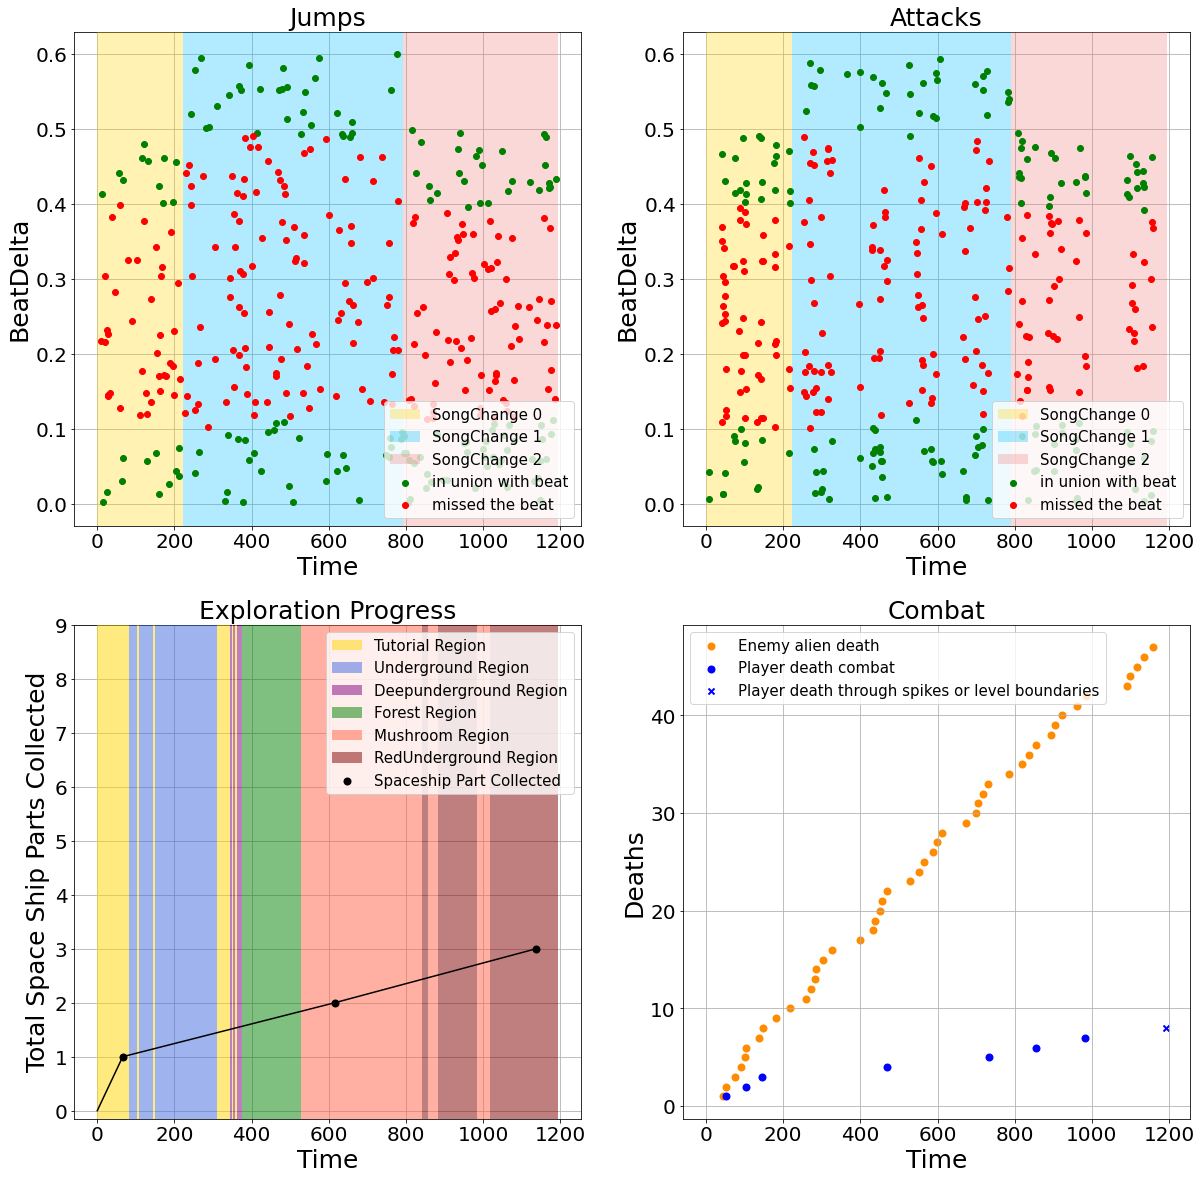

452042_NoRhythm_01_12_21_12_47_Beat_Metric.csv 452042_NoRhythm_01_12_21_12_47_Various_Metric.csv 452042_NoRhythm_01_12_21_12_47_Combat_Metric.csv
      Version  Time                                             Action
0    NoRhythm    12                                   Keyboard & Mouse
1    NoRhythm     0                                       SongChange 0
2    NoRhythm     4                         Region jump tutorial start
4    NoRhythm    34                           Region jump tutorial end
6    NoRhythm    83                            Region first boss fight
..        ...   ...                                                ...
175  NoRhythm  1228    Checkpoint Activated Checkpoint underground red
176  NoRhythm  1240                                       player death
177  NoRhythm  1253  Region red underground get over spikes jump ri...
179  NoRhythm  1264  Region red underground get over spikes jump ri...
183  NoRhythm  1265  Region red underground get over spikes jump ri...

[

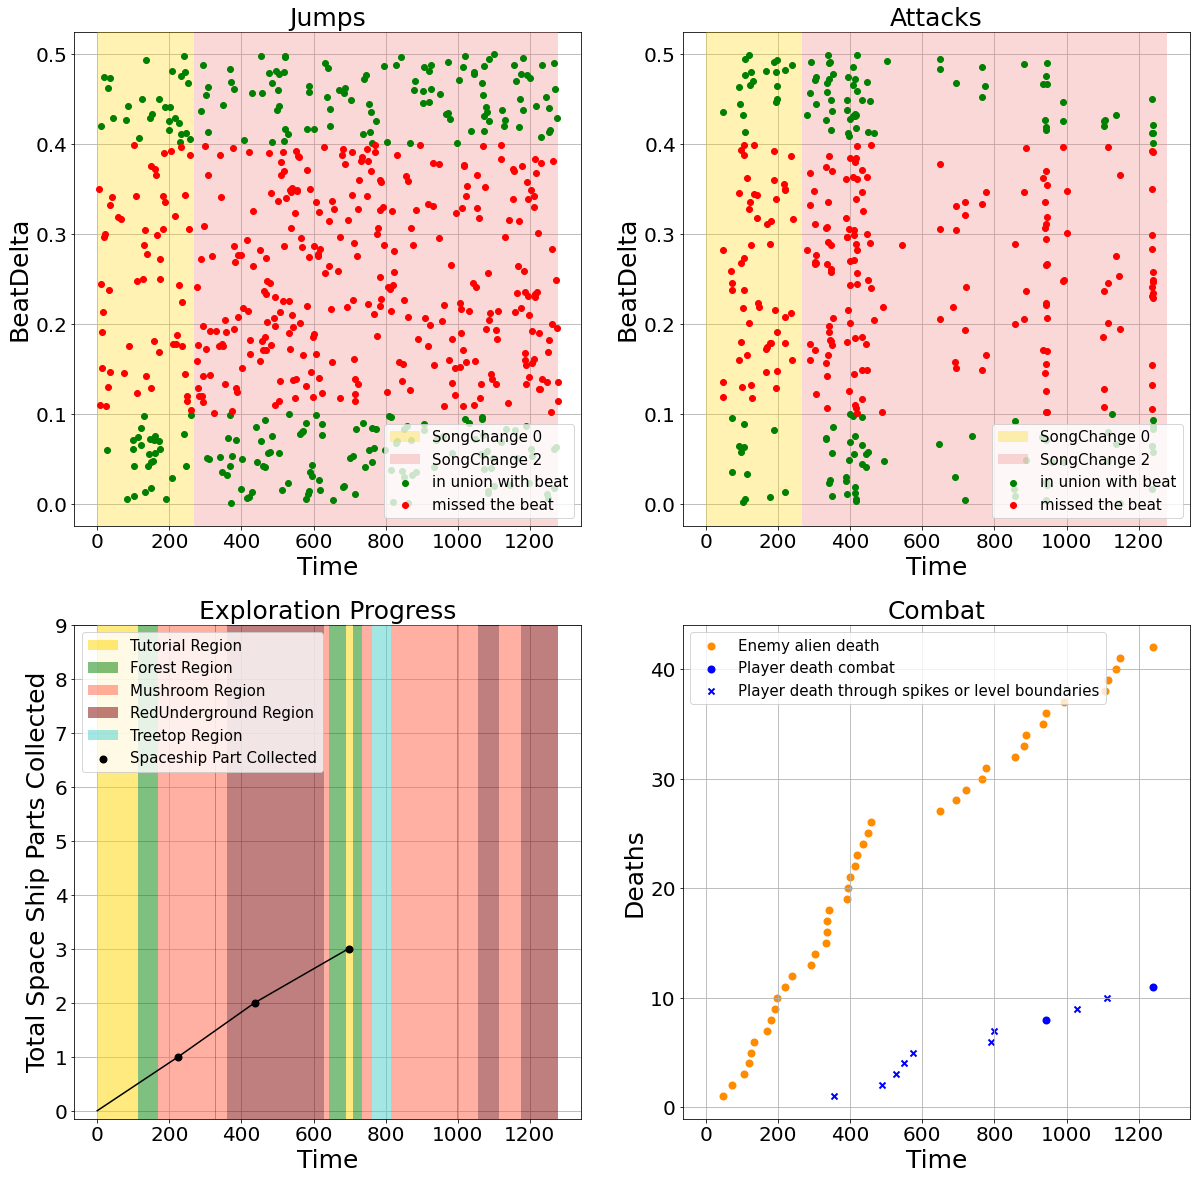

452042_RhythmControlled_01_12_21_01_19_Beat_Metric.csv 452042_RhythmControlled_01_12_21_01_19_Various_Metric.csv 452042_RhythmControlled_01_12_21_01_19_Combat_Metric.csv
              Version  Time                                        Action
0    RhythmControlled    12                              Keyboard & Mouse
1    RhythmControlled     0                                   Fixing sync
2    RhythmControlled     0                                  SongChange 0
3    RhythmControlled     5                    Region jump tutorial start
5    RhythmControlled    21                      Region jump tutorial end
..                ...   ...                                           ...
155  RhythmControlled  1171                                  player death
156  RhythmControlled  1178                       Region treetop songtree
158  RhythmControlled  1184                                  player death
159  RhythmControlled  1191                       Region treetop songtree
161  RhythmContr

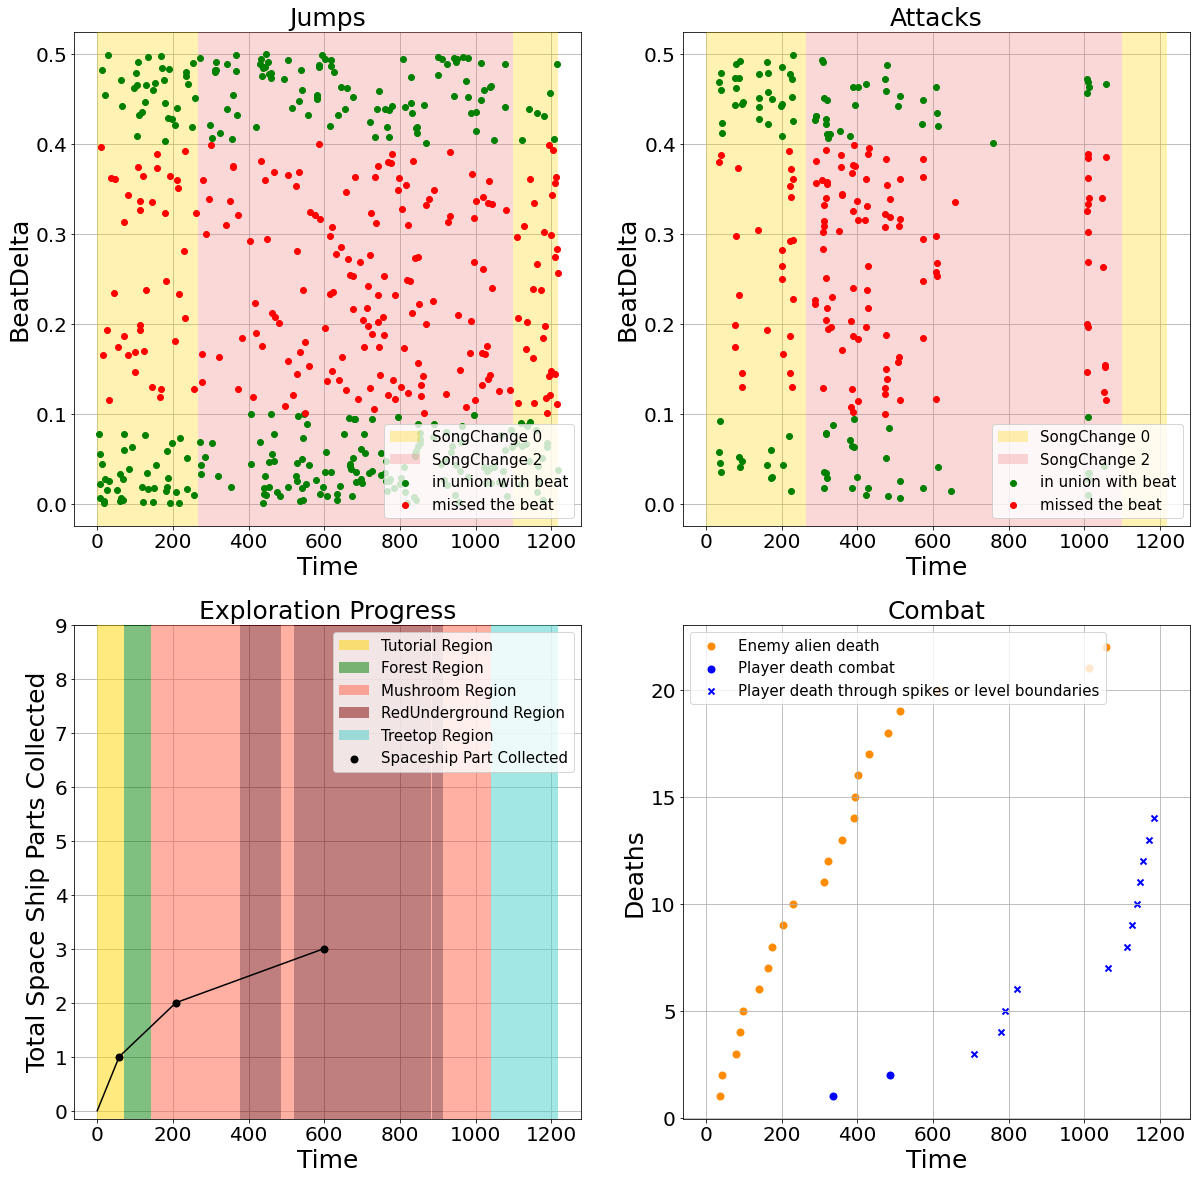

481091_NoRhythm_04_12_21_07_41_Beat_Metric.csv 481091_NoRhythm_04_12_21_07_41_Various_Metric.csv 481091_NoRhythm_04_12_21_07_41_Combat_Metric.csv
      Version  Time                                     Action
0    NoRhythm    17                           Keyboard & Mouse
1    NoRhythm     0                               SongChange 0
2    NoRhythm     2                 Region jump tutorial start
4    NoRhythm    43                   Region jump tutorial end
6    NoRhythm    50                   Region jump tutorial end
..        ...   ...                                        ...
146  NoRhythm  1068             Region mushroom slime boss end
148  NoRhythm  1088   Checkpoint Activated Song_Tree mushrooms
149  NoRhythm  1091                               SongChange 1
150  NoRhythm  1094             Region mushroom songtree cliff
152  NoRhythm  1118  Checkpoint Activated Checkpoint mushroom1

[91 rows x 3 columns]
Jumps hits: 286/749 = 38.18 %
Attacks hits: 286/749 = 38.18 %
time spent in

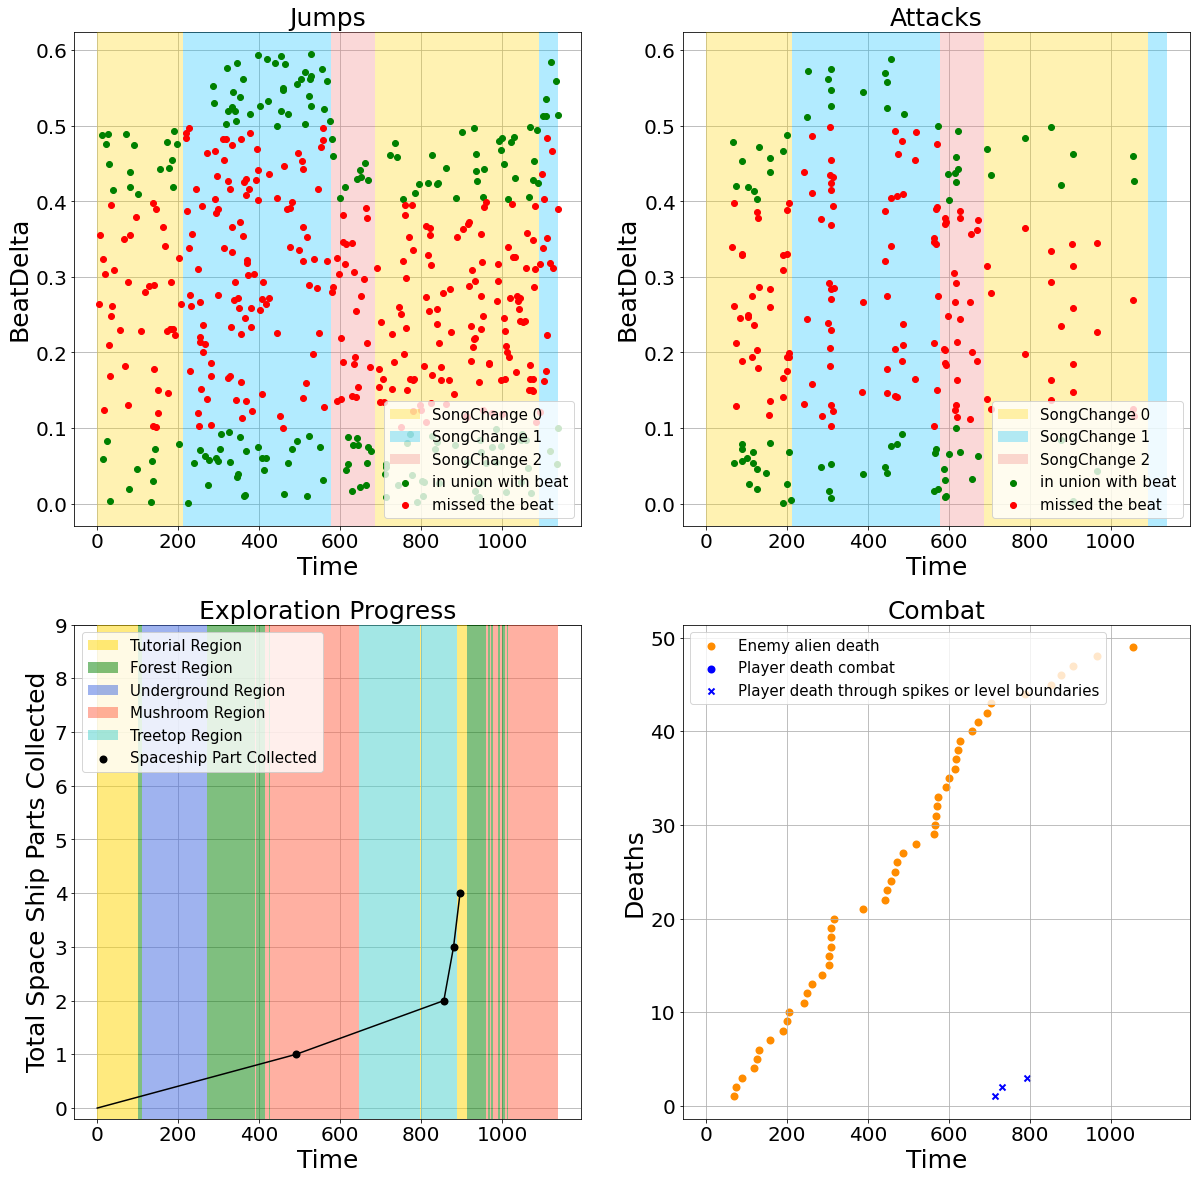

481091_RhythmControlled_04_12_21_08_10_Beat_Metric.csv 481091_RhythmControlled_04_12_21_08_10_Various_Metric.csv 481091_RhythmControlled_04_12_21_08_10_Combat_Metric.csv
              Version  Time                       Action
0    RhythmControlled     9             Keyboard & Mouse
1    RhythmControlled     0                  Fixing sync
2    RhythmControlled     0                 SongChange 0
3    RhythmControlled    15   Region jump tutorial start
5    RhythmControlled    28     Region jump tutorial end
..                ...   ...                          ...
155  RhythmControlled  1144  Region first boss fight end
157  RhythmControlled  1145   Region underground entry 1
159  RhythmControlled  1152   Region underground entry 2
161  RhythmControlled  1157   Region underground entry 2
163  RhythmControlled  1161      Region 2nd forest start

[103 rows x 3 columns]
Jumps hits: 510/739 = 69.01 %
Attacks hits: 510/739 = 69.01 %
time spent in songs: {'SongChange 0': 496, 'SongChange 1': 0

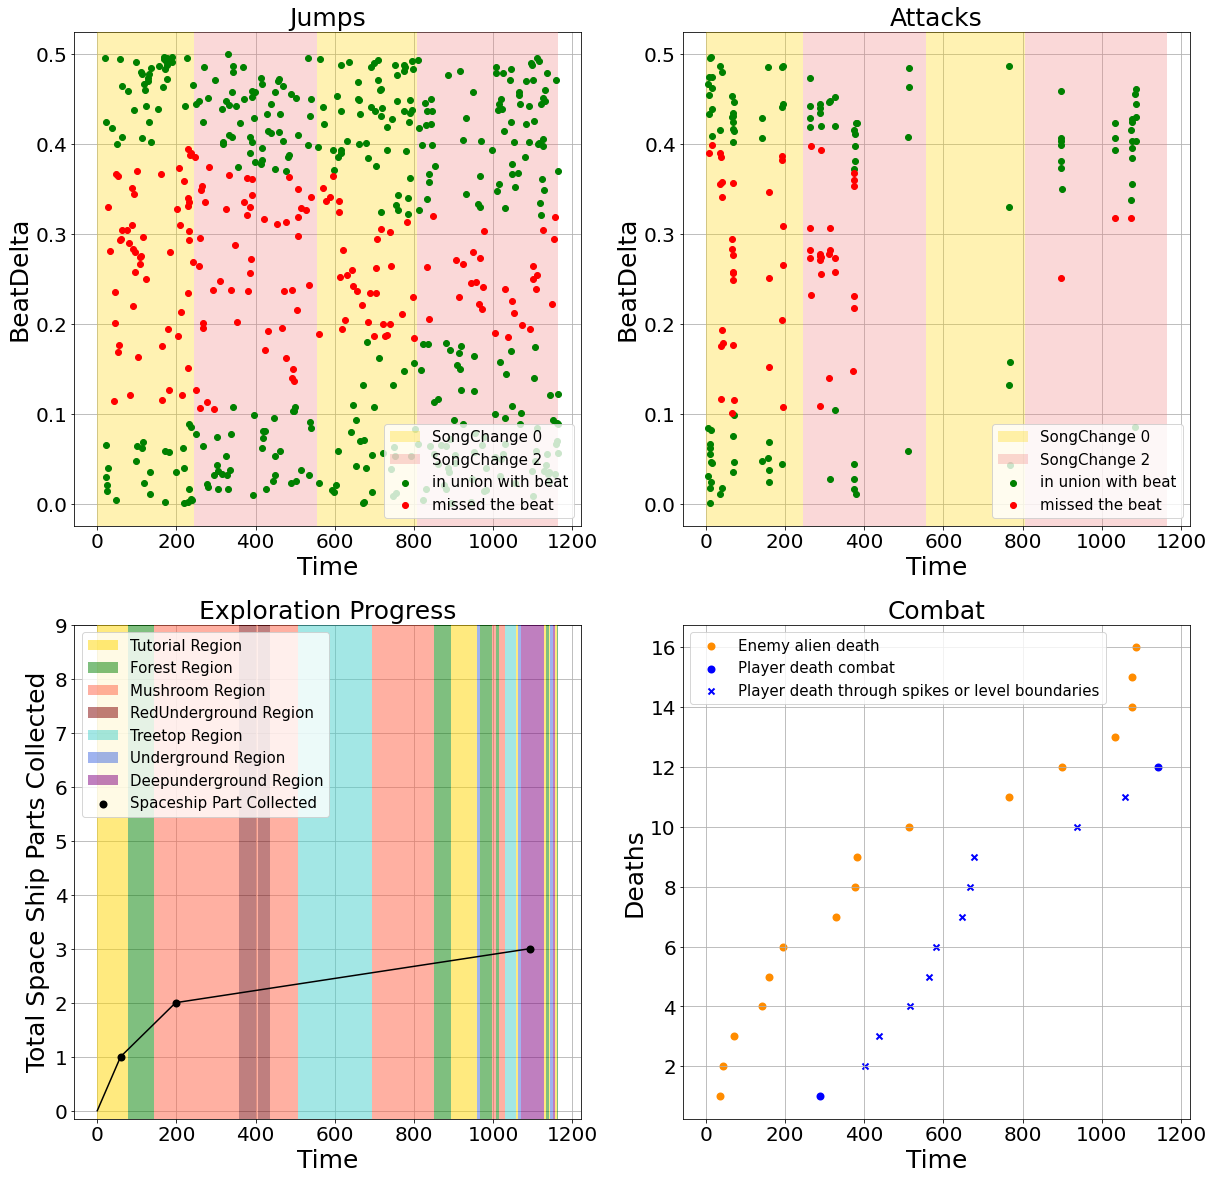

527704_NoRhythm_30_11_21_10_40_Beat_Metric.csv 527704_NoRhythm_30_11_21_10_40_Various_Metric.csv 527704_NoRhythm_30_11_21_10_40_Combat_Metric.csv
      Version  Time                            Action
0    NoRhythm    19                  Keyboard & Mouse
1    NoRhythm     0                      SongChange 0
2    NoRhythm     3                           Gamepad
3    NoRhythm     4        Region jump tutorial start
5    NoRhythm    20          Region jump tutorial end
..        ...   ...                               ...
181  NoRhythm  1173  Region mushroom slime boss start
183  NoRhythm  1184                      player death
184  NoRhythm  1188  Region mushroom slime boss start
186  NoRhythm  1206    Region mushroom slime boss end
188  NoRhythm  1213                  Keyboard & Mouse

[117 rows x 3 columns]
Jumps hits: 336/842 = 39.9 %
Attacks hits: 336/842 = 39.9 %
time spent in songs: {'SongChange 0': 555, 'SongChange 1': 578, 'SongChange 2': 80}
space ship parts collected: 7/9 = 77.7

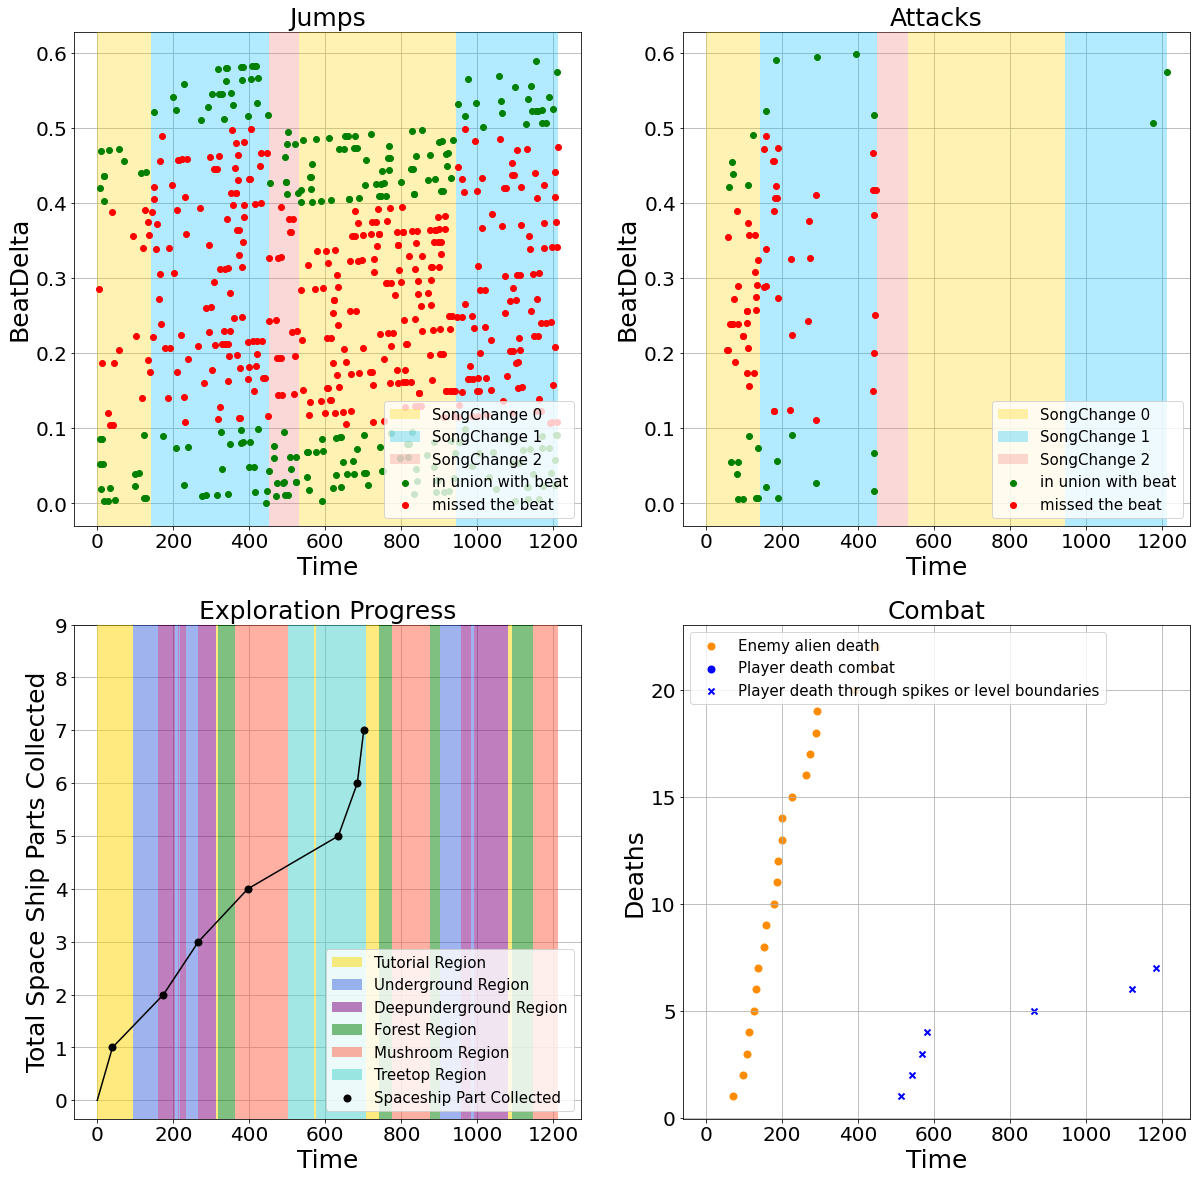

527704_RhythmControlled_30_11_21_10_11_Beat_Metric.csv 527704_RhythmControlled_30_11_21_10_11_Various_Metric.csv 527704_RhythmControlled_30_11_21_10_11_Combat_Metric.csv
              Version  Time                                             Action
0    RhythmControlled    23                                   Keyboard & Mouse
1    RhythmControlled     0                                        Fixing sync
2    RhythmControlled     0                                       SongChange 0
3    RhythmControlled     6                                            Gamepad
4    RhythmControlled     7                         Region jump tutorial start
..                ...   ...                                                ...
114  RhythmControlled  1116  Region red underground get over spikes jump ri...
116  RhythmControlled  1128  Region red underground get over spikes jump ri...
118  RhythmControlled  1139                                        Fixing sync
119  RhythmControlled  1139             

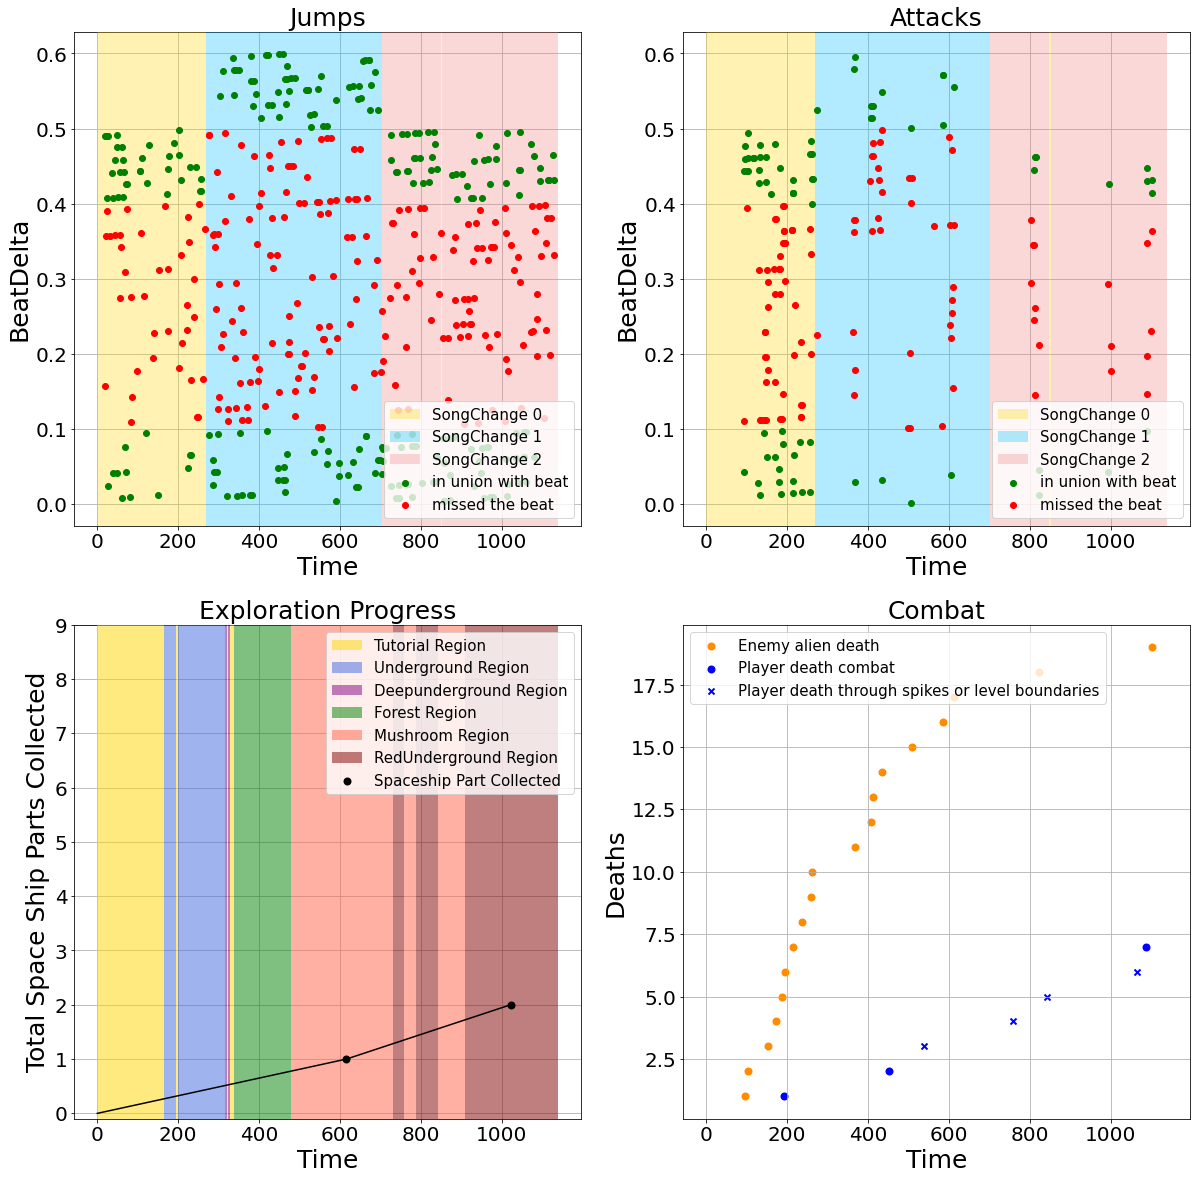

562408_NoRhythm_14_12_21_05_12_Beat_Metric.csv 562408_NoRhythm_14_12_21_05_12_Various_Metric.csv 562408_NoRhythm_14_12_21_05_12_Combat_Metric.csv
     Version  Time                                    Action
0   NoRhythm    24                          Keyboard & Mouse
1   NoRhythm     0                              SongChange 0
2   NoRhythm     5                Region jump tutorial start
4   NoRhythm    60                  Region jump tutorial end
6   NoRhythm    93                   Region first boss fight
8   NoRhythm   114               Region first boss fight end
10  NoRhythm   120                   Region 2nd forest start
12  NoRhythm   139                 Region 2nd forest spire 1
13  NoRhythm   140                 Region 2nd forest spire 1
15  NoRhythm   227                 Region 2nd forest spire 2
17  NoRhythm   233                     Region 2nd forest end
19  NoRhythm   240                     Region 2nd forest end
21  NoRhythm   243            Region mushroom downward entry


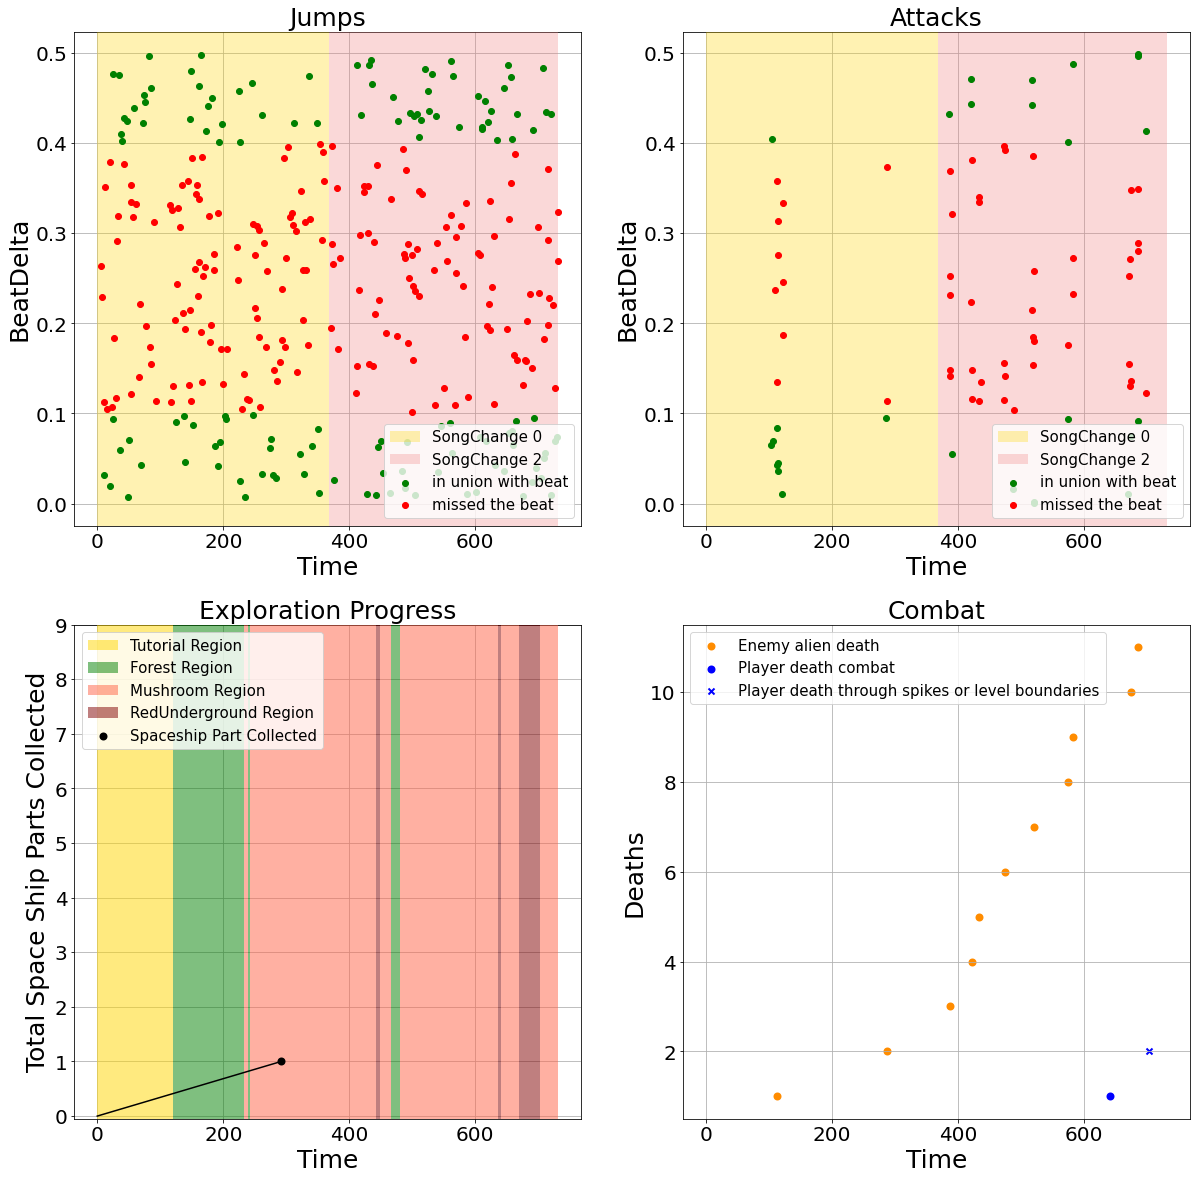

562408_RhythmControlled_14_12_21_05_32_Beat_Metric.csv 562408_RhythmControlled_14_12_21_05_32_Various_Metric.csv 562408_RhythmControlled_14_12_21_05_32_Combat_Metric.csv
              Version  Time                                Action
0    RhythmControlled    17                      Keyboard & Mouse
1    RhythmControlled     0                           Fixing sync
2    RhythmControlled     0                          SongChange 0
3    RhythmControlled     1            Region jump tutorial start
5    RhythmControlled    11              Region jump tutorial end
..                ...   ...                                   ...
116  RhythmControlled   848          SpaceShip collected treetop1
117  RhythmControlled   873         Region treetop mushroom entry
119  RhythmControlled   884  Region mushroom lower platform right
121  RhythmControlled   900      Region mushroom slime boss start
123  RhythmControlled   977                           Fixing sync

[71 rows x 3 columns]
Jumps hits: 279

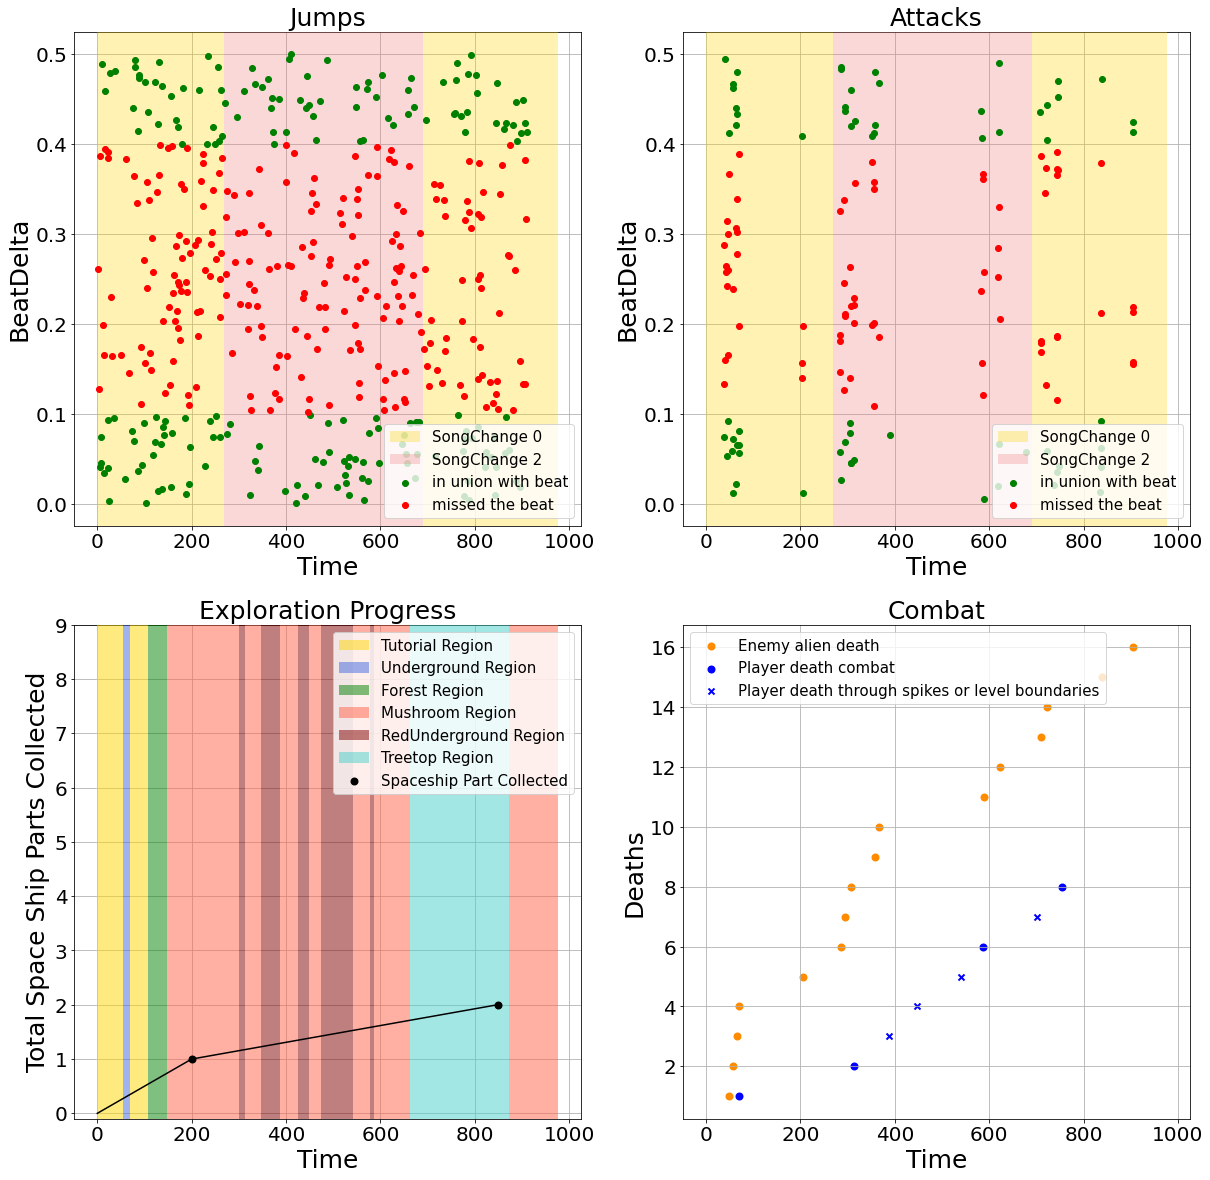

621162_NoRhythm_04_12_21_11_56_Beat_Metric.csv 621162_NoRhythm_04_12_21_11_56_Various_Metric.csv 621162_NoRhythm_04_12_21_11_56_Combat_Metric.csv
     Version  Time                                      Action
0   NoRhythm    17                            Keyboard & Mouse
1   NoRhythm     0                                SongChange 0
2   NoRhythm     9                  Region jump tutorial start
4   NoRhythm    15                  Region jump tutorial start
6   NoRhythm    36                    Region jump tutorial end
8   NoRhythm    41    Checkpoint Activated Checkpoint tutorial
9   NoRhythm    48                    Region jump tutorial end
11  NoRhythm    49                    Region jump tutorial end
13  NoRhythm   103                SpaceShip collected tutorial
14  NoRhythm   108                     Region first boss fight
16  NoRhythm   119                 Region first boss fight end
18  NoRhythm   121  Checkpoint Activated Checkpoint first boss
19  NoRhythm   124                 

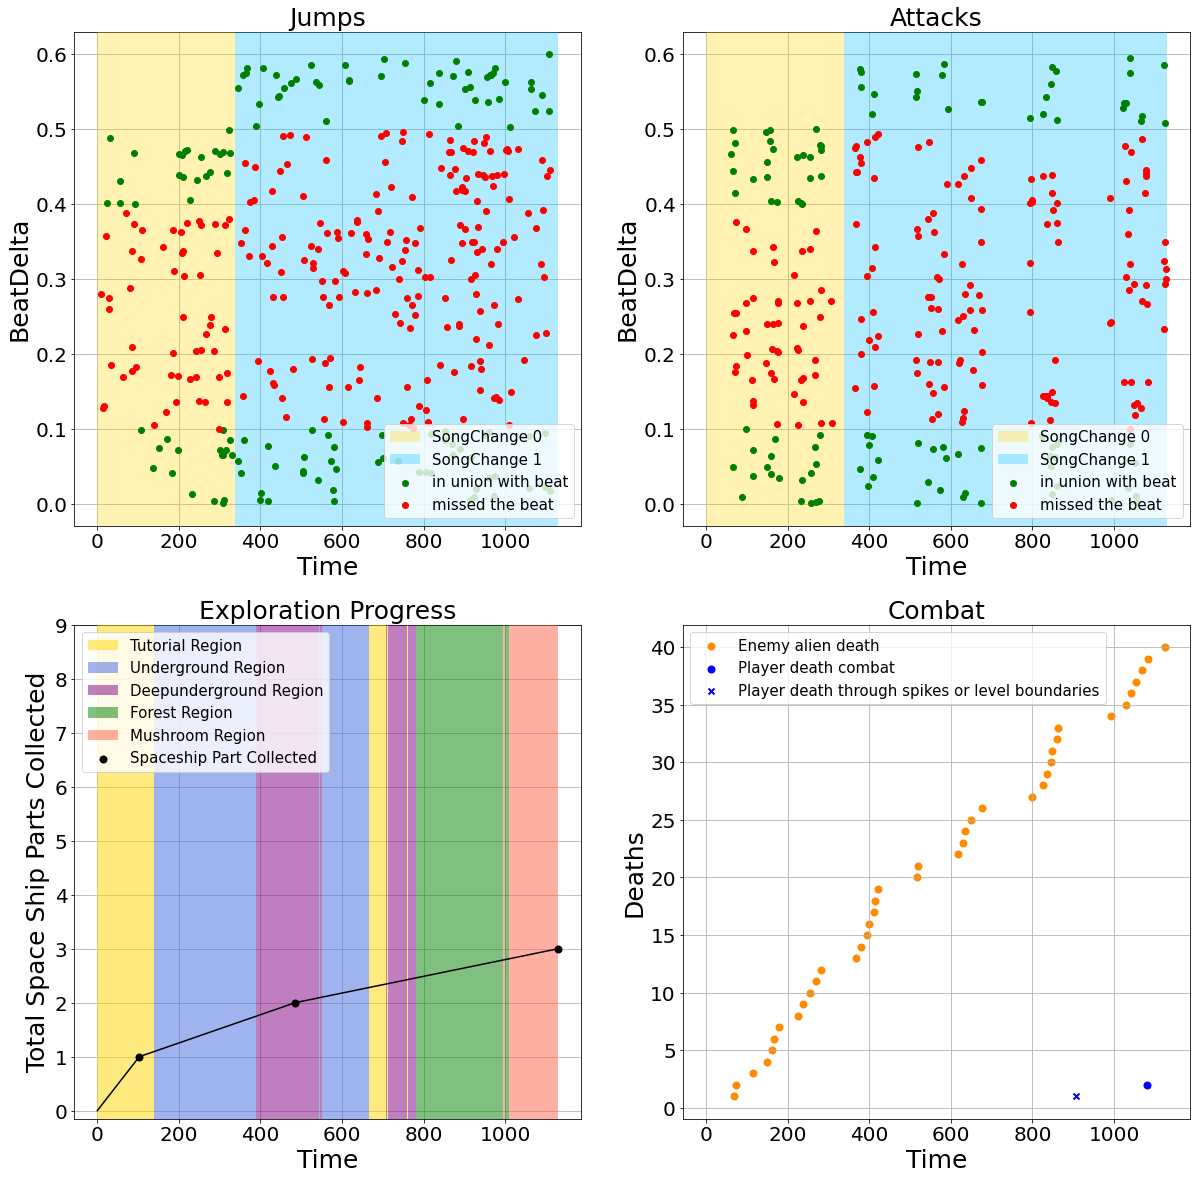

621162_RhythmControlled_04_12_21_12_35_Beat_Metric.csv 621162_RhythmControlled_04_12_21_12_35_Various_Metric.csv 621162_RhythmControlled_04_12_21_12_35_Combat_Metric.csv
             Version  Time                                      Action
0   RhythmControlled    14                            Keyboard & Mouse
1   RhythmControlled     0                                 Fixing sync
2   RhythmControlled     0                                SongChange 0
3   RhythmControlled     8                  Region jump tutorial start
5   RhythmControlled    51                    Region jump tutorial end
7   RhythmControlled    55    Checkpoint Activated Checkpoint tutorial
8   RhythmControlled    72                                 Fixing sync
9   RhythmControlled    73                                 Fixing sync
10  RhythmControlled    82                                 Fixing sync
12  RhythmControlled    84                    Region jump tutorial end
14  RhythmControlled   138                     Re

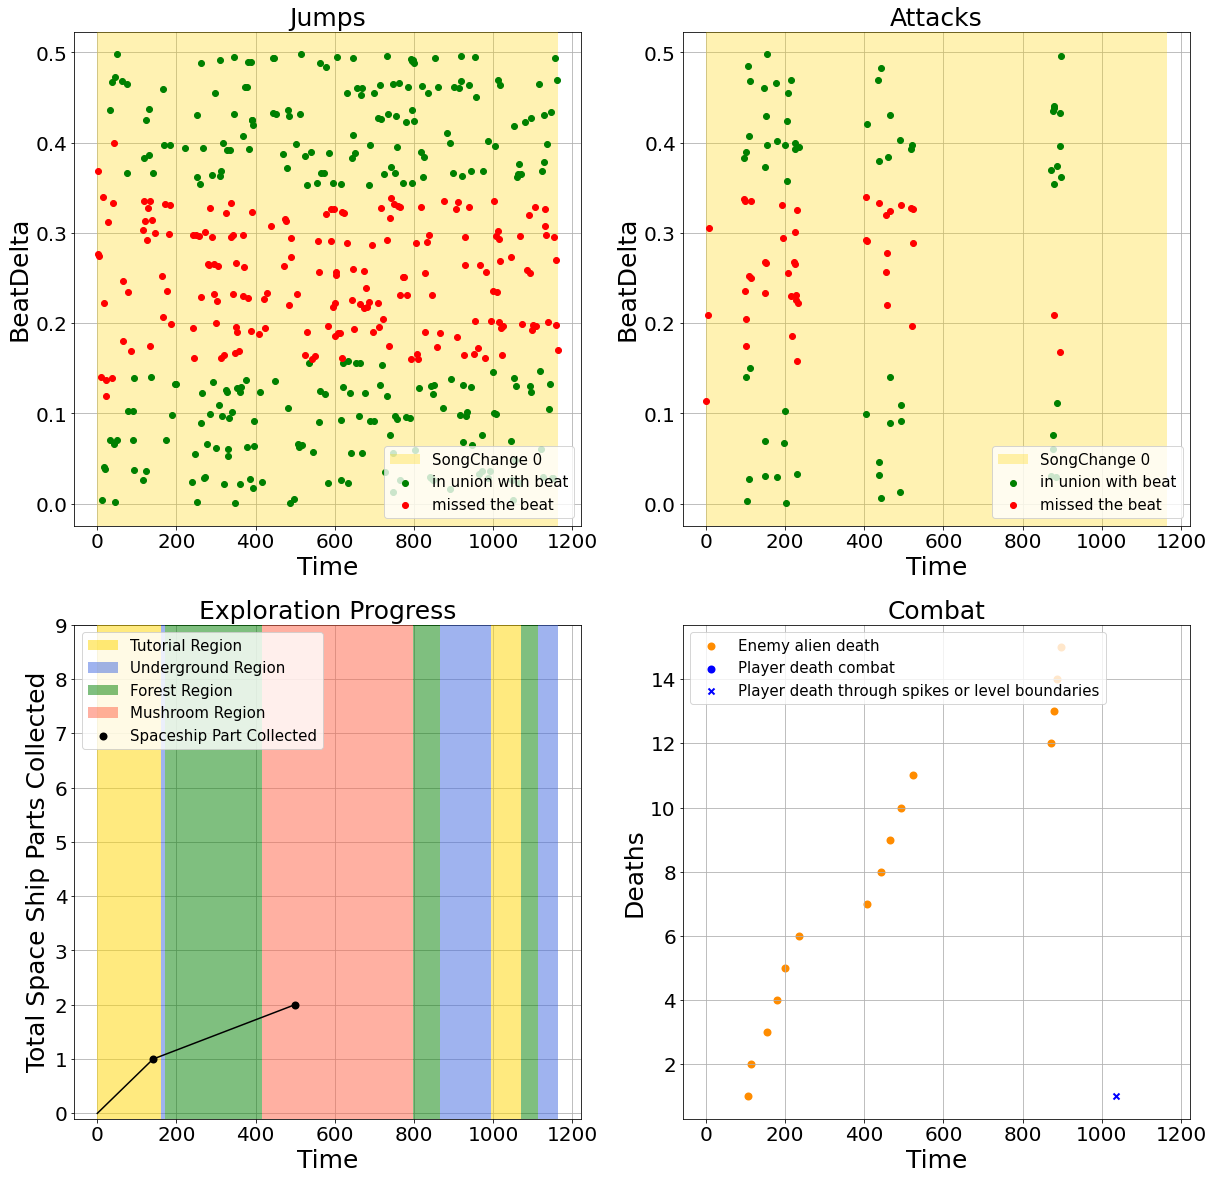

624794_NoRhythm_30_11_21_01_06_Beat_Metric.csv 624794_NoRhythm_30_11_21_01_06_Various_Metric.csv 624794_NoRhythm_30_11_21_01_06_Combat_Metric.csv
      Version  Time                                     Action
0    NoRhythm    20                           Keyboard & Mouse
1    NoRhythm     0                               SongChange 0
2    NoRhythm     4                                    Gamepad
3    NoRhythm     7                 Region jump tutorial start
5    NoRhythm     8                 Region jump tutorial start
..        ...   ...                                        ...
139  NoRhythm   984           Region mushroom slime boss start
141  NoRhythm   993           Region mushroom slime boss start
143  NoRhythm  1019               Region red underground entry
145  NoRhythm  1059  Region red underground bossplatform start
147  NoRhythm  1067                           Keyboard & Mouse

[95 rows x 3 columns]
Jumps hits: 271/729 = 37.17 %
Attacks hits: 271/729 = 37.17 %
time spent in

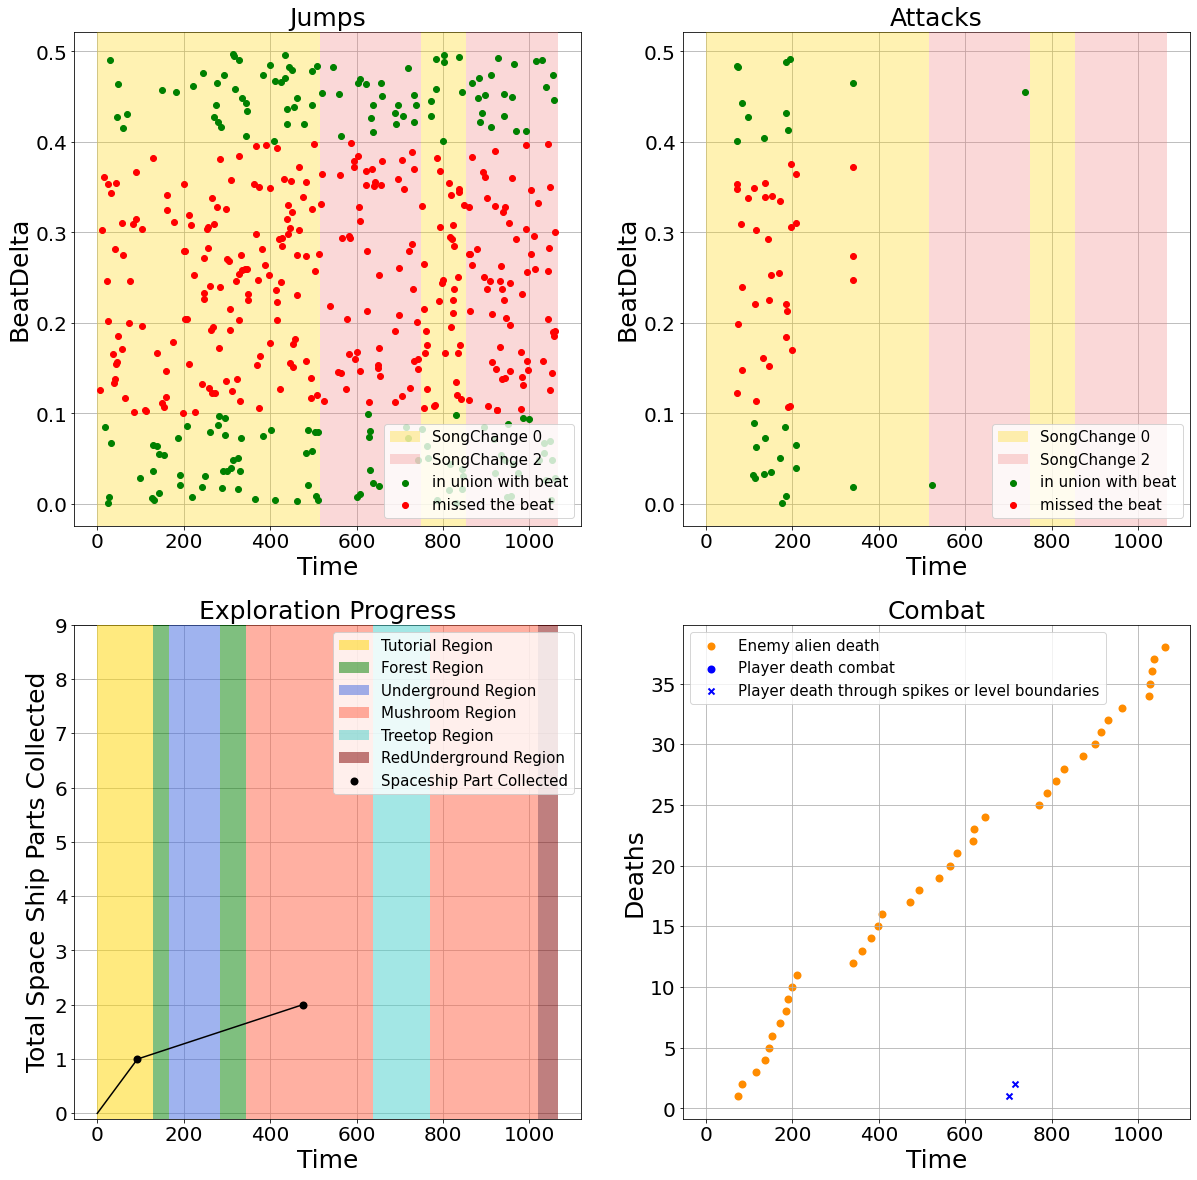

624794_RhythmControlled_30_11_21_01_33_Beat_Metric.csv 624794_RhythmControlled_30_11_21_01_33_Various_Metric.csv 624794_RhythmControlled_30_11_21_01_33_Combat_Metric.csv
              Version  Time                      Action
0    RhythmControlled    13            Keyboard & Mouse
1    RhythmControlled     0                 Fixing sync
2    RhythmControlled     0                SongChange 0
3    RhythmControlled     1                     Gamepad
4    RhythmControlled    13  Region jump tutorial start
..                ...   ...                         ...
147  RhythmControlled  1263                player death
148  RhythmControlled  1265            Keyboard & Mouse
149  RhythmControlled  1266                     Gamepad
150  RhythmControlled  1266                 Fixing sync
151  RhythmControlled  1266            Keyboard & Mouse

[100 rows x 3 columns]
Jumps hits: 407/1100 = 37.0 %
Attacks hits: 407/1100 = 37.0 %
time spent in songs: {'SongChange 0': 681, 'SongChange 1': 0, 'SongChang

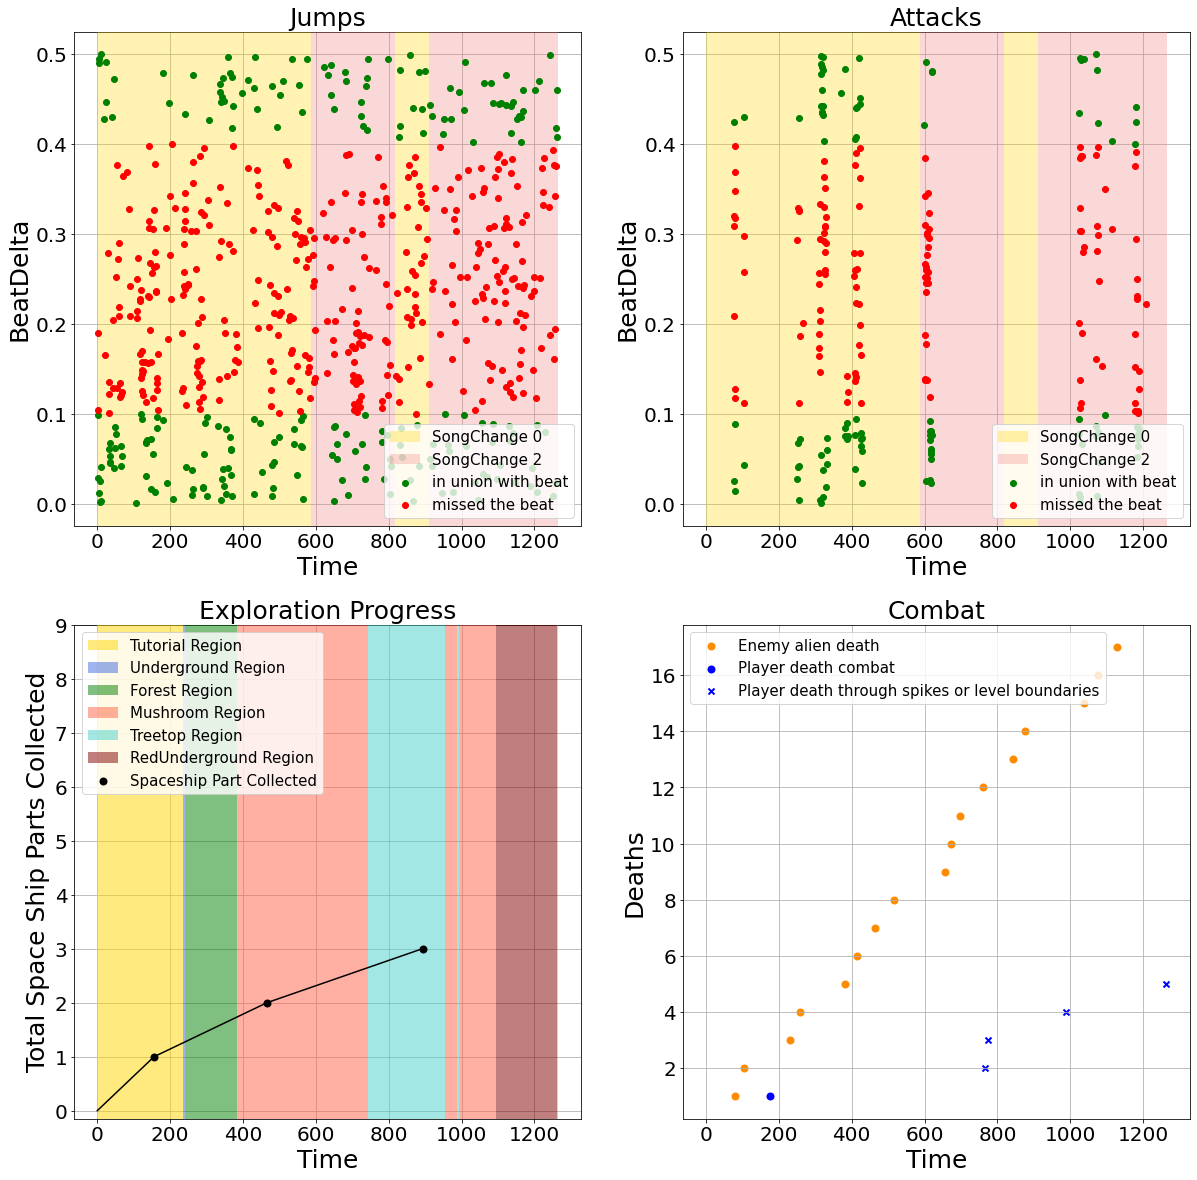

758980_NoRhythm_02_12_21_04_30_Beat_Metric.csv 758980_NoRhythm_02_12_21_04_30_Various_Metric.csv 758980_NoRhythm_02_12_21_04_30_Combat_Metric.csv
      Version  Time                                        Action
0    NoRhythm    11                              Keyboard & Mouse
1    NoRhythm     0                                  SongChange 0
2    NoRhythm     1                    Region jump tutorial start
4    NoRhythm    19                      Region jump tutorial end
6    NoRhythm    37                  SpaceShip collected tutorial
..        ...   ...                                           ...
152  NoRhythm  1137                       Region treetop songtree
154  NoRhythm  1148  Region treetop lower platform after songtree
156  NoRhythm  1183         Region treetop top spaceship platform
158  NoRhythm  1187                  SpaceShip collected treetop1
159  NoRhythm  1188      Checkpoint Activated Checkpoint treetop2

[99 rows x 3 columns]
Jumps hits: 429/1028 = 41.73 %
Attacks 

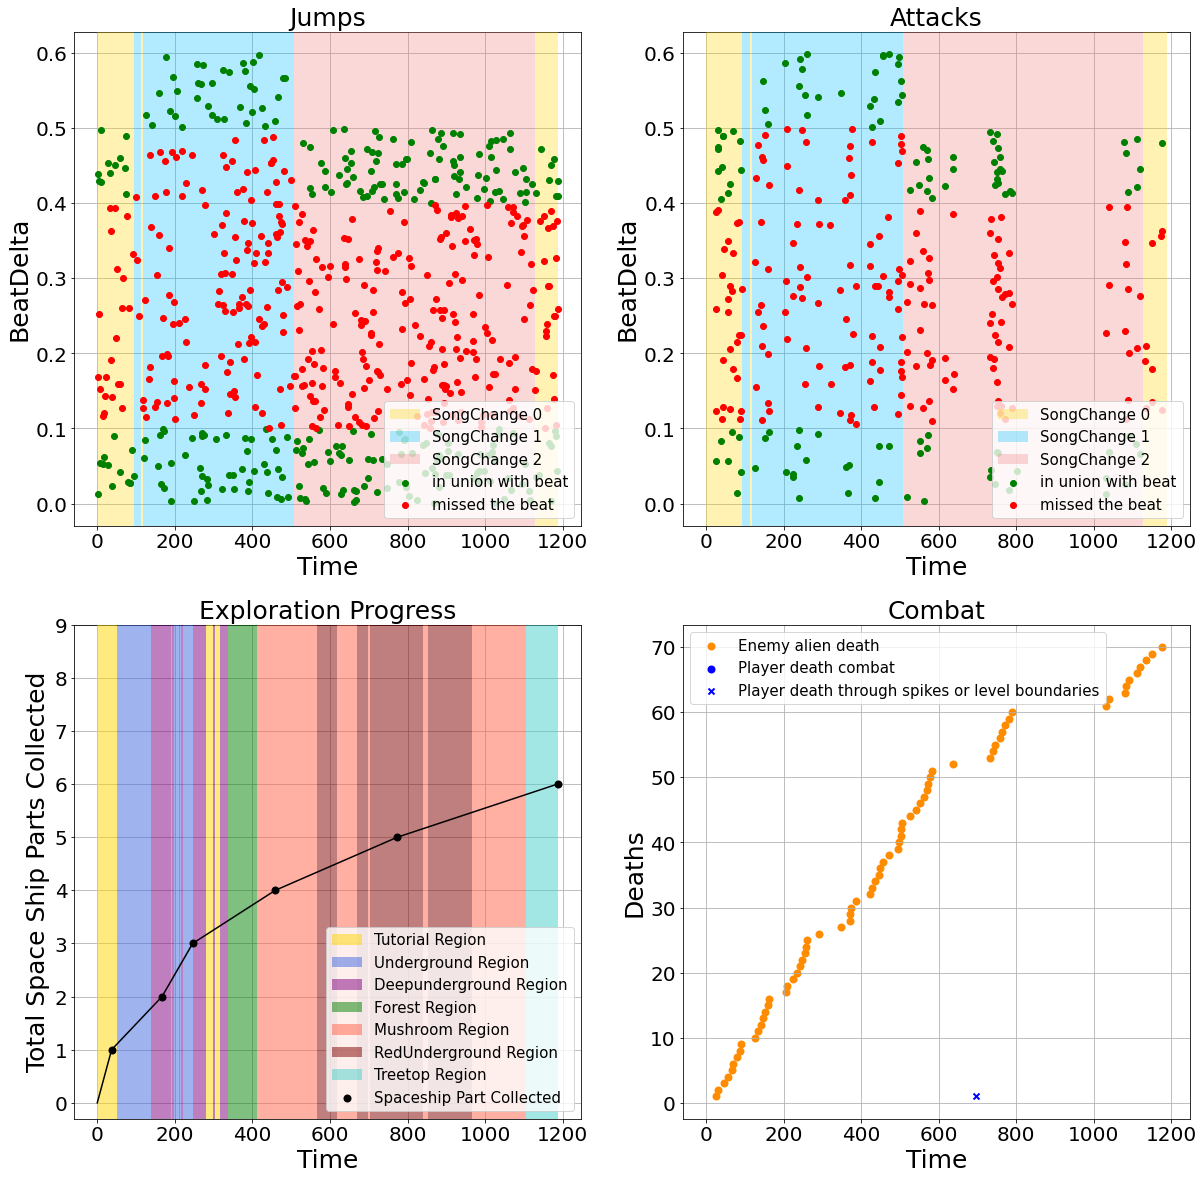

758980_RhythmControlled_02_12_21_04_01_Beat_Metric.csv 758980_RhythmControlled_02_12_21_04_01_Various_Metric.csv 758980_RhythmControlled_02_12_21_04_01_Combat_Metric.csv
              Version  Time                                             Action
0    RhythmControlled    12                                   Keyboard & Mouse
1    RhythmControlled     0                                        Fixing sync
2    RhythmControlled     0                                       SongChange 0
3    RhythmControlled     7                         Region jump tutorial start
4    RhythmControlled     8                         Region jump tutorial start
..                ...   ...                                                ...
130  RhythmControlled  1125  Region red underground get over spikes jump ri...
132  RhythmControlled  1133                                       player death
133  RhythmControlled  1147  Region red underground get over spikes jump ri...
137  RhythmControlled  1156  Region red 

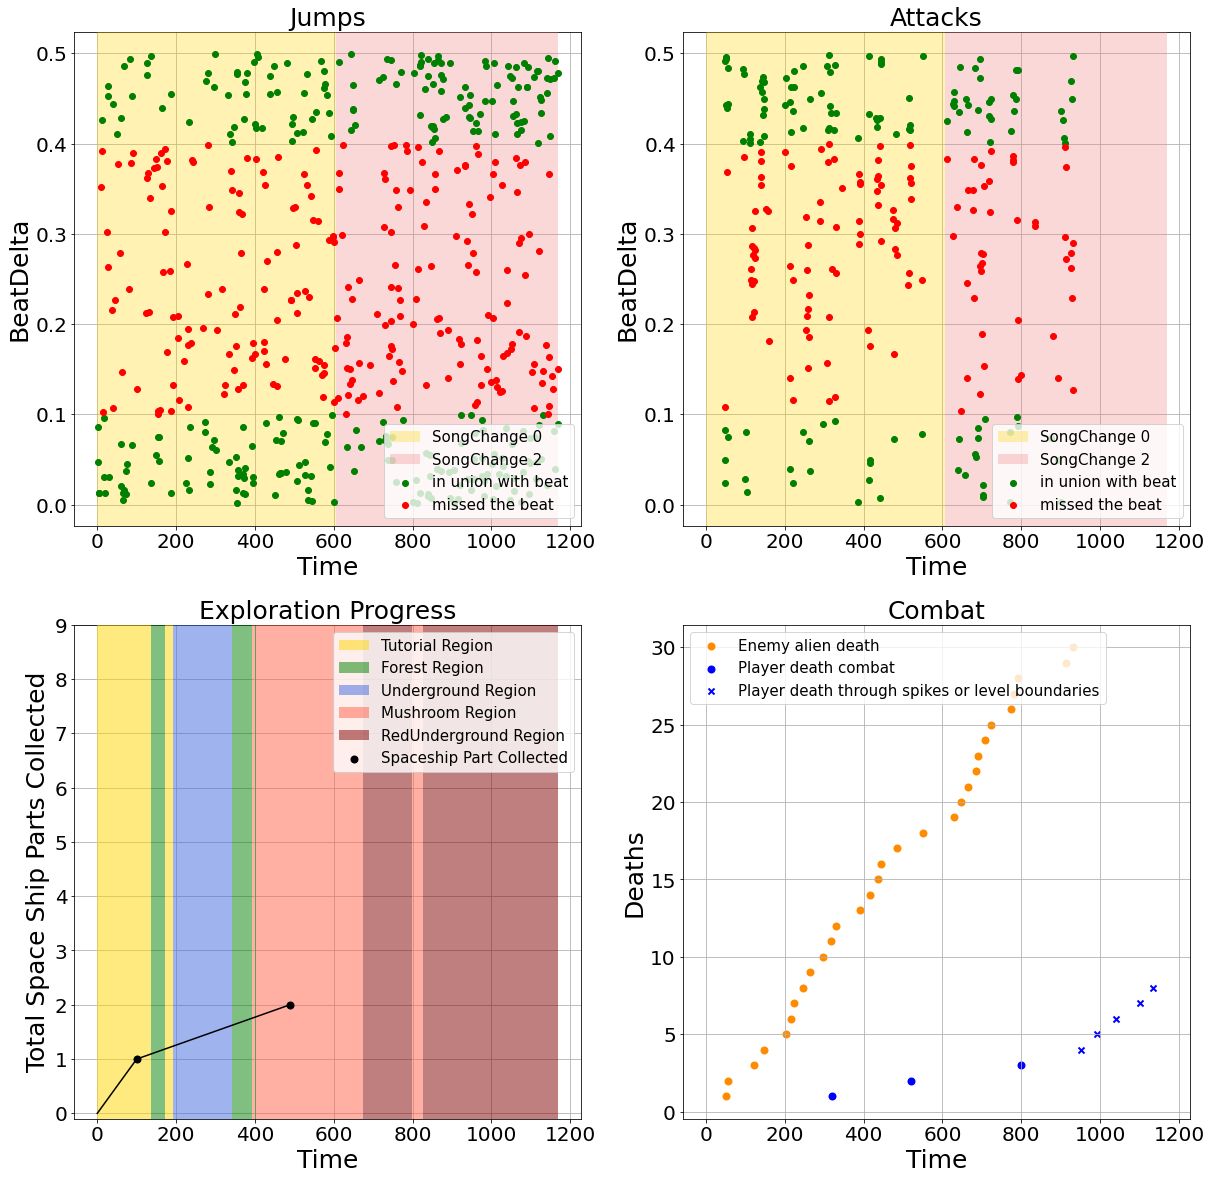

763723_NoRhythm_14_12_21_05_32_Beat_Metric.csv 763723_NoRhythm_14_12_21_05_32_Various_Metric.csv 763723_NoRhythm_14_12_21_05_32_Combat_Metric.csv
      Version  Time                                      Action
0    NoRhythm    10                            Keyboard & Mouse
1    NoRhythm     0                                SongChange 0
2    NoRhythm     3                  Region jump tutorial start
4    NoRhythm    21                    Region jump tutorial end
6    NoRhythm    34                     Region first boss fight
..        ...   ...                                         ...
108  NoRhythm   467            Region mushroom slime boss start
109  NoRhythm   468            Region mushroom slime boss start
110  NoRhythm   468  Checkpoint Activated Checkpoint mushroom 2
113  NoRhythm   497              Region mushroom slime boss end
115  NoRhythm   564              Region mushroom songtree cliff

[69 rows x 3 columns]
Jumps hits: 172/442 = 38.91 %
Attacks hits: 172/442 = 38.91 %
t

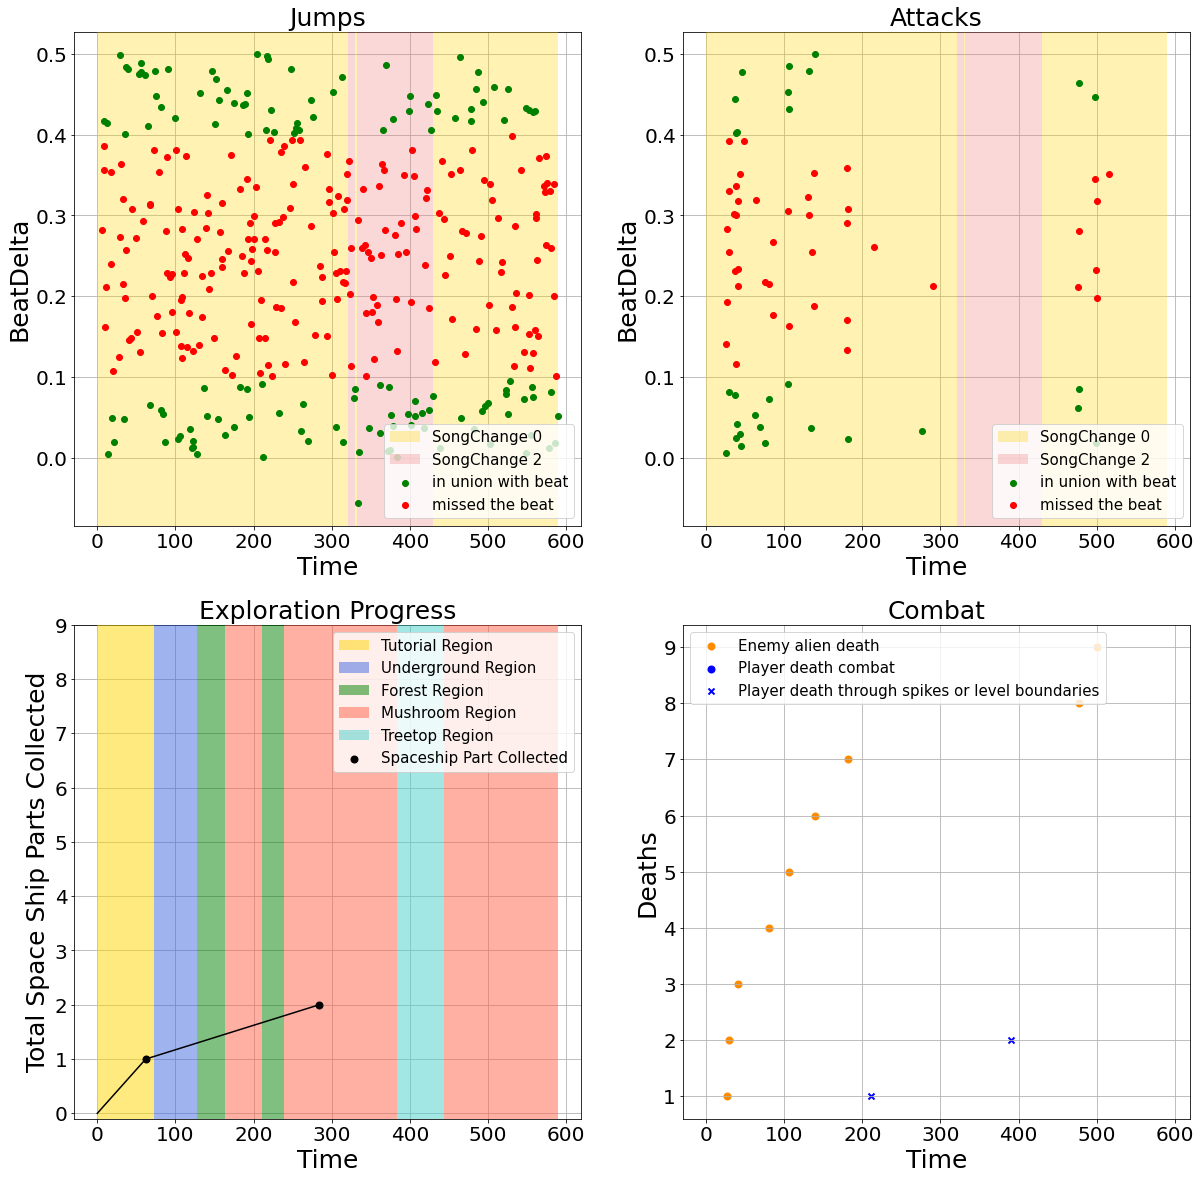

763723_RhythmControlled_14_12_21_05_07_Beat_Metric.csv 763723_RhythmControlled_14_12_21_05_07_Various_Metric.csv 763723_RhythmControlled_14_12_21_05_07_Combat_Metric.csv
              Version  Time                                           Action
0    RhythmControlled    36                                 Keyboard & Mouse
1    RhythmControlled     0                                      Fixing sync
2    RhythmControlled     0                                     SongChange 0
3    RhythmControlled     6                       Region jump tutorial start
5    RhythmControlled    30                         Region jump tutorial end
..                ...   ...                                              ...
115  RhythmControlled   872          Region red underground bossplatform end
117  RhythmControlled   877  Checkpoint Activated Checkpoint underground red
118  RhythmControlled   883           SpaceShip collected second_underground
119  RhythmControlled   893                                 

KeyboardInterrupt: 

In [21]:
for beat, various, combat in zip(beat_metrics,various_metrics,combat_metrics):
    analysis_graphic(beat, various, combat)
